In [1]:
!pip install torch torchaudio librosa soundfile tqdm matplotlib datasets huggingface_hub


In [2]:
from huggingface_hub import login

# 🔑 Paste your Hugging Face token here (you can get it from https://huggingface.co/settings/tokens)
login()


In [4]:
from getpass import getpass

HF_TOKEN = getpass("Enter your Hugging Face token: ")
login(token=HF_TOKEN)
print("✓ Successfully logged in to Hugging Face Hub!")

Enter your Hugging Face token: ··········
✓ Successfully logged in to Hugging Face Hub!


In [11]:
from datasets import load_dataset

DATASET_NAME = "cdli/kenyan_english_nonstandard_speech_v0.9"

dataset = load_dataset(DATASET_NAME, split="train")  # or "test" / "validation" if you prefer
print(dataset)


README.md:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

data/test-00000-of-00002.parquet:   0%|          | 0.00/376M [00:00<?, ?B/s]

data/test-00001-of-00002.parquet:   0%|          | 0.00/387M [00:00<?, ?B/s]

data/validation-00000-of-00002.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

data/validation-00001-of-00002.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

data/train-00000-of-00006.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

data/train-00001-of-00006.parquet:   0%|          | 0.00/528M [00:00<?, ?B/s]

data/train-00002-of-00006.parquet:   0%|          | 0.00/607M [00:00<?, ?B/s]

data/train-00003-of-00006.parquet:   0%|          | 0.00/624M [00:00<?, ?B/s]

data/train-00004-of-00006.parquet:   0%|          | 0.00/575M [00:00<?, ?B/s]

data/train-00005-of-00006.parquet:   0%|          | 0.00/527M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/993 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/572 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/4236 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'audio_id', 'speaker_id', 'language', 'prompt_type', 'prompt_id', 'recording_date', 'recording_time', 'recording_environment', 'recording_device', 'transcription', 'audio_length', 'transcript_length'],
    num_rows: 4236
})


In [12]:
import random, torch, torchaudio, librosa, numpy as np

class DataAugmentation:
    def __init__(self, sampling_rate=16000, verbose=False):
        self.sampling_rate = sampling_rate
        self.verbose = verbose

        # Load room impulse response for reverb
        rir_sample = torchaudio.utils.download_asset(
            "tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav"
        )
        rir_raw, sr = torchaudio.load(rir_sample)
        rir = rir_raw[:, int(sr * 1.01) : int(sr * 1.3)]
        self.rir = rir / torch.linalg.vector_norm(rir, ord=2)

    def pitch_shift(self, audio):
        n_steps = random.choice([-3, -2, -1, 1, 2, 3])
        if self.verbose: print(f"Pitch shift: {n_steps}")
        return librosa.effects.pitch_shift(audio, sr=self.sampling_rate, n_steps=n_steps)

    def time_stretch(self, audio):
        rate = random.choice([0.8, 0.9, 1.1, 1.2])
        if self.verbose: print(f"Time stretch: {rate}")
        return librosa.effects.time_stretch(audio, rate=rate)

    def add_noise(self, audio):
        noise = np.random.normal(0, 0.005, audio.shape)
        return audio + noise

    def add_reverb(self, audio):
        audio_t = torch.tensor(audio, dtype=torch.float32).unsqueeze(0)
        return torchaudio.functional.fftconvolve(audio_t, self.rir)[0].numpy()

    def augment(self, audio):
        if random.random() < 0.5: audio = self.pitch_shift(audio)
        if random.random() < 0.5: audio = self.time_stretch(audio)
        if random.random() < 0.3: audio = self.add_noise(audio)
        if random.random() < 0.4: audio = self.add_reverb(audio)
        return audio


In [14]:
import os, soundfile as sf
from tqdm import tqdm

AUGMENTER = DataAugmentation(verbose=True)
OUTPUT_DIR = "augmented_english"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for i in tqdm(range(len(dataset)), desc="Augmenting"):
    try:
        sample = dataset[i]
        audio = np.array(sample["audio"]["array"], dtype=np.float32)
        sr = sample["audio"]["sampling_rate"]

        if sr != AUGMENTER.sampling_rate:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=AUGMENTER.sampling_rate)

        augmented_audio = AUGMENTER.augment(audio)
        output_path = os.path.join(OUTPUT_DIR, f"swahili_sample_{i:05d}_aug.wav")
        sf.write(output_path, augmented_audio, AUGMENTER.sampling_rate)
    except Exception as e:
        print(f"Error on sample {i}: {e}")


/tmp/ipython-input-1235940444.py:9: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  rir_sample = torchaudio.utils.download_asset(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: tor

Pitch shift: -2


Augmenting:   0%|          | 1/4236 [00:00<50:11,  1.41it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:   0%|          | 2/4236 [00:02<1:28:42,  1.26s/it]

Time stretch: 1.1


Augmenting:   0%|          | 3/4236 [00:03<1:10:00,  1.01it/s]

Time stretch: 1.1


Augmenting:   0%|          | 4/4236 [00:04<1:11:04,  1.01s/it]

Time stretch: 0.8


Augmenting:   0%|          | 5/4236 [00:04<55:27,  1.27it/s]  

Time stretch: 1.2


Augmenting:   0%|          | 6/4236 [00:05<1:11:19,  1.01s/it]

Pitch shift: -1
Time stretch: 0.8


Augmenting:   0%|          | 7/4236 [00:06<1:12:22,  1.03s/it]

Pitch shift: -2


Augmenting:   0%|          | 8/4236 [00:07<1:06:59,  1.05it/s]

Time stretch: 0.9


Augmenting:   0%|          | 9/4236 [00:08<56:23,  1.25it/s]  

Pitch shift: -1
Time stretch: 0.9


Augmenting:   0%|          | 13/4236 [00:09<40:56,  1.72it/s]

Pitch shift: -3


Augmenting:   0%|          | 14/4236 [00:10<37:39,  1.87it/s]

Pitch shift: 2


Augmenting:   0%|          | 15/4236 [00:11<55:46,  1.26it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:   0%|          | 16/4236 [00:12<52:54,  1.33it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:   0%|          | 17/4236 [00:12<44:17,  1.59it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:   0%|          | 18/4236 [00:13<36:20,  1.93it/s]

Time stretch: 0.8


Augmenting:   0%|          | 20/4236 [00:13<25:03,  2.80it/s]

Pitch shift: -3
Pitch shift: 2


Augmenting:   1%|          | 22/4236 [00:14<31:48,  2.21it/s]

Time stretch: 0.8


Augmenting:   1%|          | 23/4236 [00:14<29:17,  2.40it/s]

Time stretch: 0.8


Augmenting:   1%|          | 25/4236 [00:15<29:04,  2.41it/s]

Pitch shift: 2


Augmenting:   1%|          | 26/4236 [00:16<30:58,  2.26it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:   1%|          | 27/4236 [00:17<37:37,  1.86it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:   1%|          | 28/4236 [00:17<32:15,  2.17it/s]

Time stretch: 1.1


Augmenting:   1%|          | 30/4236 [00:17<22:56,  3.06it/s]

Time stretch: 0.8


Augmenting:   1%|          | 31/4236 [00:17<19:40,  3.56it/s]

Time stretch: 0.8


Augmenting:   1%|          | 32/4236 [00:18<20:34,  3.41it/s]

Time stretch: 0.8


Augmenting:   1%|          | 34/4236 [00:18<16:42,  4.19it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:   1%|          | 35/4236 [00:19<19:59,  3.50it/s]

Pitch shift: -2


Augmenting:   1%|          | 36/4236 [00:19<19:32,  3.58it/s]

Pitch shift: 1


Augmenting:   1%|          | 38/4236 [00:19<18:08,  3.86it/s]

Pitch shift: -3


Augmenting:   1%|          | 40/4236 [00:20<16:59,  4.12it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:   1%|          | 41/4236 [00:20<20:01,  3.49it/s]

Time stretch: 0.8


Augmenting:   1%|          | 42/4236 [00:20<21:37,  3.23it/s]

Pitch shift: 3


Augmenting:   1%|          | 45/4236 [00:21<15:36,  4.48it/s]

Pitch shift: 1


Augmenting:   1%|          | 46/4236 [00:21<17:29,  3.99it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:   1%|          | 47/4236 [00:22<23:21,  2.99it/s]

Pitch shift: -3


Augmenting:   1%|          | 48/4236 [00:22<24:43,  2.82it/s]

Time stretch: 0.8


Augmenting:   1%|          | 49/4236 [00:23<25:24,  2.75it/s]

Pitch shift: 2


Augmenting:   1%|          | 52/4236 [00:24<22:42,  3.07it/s]

Time stretch: 1.1


Augmenting:   1%|▏         | 54/4236 [00:24<22:31,  3.09it/s]

Time stretch: 0.9


Augmenting:   1%|▏         | 55/4236 [00:25<19:33,  3.56it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:   1%|▏         | 57/4236 [00:25<19:16,  3.61it/s]

Pitch shift: -1
Pitch shift: -2
Time stretch: 0.9


Augmenting:   1%|▏         | 58/4236 [00:25<20:09,  3.45it/s]

Time stretch: 0.8


Augmenting:   1%|▏         | 61/4236 [00:26<19:12,  3.62it/s]

Pitch shift: 3


Augmenting:   1%|▏         | 62/4236 [00:27<21:56,  3.17it/s]

Time stretch: 0.8


Augmenting:   1%|▏         | 63/4236 [00:27<22:39,  3.07it/s]

Time stretch: 1.2


Augmenting:   2%|▏         | 64/4236 [00:27<23:13,  2.99it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:   2%|▏         | 65/4236 [00:28<34:47,  2.00it/s]

Pitch shift: -2


Augmenting:   2%|▏         | 66/4236 [00:29<31:59,  2.17it/s]

Time stretch: 1.1


Augmenting:   2%|▏         | 67/4236 [00:29<35:51,  1.94it/s]

Pitch shift: 2


Augmenting:   2%|▏         | 69/4236 [00:30<25:43,  2.70it/s]

Pitch shift: -2


Augmenting:   2%|▏         | 70/4236 [00:30<24:30,  2.83it/s]

Time stretch: 1.1


Augmenting:   2%|▏         | 71/4236 [00:30<22:24,  3.10it/s]

Time stretch: 0.9


Augmenting:   2%|▏         | 72/4236 [00:31<22:52,  3.03it/s]

Time stretch: 0.8


Augmenting:   2%|▏         | 75/4236 [00:32<20:21,  3.41it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:   2%|▏         | 76/4236 [00:32<26:37,  2.60it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:   2%|▏         | 78/4236 [00:33<23:45,  2.92it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:   2%|▏         | 79/4236 [00:33<22:39,  3.06it/s]

Pitch shift: -2


Augmenting:   2%|▏         | 80/4236 [00:33<23:29,  2.95it/s]

Time stretch: 1.1


Augmenting:   2%|▏         | 81/4236 [00:34<24:15,  2.86it/s]

Time stretch: 1.1


Augmenting:   2%|▏         | 82/4236 [00:34<22:06,  3.13it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:   2%|▏         | 85/4236 [00:35<17:37,  3.92it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:   2%|▏         | 87/4236 [00:35<15:51,  4.36it/s]

Pitch shift: -1
Pitch shift: -3
Time stretch: 1.1


Augmenting:   2%|▏         | 89/4236 [00:36<15:58,  4.33it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:   2%|▏         | 91/4236 [00:36<11:35,  5.96it/s]

Time stretch: 1.2


Augmenting:   2%|▏         | 96/4236 [00:36<07:49,  8.82it/s]

Time stretch: 0.9
Pitch shift: 2
Time stretch: 1.1


Augmenting:   2%|▏         | 100/4236 [00:37<09:18,  7.40it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:   2%|▏         | 103/4236 [00:37<09:17,  7.41it/s]

Pitch shift: 3
Pitch shift: -1
Time stretch: 0.8


Augmenting:   2%|▏         | 104/4236 [00:38<14:30,  4.75it/s]

Pitch shift: -1


Augmenting:   3%|▎         | 106/4236 [00:38<13:58,  4.93it/s]

Time stretch: 1.2


Augmenting:   3%|▎         | 110/4236 [00:39<11:19,  6.07it/s]

Pitch shift: -2


Augmenting:   3%|▎         | 111/4236 [00:39<11:29,  5.98it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:   3%|▎         | 113/4236 [00:40<12:47,  5.37it/s]

Time stretch: 1.1
Pitch shift: 2


Augmenting:   3%|▎         | 114/4236 [00:40<17:25,  3.94it/s]

Time stretch: 0.8
Pitch shift: -3
Time stretch: 0.9


Augmenting:   3%|▎         | 115/4236 [00:41<24:12,  2.84it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:   3%|▎         | 116/4236 [00:41<30:38,  2.24it/s]

Pitch shift: -1


Augmenting:   3%|▎         | 117/4236 [00:41<26:42,  2.57it/s]

Time stretch: 0.8


Augmenting:   3%|▎         | 118/4236 [00:42<24:33,  2.80it/s]

Time stretch: 1.2


Augmenting:   3%|▎         | 119/4236 [00:42<24:19,  2.82it/s]

Pitch shift: -3


Augmenting:   3%|▎         | 121/4236 [00:42<17:35,  3.90it/s]

Time stretch: 1.1


Augmenting:   3%|▎         | 123/4236 [00:43<17:17,  3.97it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:   3%|▎         | 124/4236 [00:43<17:28,  3.92it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:   3%|▎         | 126/4236 [00:44<15:58,  4.29it/s]

Time stretch: 0.9
Time stretch: 0.9


Augmenting:   3%|▎         | 128/4236 [00:44<15:38,  4.38it/s]

Time stretch: 0.8
Time stretch: 1.1


Augmenting:   3%|▎         | 129/4236 [00:44<15:25,  4.44it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:   3%|▎         | 130/4236 [00:45<16:04,  4.26it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:   3%|▎         | 131/4236 [00:45<16:43,  4.09it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:   3%|▎         | 132/4236 [00:45<21:34,  3.17it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:   3%|▎         | 133/4236 [00:46<20:57,  3.26it/s]

Time stretch: 1.1


Augmenting:   3%|▎         | 134/4236 [00:46<20:32,  3.33it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:   3%|▎         | 135/4236 [00:46<22:00,  3.11it/s]

Pitch shift: 2


Augmenting:   3%|▎         | 138/4236 [00:47<16:04,  4.25it/s]

Pitch shift: 3


Augmenting:   3%|▎         | 140/4236 [00:47<13:48,  4.94it/s]

Time stretch: 0.8


Augmenting:   3%|▎         | 141/4236 [00:47<12:55,  5.28it/s]

Pitch shift: -2
Pitch shift: 1
Time stretch: 0.9


Augmenting:   3%|▎         | 143/4236 [00:48<15:46,  4.33it/s]

Time stretch: 1.1
Pitch shift: -2
Time stretch: 0.9


Augmenting:   3%|▎         | 145/4236 [00:48<17:47,  3.83it/s]

Time stretch: 0.8


Augmenting:   3%|▎         | 146/4236 [00:49<18:36,  3.66it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:   4%|▎         | 149/4236 [00:49<13:21,  5.10it/s]

Pitch shift: -3
Pitch shift: 1


Augmenting:   4%|▎         | 150/4236 [00:50<15:29,  4.40it/s]

Time stretch: 0.9
Time stretch: 0.8


Augmenting:   4%|▎         | 152/4236 [00:50<15:34,  4.37it/s]

Pitch shift: 3
Pitch shift: -3


Augmenting:   4%|▎         | 157/4236 [00:51<10:01,  6.79it/s]

Pitch shift: -1
Pitch shift: 3


Augmenting:   4%|▍         | 159/4236 [00:51<12:38,  5.37it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:   4%|▍         | 160/4236 [00:51<12:28,  5.45it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:   4%|▍         | 164/4236 [00:52<08:08,  8.34it/s]

Pitch shift: 1
Pitch shift: 3


Augmenting:   4%|▍         | 165/4236 [00:52<09:27,  7.17it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:   4%|▍         | 167/4236 [00:52<10:01,  6.77it/s]

Time stretch: 0.9


Augmenting:   4%|▍         | 170/4236 [00:53<07:52,  8.61it/s]

Pitch shift: -2
Pitch shift: -3
Time stretch: 1.1


Augmenting:   4%|▍         | 172/4236 [00:53<10:13,  6.62it/s]

Pitch shift: -2
Pitch shift: 1
Time stretch: 1.2


Augmenting:   4%|▍         | 173/4236 [00:54<17:21,  3.90it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:   4%|▍         | 177/4236 [00:54<14:56,  4.53it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 0.8


Augmenting:   4%|▍         | 179/4236 [00:55<17:01,  3.97it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:   4%|▍         | 180/4236 [00:55<20:57,  3.23it/s]

Time stretch: 1.2


Augmenting:   4%|▍         | 184/4236 [00:56<13:24,  5.04it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:   4%|▍         | 186/4236 [00:57<15:02,  4.49it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:   4%|▍         | 189/4236 [00:57<12:54,  5.22it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:   5%|▍         | 191/4236 [00:57<09:58,  6.76it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:   5%|▍         | 195/4236 [00:58<07:49,  8.61it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:   5%|▍         | 199/4236 [00:58<08:49,  7.62it/s]

Pitch shift: 3
Pitch shift: 1


Augmenting:   5%|▍         | 200/4236 [00:59<13:18,  5.05it/s]

Time stretch: 0.8


Augmenting:   5%|▍         | 202/4236 [00:59<09:07,  7.36it/s]

Time stretch: 0.9
Pitch shift: 2
Time stretch: 1.2
Pitch shift: 3


Augmenting:   5%|▍         | 204/4236 [00:59<13:04,  5.14it/s]

Time stretch: 1.1
Pitch shift: -1
Time stretch: 0.9


Augmenting:   5%|▍         | 205/4236 [01:00<15:53,  4.23it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:   5%|▍         | 209/4236 [01:00<12:08,  5.53it/s]

Pitch shift: -3
Pitch shift: 3


Augmenting:   5%|▍         | 210/4236 [01:01<14:10,  4.74it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:   5%|▍         | 211/4236 [01:01<13:25,  5.00it/s]

Time stretch: 1.1


Augmenting:   5%|▌         | 213/4236 [01:01<13:58,  4.80it/s]

Time stretch: 0.9
Pitch shift: -3


Augmenting:   5%|▌         | 215/4236 [01:02<12:03,  5.56it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:   5%|▌         | 218/4236 [01:02<11:23,  5.88it/s]

Pitch shift: -2
Time stretch: 0.9
Pitch shift: 2


Augmenting:   5%|▌         | 219/4236 [01:02<14:08,  4.73it/s]

Time stretch: 1.1
Time stretch: 1.1


Augmenting:   5%|▌         | 221/4236 [01:03<12:27,  5.37it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:   5%|▌         | 225/4236 [01:03<08:12,  8.15it/s]

Time stretch: 1.2


Augmenting:   5%|▌         | 227/4236 [01:03<08:14,  8.11it/s]

Pitch shift: -1
Pitch shift: -1


Augmenting:   5%|▌         | 228/4236 [01:04<10:29,  6.36it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:   5%|▌         | 230/4236 [01:04<11:58,  5.57it/s]

Time stretch: 1.1
Pitch shift: -2


Augmenting:   6%|▌         | 233/4236 [01:05<09:29,  7.03it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:   6%|▌         | 234/4236 [01:05<11:00,  6.06it/s]

Time stretch: 0.9
Pitch shift: 3


Augmenting:   6%|▌         | 236/4236 [01:05<10:58,  6.08it/s]

Time stretch: 0.9
Pitch shift: -3


Augmenting:   6%|▌         | 237/4236 [01:05<11:42,  5.69it/s]

Time stretch: 0.9
Time stretch: 1.1


Augmenting:   6%|▌         | 240/4236 [01:06<07:53,  8.44it/s]

Time stretch: 1.2


Augmenting:   6%|▌         | 243/4236 [01:06<09:16,  7.17it/s]

Time stretch: 1.2


Augmenting:   6%|▌         | 245/4236 [01:07<12:01,  5.53it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:   6%|▌         | 246/4236 [01:07<13:53,  4.79it/s]

Time stretch: 1.1


Augmenting:   6%|▌         | 247/4236 [01:07<15:13,  4.37it/s]

Time stretch: 0.8


Augmenting:   6%|▌         | 248/4236 [01:07<15:20,  4.33it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:   6%|▌         | 249/4236 [01:08<18:50,  3.53it/s]

Pitch shift: -3


Augmenting:   6%|▌         | 250/4236 [01:08<18:28,  3.60it/s]

Pitch shift: 1


Augmenting:   6%|▌         | 251/4236 [01:09<23:00,  2.89it/s]

Pitch shift: -3


Augmenting:   6%|▌         | 253/4236 [01:09<19:02,  3.49it/s]

Pitch shift: -1


Augmenting:   6%|▌         | 254/4236 [01:09<16:03,  4.13it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:   6%|▌         | 255/4236 [01:09<15:23,  4.31it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:   6%|▌         | 257/4236 [01:10<16:04,  4.12it/s]

Time stretch: 0.8
Pitch shift: 1


Augmenting:   6%|▌         | 259/4236 [01:10<13:19,  4.97it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:   6%|▌         | 261/4236 [01:11<12:58,  5.10it/s]

Pitch shift: 1


Augmenting:   6%|▌         | 263/4236 [01:11<10:28,  6.32it/s]

Pitch shift: -3
Time stretch: 1.2
Pitch shift: 2


Augmenting:   6%|▌         | 264/4236 [01:11<13:03,  5.07it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:   6%|▋         | 266/4236 [01:12<12:56,  5.11it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:   6%|▋         | 269/4236 [01:12<09:19,  7.09it/s]

Pitch shift: 1


Augmenting:   6%|▋         | 273/4236 [01:12<07:32,  8.76it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:   6%|▋         | 274/4236 [01:12<07:29,  8.82it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:   7%|▋         | 276/4236 [01:13<10:37,  6.21it/s]

Pitch shift: 2
Pitch shift: -2


Augmenting:   7%|▋         | 277/4236 [01:13<13:17,  4.97it/s]

Time stretch: 0.8
Pitch shift: -3


Augmenting:   7%|▋         | 278/4236 [01:13<12:09,  5.42it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:   7%|▋         | 279/4236 [01:14<14:23,  4.58it/s]

Pitch shift: 2


Augmenting:   7%|▋         | 280/4236 [01:14<16:13,  4.06it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:   7%|▋         | 282/4236 [01:14<14:35,  4.52it/s]

Time stretch: 0.8
Pitch shift: -2


Augmenting:   7%|▋         | 283/4236 [01:15<15:21,  4.29it/s]

Time stretch: 1.1
Pitch shift: 2
Time stretch: 1.2


Augmenting:   7%|▋         | 286/4236 [01:15<15:36,  4.22it/s]

Pitch shift: -2


Augmenting:   7%|▋         | 287/4236 [01:16<14:33,  4.52it/s]

Pitch shift: -2
Pitch shift: -2


Augmenting:   7%|▋         | 290/4236 [01:16<11:57,  5.50it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:   7%|▋         | 291/4236 [01:16<11:02,  5.95it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:   7%|▋         | 293/4236 [01:16<10:32,  6.23it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:   7%|▋         | 295/4236 [01:17<11:28,  5.72it/s]

Pitch shift: 2
Pitch shift: 3


Augmenting:   7%|▋         | 297/4236 [01:17<12:18,  5.34it/s]

Time stretch: 0.9


Augmenting:   7%|▋         | 299/4236 [01:18<10:48,  6.07it/s]

Pitch shift: 2
Pitch shift: 2
Time stretch: 0.8


Augmenting:   7%|▋         | 303/4236 [01:18<09:11,  7.14it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:   7%|▋         | 304/4236 [01:18<09:19,  7.03it/s]

Time stretch: 0.8
Pitch shift: -2


Augmenting:   7%|▋         | 305/4236 [01:19<11:06,  5.90it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:   7%|▋         | 309/4236 [01:19<06:09, 10.63it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:   7%|▋         | 311/4236 [01:19<09:12,  7.11it/s]

Pitch shift: -2
Pitch shift: 2
Time stretch: 0.9
Pitch shift: 3
Time stretch: 0.8


Augmenting:   7%|▋         | 315/4236 [01:21<19:01,  3.43it/s]

Time stretch: 1.1
Time stretch: 1.1


Augmenting:   7%|▋         | 316/4236 [01:22<26:50,  2.43it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:   8%|▊         | 318/4236 [01:22<20:45,  3.15it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:   8%|▊         | 321/4236 [01:23<15:13,  4.29it/s]

Pitch shift: -2
Pitch shift: 2


Augmenting:   8%|▊         | 322/4236 [01:23<15:18,  4.26it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:   8%|▊         | 323/4236 [01:23<15:35,  4.18it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:   8%|▊         | 325/4236 [01:24<15:14,  4.28it/s]

Time stretch: 0.9


Augmenting:   8%|▊         | 327/4236 [01:24<10:53,  5.98it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:   8%|▊         | 329/4236 [01:24<10:42,  6.08it/s]

Time stretch: 0.8
Time stretch: 1.1


Augmenting:   8%|▊         | 331/4236 [01:25<09:31,  6.84it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:   8%|▊         | 333/4236 [01:25<11:08,  5.84it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:   8%|▊         | 337/4236 [01:25<08:12,  7.92it/s]

Pitch shift: 1
Time stretch: 0.9
Pitch shift: -1


Augmenting:   8%|▊         | 339/4236 [01:26<15:48,  4.11it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:   8%|▊         | 340/4236 [01:27<16:22,  3.97it/s]

Pitch shift: 1


Augmenting:   8%|▊         | 342/4236 [01:27<16:13,  4.00it/s]

Time stretch: 1.1


Augmenting:   8%|▊         | 344/4236 [01:28<16:42,  3.88it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:   8%|▊         | 345/4236 [01:28<23:18,  2.78it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:   8%|▊         | 348/4236 [01:29<17:15,  3.76it/s]

Time stretch: 0.9


Augmenting:   8%|▊         | 349/4236 [01:29<17:40,  3.67it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:   8%|▊         | 350/4236 [01:30<19:18,  3.35it/s]

Pitch shift: 1


Augmenting:   8%|▊         | 351/4236 [01:30<19:12,  3.37it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:   8%|▊         | 352/4236 [01:30<22:53,  2.83it/s]

Time stretch: 0.9


Augmenting:   8%|▊         | 354/4236 [01:31<18:14,  3.55it/s]

Pitch shift: -3
Pitch shift: -3


Augmenting:   8%|▊         | 355/4236 [01:31<18:20,  3.53it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:   8%|▊         | 358/4236 [01:32<15:18,  4.22it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:   8%|▊         | 359/4236 [01:32<15:56,  4.05it/s]

Time stretch: 0.9


Augmenting:   8%|▊         | 360/4236 [01:32<15:50,  4.08it/s]

Pitch shift: -2


Augmenting:   9%|▊         | 361/4236 [01:33<16:22,  3.94it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:   9%|▊         | 363/4236 [01:33<15:52,  4.06it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:   9%|▊         | 366/4236 [01:34<13:25,  4.81it/s]

Pitch shift: 1
Pitch shift: -3


Augmenting:   9%|▊         | 367/4236 [01:34<14:52,  4.33it/s]

Time stretch: 0.9
Pitch shift: -3
Time stretch: 1.2


Augmenting:   9%|▊         | 369/4236 [01:34<14:22,  4.48it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:   9%|▉         | 372/4236 [01:35<11:48,  5.45it/s]

Pitch shift: -1
Pitch shift: 3
Time stretch: 0.9


Augmenting:   9%|▉         | 373/4236 [01:35<16:30,  3.90it/s]

Pitch shift: -2
Pitch shift: -1
Time stretch: 0.8


Augmenting:   9%|▉         | 376/4236 [01:36<19:10,  3.35it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:   9%|▉         | 377/4236 [01:37<22:37,  2.84it/s]

Time stretch: 0.8


Augmenting:   9%|▉         | 378/4236 [01:37<21:59,  2.92it/s]

Time stretch: 0.9


Augmenting:   9%|▉         | 379/4236 [01:38<26:06,  2.46it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:   9%|▉         | 380/4236 [01:38<27:00,  2.38it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:   9%|▉         | 381/4236 [01:39<26:53,  2.39it/s]

Time stretch: 0.9


Augmenting:   9%|▉         | 383/4236 [01:39<20:01,  3.21it/s]

Pitch shift: -2


Augmenting:   9%|▉         | 384/4236 [01:39<20:46,  3.09it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:   9%|▉         | 385/4236 [01:40<24:13,  2.65it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:   9%|▉         | 386/4236 [01:41<29:35,  2.17it/s]

Pitch shift: -1


Augmenting:   9%|▉         | 387/4236 [01:41<25:45,  2.49it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:   9%|▉         | 389/4236 [01:42<23:12,  2.76it/s]

Pitch shift: -1


Augmenting:   9%|▉         | 390/4236 [01:42<19:59,  3.21it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:   9%|▉         | 392/4236 [01:42<17:46,  3.60it/s]

Pitch shift: 1
Pitch shift: 3


Augmenting:   9%|▉         | 394/4236 [01:43<14:49,  4.32it/s]

Time stretch: 0.8


Augmenting:   9%|▉         | 396/4236 [01:43<12:31,  5.11it/s]

Pitch shift: -3
Pitch shift: 3


Augmenting:   9%|▉         | 399/4236 [01:44<13:42,  4.66it/s]

Time stretch: 1.2


Augmenting:   9%|▉         | 400/4236 [01:44<13:22,  4.78it/s]

Time stretch: 0.9


Augmenting:   9%|▉         | 402/4236 [01:44<13:51,  4.61it/s]

Pitch shift: -1
Pitch shift: 1


Augmenting:  10%|▉         | 404/4236 [01:45<13:12,  4.83it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  10%|▉         | 405/4236 [01:45<12:55,  4.94it/s]

Time stretch: 1.1


Augmenting:  10%|▉         | 406/4236 [01:45<14:06,  4.52it/s]

Pitch shift: 3


Augmenting:  10%|▉         | 408/4236 [01:46<17:13,  3.70it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  10%|▉         | 409/4236 [01:47<37:53,  1.68it/s]

Pitch shift: 3


Augmenting:  10%|▉         | 410/4236 [01:48<35:28,  1.80it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  10%|▉         | 411/4236 [01:49<39:44,  1.60it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  10%|▉         | 412/4236 [01:49<36:59,  1.72it/s]

Pitch shift: 1


Augmenting:  10%|▉         | 414/4236 [01:49<23:50,  2.67it/s]

Pitch shift: -2


Augmenting:  10%|▉         | 418/4236 [01:50<15:23,  4.13it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  10%|▉         | 419/4236 [01:50<16:45,  3.80it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  10%|▉         | 421/4236 [01:51<16:42,  3.80it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  10%|█         | 424/4236 [01:51<12:42,  5.00it/s]

Pitch shift: 1
Pitch shift: -2


Augmenting:  10%|█         | 425/4236 [01:51<12:13,  5.19it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  10%|█         | 429/4236 [01:52<10:39,  5.95it/s]

Pitch shift: -1
Pitch shift: 3


Augmenting:  10%|█         | 430/4236 [01:52<11:46,  5.39it/s]

Time stretch: 0.8


Augmenting:  10%|█         | 431/4236 [01:53<15:10,  4.18it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  10%|█         | 434/4236 [01:54<14:49,  4.28it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  10%|█         | 436/4236 [01:54<13:26,  4.71it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  10%|█         | 437/4236 [01:54<16:03,  3.94it/s]

Time stretch: 0.8


Augmenting:  10%|█         | 438/4236 [01:54<15:38,  4.05it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  10%|█         | 440/4236 [01:55<15:49,  4.00it/s]

Pitch shift: -1
Pitch shift: 2


Augmenting:  10%|█         | 441/4236 [01:55<14:57,  4.23it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  10%|█         | 442/4236 [01:56<18:34,  3.41it/s]

Time stretch: 1.2


Augmenting:  10%|█         | 443/4236 [01:56<18:00,  3.51it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  11%|█         | 445/4236 [01:56<16:05,  3.93it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  11%|█         | 446/4236 [01:57<14:23,  4.39it/s]

Pitch shift: -2


Augmenting:  11%|█         | 447/4236 [01:57<16:12,  3.90it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  11%|█         | 448/4236 [01:57<17:37,  3.58it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  11%|█         | 449/4236 [01:58<19:05,  3.30it/s]

Pitch shift: 3


Augmenting:  11%|█         | 450/4236 [01:58<17:56,  3.52it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  11%|█         | 451/4236 [01:58<20:59,  3.00it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  11%|█         | 452/4236 [01:59<27:11,  2.32it/s]

Time stretch: 1.1


Augmenting:  11%|█         | 453/4236 [01:59<27:37,  2.28it/s]

Time stretch: 1.2


Augmenting:  11%|█         | 455/4236 [02:00<21:18,  2.96it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  11%|█         | 456/4236 [02:00<23:17,  2.71it/s]

Pitch shift: 2


Augmenting:  11%|█         | 458/4236 [02:01<17:54,  3.52it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  11%|█         | 460/4236 [02:01<18:39,  3.37it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  11%|█         | 461/4236 [02:02<20:17,  3.10it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  11%|█         | 463/4236 [02:02<15:40,  4.01it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  11%|█         | 466/4236 [02:03<13:36,  4.62it/s]

Pitch shift: 1
Pitch shift: 2
Time stretch: 0.8


Augmenting:  11%|█         | 467/4236 [02:03<18:25,  3.41it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  11%|█         | 468/4236 [02:04<21:44,  2.89it/s]

Time stretch: 0.9


Augmenting:  11%|█         | 469/4236 [02:04<21:12,  2.96it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  11%|█         | 470/4236 [02:04<20:44,  3.03it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  11%|█         | 471/4236 [02:05<20:57,  2.99it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  11%|█         | 472/4236 [02:05<19:54,  3.15it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  11%|█         | 475/4236 [02:06<14:19,  4.37it/s]

Pitch shift: 3


Augmenting:  11%|█         | 476/4236 [02:06<15:48,  3.96it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  11%|█▏        | 477/4236 [02:06<18:55,  3.31it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  11%|█▏        | 478/4236 [02:07<22:02,  2.84it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  11%|█▏        | 481/4236 [02:08<17:14,  3.63it/s]

Time stretch: 0.9
Pitch shift: 1
Time stretch: 0.8


Augmenting:  11%|█▏        | 482/4236 [02:08<19:29,  3.21it/s]

Time stretch: 0.9


Augmenting:  11%|█▏        | 484/4236 [02:08<15:37,  4.00it/s]

Pitch shift: 3


Augmenting:  12%|█▏        | 488/4236 [02:09<12:00,  5.20it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  12%|█▏        | 490/4236 [02:09<11:21,  5.50it/s]

Time stretch: 1.2


Augmenting:  12%|█▏        | 491/4236 [02:10<13:21,  4.67it/s]

Time stretch: 1.2


Augmenting:  12%|█▏        | 492/4236 [02:10<15:03,  4.14it/s]

Pitch shift: 3


Augmenting:  12%|█▏        | 493/4236 [02:10<14:54,  4.18it/s]

Time stretch: 1.1


Augmenting:  12%|█▏        | 495/4236 [02:11<15:18,  4.07it/s]

Pitch shift: 3
Pitch shift: 3


Augmenting:  12%|█▏        | 496/4236 [02:11<15:43,  3.96it/s]

Pitch shift: 1


Augmenting:  12%|█▏        | 497/4236 [02:11<16:58,  3.67it/s]

Time stretch: 0.8


Augmenting:  12%|█▏        | 498/4236 [02:12<18:47,  3.31it/s]

Pitch shift: 1


Augmenting:  12%|█▏        | 499/4236 [02:12<19:40,  3.17it/s]

Pitch shift: 2


Augmenting:  12%|█▏        | 502/4236 [02:13<15:43,  3.96it/s]

Time stretch: 1.2


Augmenting:  12%|█▏        | 505/4236 [02:13<15:34,  3.99it/s]

Pitch shift: -3
Pitch shift: 1


Augmenting:  12%|█▏        | 506/4236 [02:14<19:49,  3.13it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  12%|█▏        | 507/4236 [02:15<26:56,  2.31it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  12%|█▏        | 509/4236 [02:15<21:07,  2.94it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  12%|█▏        | 511/4236 [02:15<18:32,  3.35it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  12%|█▏        | 512/4236 [02:16<19:23,  3.20it/s]

Time stretch: 1.1


Augmenting:  12%|█▏        | 513/4236 [02:16<18:34,  3.34it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  12%|█▏        | 514/4236 [02:16<18:58,  3.27it/s]

Time stretch: 0.8


Augmenting:  12%|█▏        | 516/4236 [02:17<15:30,  4.00it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:  12%|█▏        | 518/4236 [02:17<12:07,  5.11it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  12%|█▏        | 520/4236 [02:17<11:46,  5.26it/s]

Time stretch: 0.8
Pitch shift: 3
Time stretch: 0.8


Augmenting:  12%|█▏        | 521/4236 [02:18<15:45,  3.93it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  12%|█▏        | 522/4236 [02:18<21:56,  2.82it/s]

Time stretch: 1.1


Augmenting:  12%|█▏        | 523/4236 [02:19<19:54,  3.11it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  12%|█▏        | 525/4236 [02:19<18:06,  3.42it/s]

Time stretch: 1.1
Pitch shift: 1
Time stretch: 1.2


Augmenting:  12%|█▏        | 529/4236 [02:20<13:30,  4.57it/s]

Pitch shift: 2
Pitch shift: -1
Time stretch: 0.8


Augmenting:  13%|█▎        | 530/4236 [02:21<20:08,  3.07it/s]

Pitch shift: -1


Augmenting:  13%|█▎        | 533/4236 [02:21<15:11,  4.06it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  13%|█▎        | 534/4236 [02:22<16:08,  3.82it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  13%|█▎        | 535/4236 [02:22<22:20,  2.76it/s]

Pitch shift: -2


Augmenting:  13%|█▎        | 536/4236 [02:22<20:19,  3.03it/s]

Time stretch: 1.2


Augmenting:  13%|█▎        | 537/4236 [02:23<18:41,  3.30it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  13%|█▎        | 538/4236 [02:23<22:32,  2.73it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  13%|█▎        | 541/4236 [02:24<16:04,  3.83it/s]

Pitch shift: -1
Pitch shift: 2


Augmenting:  13%|█▎        | 543/4236 [02:24<15:33,  3.96it/s]

Time stretch: 1.1
Pitch shift: 2


Augmenting:  13%|█▎        | 544/4236 [02:25<17:42,  3.48it/s]

Pitch shift: -2


Augmenting:  13%|█▎        | 545/4236 [02:25<18:20,  3.36it/s]

Time stretch: 1.1


Augmenting:  13%|█▎        | 546/4236 [02:25<19:06,  3.22it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  13%|█▎        | 547/4236 [02:26<23:02,  2.67it/s]

Pitch shift: -3


Augmenting:  13%|█▎        | 548/4236 [02:26<22:11,  2.77it/s]

Pitch shift: -3


Augmenting:  13%|█▎        | 551/4236 [02:27<16:09,  3.80it/s]

Time stretch: 0.9


Augmenting:  13%|█▎        | 552/4236 [02:28<22:54,  2.68it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  13%|█▎        | 553/4236 [02:28<26:55,  2.28it/s]

Pitch shift: 2


Augmenting:  13%|█▎        | 554/4236 [02:29<25:48,  2.38it/s]

Time stretch: 0.8


Augmenting:  13%|█▎        | 556/4236 [02:29<20:56,  2.93it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  13%|█▎        | 557/4236 [02:29<19:47,  3.10it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  13%|█▎        | 559/4236 [02:30<17:21,  3.53it/s]

Time stretch: 1.2


Augmenting:  13%|█▎        | 560/4236 [02:30<16:45,  3.65it/s]

Time stretch: 0.9


Augmenting:  13%|█▎        | 562/4236 [02:31<16:16,  3.76it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  13%|█▎        | 563/4236 [02:31<17:53,  3.42it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  13%|█▎        | 564/4236 [02:31<19:00,  3.22it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  13%|█▎        | 565/4236 [02:32<22:52,  2.67it/s]

Time stretch: 0.8


Augmenting:  13%|█▎        | 566/4236 [02:32<20:36,  2.97it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  13%|█▎        | 568/4236 [02:33<17:45,  3.44it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  13%|█▎        | 569/4236 [02:33<20:53,  2.93it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  13%|█▎        | 570/4236 [02:34<20:57,  2.91it/s]

Time stretch: 1.2


Augmenting:  13%|█▎        | 571/4236 [02:34<20:05,  3.04it/s]

Time stretch: 0.8


Augmenting:  14%|█▎        | 572/4236 [02:34<19:44,  3.09it/s]

Pitch shift: 1


Augmenting:  14%|█▎        | 574/4236 [02:35<17:31,  3.48it/s]

Pitch shift: -3


Augmenting:  14%|█▎        | 576/4236 [02:35<15:55,  3.83it/s]

Time stretch: 0.9
Pitch shift: 3


Augmenting:  14%|█▎        | 577/4236 [02:35<17:56,  3.40it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  14%|█▎        | 579/4236 [02:36<18:09,  3.36it/s]

Pitch shift: -3
Pitch shift: 3


Augmenting:  14%|█▎        | 581/4236 [02:36<14:18,  4.26it/s]

Time stretch: 0.9
Pitch shift: -3
Time stretch: 0.8


Augmenting:  14%|█▍        | 583/4236 [02:37<13:45,  4.42it/s]

Time stretch: 0.9
Pitch shift: -3


Augmenting:  14%|█▍        | 586/4236 [02:37<09:23,  6.48it/s]

Pitch shift: 1
Pitch shift: -2
Pitch shift: -3
Time stretch: 0.8


Augmenting:  14%|█▍        | 589/4236 [02:38<08:46,  6.93it/s]

Time stretch: 1.1
Pitch shift: -2
Time stretch: 0.9


Augmenting:  14%|█▍        | 591/4236 [02:38<12:29,  4.86it/s]

Pitch shift: -1
Time stretch: 0.8
Pitch shift: -1


Augmenting:  14%|█▍        | 592/4236 [02:39<12:44,  4.77it/s]

Pitch shift: 3


Augmenting:  14%|█▍        | 594/4236 [02:39<13:04,  4.64it/s]

Pitch shift: -2
Pitch shift: 2


Augmenting:  14%|█▍        | 595/4236 [02:39<15:01,  4.04it/s]

Time stretch: 0.8


Augmenting:  14%|█▍        | 597/4236 [02:40<12:10,  4.98it/s]

Pitch shift: 3


Augmenting:  14%|█▍        | 598/4236 [02:40<14:37,  4.14it/s]

Pitch shift: -3


Augmenting:  14%|█▍        | 599/4236 [02:40<18:18,  3.31it/s]

Time stretch: 0.8


Augmenting:  14%|█▍        | 601/4236 [02:41<21:52,  2.77it/s]

Pitch shift: 1


Augmenting:  14%|█▍        | 602/4236 [02:42<21:26,  2.83it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  14%|█▍        | 604/4236 [02:42<18:51,  3.21it/s]

Time stretch: 1.1
Pitch shift: 1
Time stretch: 0.8


Augmenting:  14%|█▍        | 608/4236 [02:43<13:36,  4.44it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  14%|█▍        | 611/4236 [02:44<13:57,  4.33it/s]

Time stretch: 1.1
Pitch shift: -3


Augmenting:  14%|█▍        | 612/4236 [02:44<15:41,  3.85it/s]

Time stretch: 1.1


Augmenting:  14%|█▍        | 614/4236 [02:45<15:53,  3.80it/s]

Time stretch: 1.1
Pitch shift: 2
Time stretch: 1.2


Augmenting:  15%|█▍        | 616/4236 [02:46<18:34,  3.25it/s]

Pitch shift: 2


Augmenting:  15%|█▍        | 617/4236 [02:46<19:38,  3.07it/s]

Pitch shift: 1


Augmenting:  15%|█▍        | 618/4236 [02:47<25:22,  2.38it/s]

Pitch shift: 3


Augmenting:  15%|█▍        | 624/4236 [02:47<10:11,  5.91it/s]

Time stretch: 0.9


Augmenting:  15%|█▍        | 626/4236 [02:47<08:19,  7.23it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  15%|█▍        | 629/4236 [02:48<08:27,  7.10it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  15%|█▍        | 633/4236 [02:48<06:05,  9.86it/s]

Time stretch: 0.8
Pitch shift: -1
Pitch shift: -3
Time stretch: 0.9
Pitch shift: 1
Time stretch: 0.8


Augmenting:  15%|█▌        | 637/4236 [02:49<06:36,  9.08it/s]

Pitch shift: -2
Time stretch: 1.1
Time stretch: 0.8


Augmenting:  15%|█▌        | 639/4236 [02:49<06:34,  9.13it/s]

Pitch shift: -3
Pitch shift: 3


Augmenting:  15%|█▌        | 643/4236 [02:49<06:45,  8.87it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  15%|█▌        | 644/4236 [02:49<06:47,  8.82it/s]

Pitch shift: -2
Time stretch: 0.8
Pitch shift: -2
Time stretch: 1.1


Augmenting:  15%|█▌        | 645/4236 [02:50<07:08,  8.38it/s]

Time stretch: 0.9
Pitch shift: 2


Augmenting:  15%|█▌        | 649/4236 [02:50<06:45,  8.84it/s]

Pitch shift: -3
Time stretch: 1.2
Pitch shift: 3


Augmenting:  15%|█▌        | 652/4236 [02:50<05:40, 10.52it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  15%|█▌        | 654/4236 [02:50<06:11,  9.65it/s]

Pitch shift: -2
Pitch shift: -2


Augmenting:  16%|█▌        | 657/4236 [02:51<06:49,  8.74it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  16%|█▌        | 658/4236 [02:51<07:22,  8.09it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  16%|█▌        | 660/4236 [02:51<09:13,  6.46it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  16%|█▌        | 661/4236 [02:52<11:01,  5.40it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  16%|█▌        | 664/4236 [02:52<09:37,  6.18it/s]

Time stretch: 0.8


Augmenting:  16%|█▌        | 666/4236 [02:53<10:12,  5.83it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  16%|█▌        | 667/4236 [02:53<19:49,  3.00it/s]

Pitch shift: 2


Augmenting:  16%|█▌        | 668/4236 [02:54<22:45,  2.61it/s]

Time stretch: 0.9


Augmenting:  16%|█▌        | 669/4236 [02:54<22:51,  2.60it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  16%|█▌        | 671/4236 [02:55<22:15,  2.67it/s]

Pitch shift: -2
Pitch shift: -1


Augmenting:  16%|█▌        | 674/4236 [02:56<15:29,  3.83it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  16%|█▌        | 675/4236 [02:56<20:31,  2.89it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  16%|█▌        | 677/4236 [02:57<17:55,  3.31it/s]

Pitch shift: -1
Pitch shift: -3
Time stretch: 0.8


Augmenting:  16%|█▌        | 678/4236 [02:57<19:53,  2.98it/s]

Pitch shift: -2


Augmenting:  16%|█▌        | 680/4236 [02:58<16:54,  3.50it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  16%|█▌        | 681/4236 [02:58<19:30,  3.04it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  16%|█▌        | 682/4236 [02:59<22:26,  2.64it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  16%|█▌        | 684/4236 [03:00<22:51,  2.59it/s]

Pitch shift: 3


Augmenting:  16%|█▌        | 685/4236 [03:00<21:17,  2.78it/s]

Time stretch: 0.8


Augmenting:  16%|█▌        | 686/4236 [03:00<22:18,  2.65it/s]

Time stretch: 0.8


Augmenting:  16%|█▌        | 688/4236 [03:01<18:45,  3.15it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  16%|█▋        | 689/4236 [03:01<20:40,  2.86it/s]

Time stretch: 0.9


Augmenting:  16%|█▋        | 690/4236 [03:01<18:52,  3.13it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  16%|█▋        | 691/4236 [03:02<27:43,  2.13it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  16%|█▋        | 692/4236 [03:03<28:07,  2.10it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  16%|█▋        | 696/4236 [03:04<17:20,  3.40it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  16%|█▋        | 697/4236 [03:04<18:34,  3.17it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  16%|█▋        | 698/4236 [03:05<26:09,  2.25it/s]

Pitch shift: 3


Augmenting:  17%|█▋        | 699/4236 [03:05<25:48,  2.28it/s]

Pitch shift: 1


Augmenting:  17%|█▋        | 700/4236 [03:06<26:36,  2.21it/s]

Pitch shift: -1


Augmenting:  17%|█▋        | 702/4236 [03:07<35:37,  1.65it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  17%|█▋        | 703/4236 [03:08<35:27,  1.66it/s]

Time stretch: 0.8


Augmenting:  17%|█▋        | 705/4236 [03:09<31:46,  1.85it/s]

Time stretch: 1.2


Augmenting:  17%|█▋        | 706/4236 [03:09<26:41,  2.20it/s]

Pitch shift: -2


Augmenting:  17%|█▋        | 708/4236 [03:10<23:41,  2.48it/s]

Pitch shift: 1


Augmenting:  17%|█▋        | 710/4236 [03:10<19:03,  3.08it/s]

Time stretch: 1.2


Augmenting:  17%|█▋        | 712/4236 [03:11<16:47,  3.50it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  17%|█▋        | 713/4236 [03:12<22:43,  2.58it/s]

Time stretch: 1.1


Augmenting:  17%|█▋        | 714/4236 [03:12<21:59,  2.67it/s]

Pitch shift: -3


Augmenting:  17%|█▋        | 715/4236 [03:12<20:33,  2.86it/s]

Pitch shift: -1


Augmenting:  17%|█▋        | 716/4236 [03:13<20:17,  2.89it/s]

Time stretch: 1.1


Augmenting:  17%|█▋        | 717/4236 [03:13<21:31,  2.73it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  17%|█▋        | 718/4236 [03:14<24:25,  2.40it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  17%|█▋        | 720/4236 [03:14<25:02,  2.34it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  17%|█▋        | 722/4236 [03:15<23:27,  2.50it/s]

Pitch shift: 1


Augmenting:  17%|█▋        | 723/4236 [03:15<21:08,  2.77it/s]

Time stretch: 1.2


Augmenting:  17%|█▋        | 725/4236 [03:16<17:40,  3.31it/s]

Time stretch: 0.8


Augmenting:  17%|█▋        | 726/4236 [03:16<20:16,  2.89it/s]

Time stretch: 1.1


Augmenting:  17%|█▋        | 727/4236 [03:17<22:55,  2.55it/s]

Time stretch: 0.8


Augmenting:  17%|█▋        | 729/4236 [03:17<17:53,  3.27it/s]

Time stretch: 0.8


Augmenting:  17%|█▋        | 732/4236 [03:18<17:39,  3.31it/s]

Pitch shift: -1


Augmenting:  17%|█▋        | 733/4236 [03:19<17:33,  3.32it/s]

Time stretch: 1.2


Augmenting:  17%|█▋        | 734/4236 [03:19<18:06,  3.22it/s]

Pitch shift: 1


Augmenting:  17%|█▋        | 735/4236 [03:19<18:34,  3.14it/s]

Time stretch: 1.1


Augmenting:  17%|█▋        | 736/4236 [03:20<22:20,  2.61it/s]

Time stretch: 0.8


Augmenting:  17%|█▋        | 737/4236 [03:21<31:16,  1.87it/s]

Pitch shift: -3


Augmenting:  17%|█▋        | 739/4236 [03:21<22:35,  2.58it/s]

Pitch shift: 3


Augmenting:  17%|█▋        | 740/4236 [03:22<23:02,  2.53it/s]

Time stretch: 0.8


Augmenting:  17%|█▋        | 741/4236 [03:22<23:42,  2.46it/s]

Pitch shift: 1


Augmenting:  18%|█▊        | 742/4236 [03:22<21:29,  2.71it/s]

Time stretch: 1.2


Augmenting:  18%|█▊        | 743/4236 [03:23<19:28,  2.99it/s]

Pitch shift: 3


Augmenting:  18%|█▊        | 747/4236 [03:23<10:28,  5.55it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  18%|█▊        | 748/4236 [03:24<14:32,  4.00it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  18%|█▊        | 749/4236 [03:24<18:00,  3.23it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  18%|█▊        | 750/4236 [03:25<21:02,  2.76it/s]

Pitch shift: -3


Augmenting:  18%|█▊        | 752/4236 [03:25<17:00,  3.41it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  18%|█▊        | 753/4236 [03:26<20:00,  2.90it/s]

Time stretch: 0.8


Augmenting:  18%|█▊        | 754/4236 [03:26<18:59,  3.06it/s]

Pitch shift: 1


Augmenting:  18%|█▊        | 755/4236 [03:26<18:09,  3.20it/s]

Pitch shift: -2


Augmenting:  18%|█▊        | 756/4236 [03:26<18:39,  3.11it/s]

Time stretch: 1.1


Augmenting:  18%|█▊        | 757/4236 [03:27<18:38,  3.11it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  18%|█▊        | 758/4236 [03:27<22:40,  2.56it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  18%|█▊        | 760/4236 [03:28<20:03,  2.89it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:  18%|█▊        | 761/4236 [03:28<18:11,  3.18it/s]

Pitch shift: 2


Augmenting:  18%|█▊        | 762/4236 [03:28<17:30,  3.31it/s]

Time stretch: 1.2


Augmenting:  18%|█▊        | 763/4236 [03:29<19:12,  3.01it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  18%|█▊        | 764/4236 [03:30<27:18,  2.12it/s]

Time stretch: 0.8


Augmenting:  18%|█▊        | 765/4236 [03:30<30:31,  1.90it/s]

Pitch shift: -1


Augmenting:  18%|█▊        | 766/4236 [03:31<25:55,  2.23it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  18%|█▊        | 767/4236 [03:32<38:37,  1.50it/s]

Time stretch: 0.8


Augmenting:  18%|█▊        | 768/4236 [03:33<41:23,  1.40it/s]

Time stretch: 1.2


Augmenting:  18%|█▊        | 773/4236 [03:34<19:16,  2.99it/s]

Time stretch: 0.8


Augmenting:  18%|█▊        | 774/4236 [03:34<18:59,  3.04it/s]

Time stretch: 1.2


Augmenting:  18%|█▊        | 775/4236 [03:34<17:37,  3.27it/s]

Pitch shift: -1


Augmenting:  18%|█▊        | 776/4236 [03:34<16:43,  3.45it/s]

Pitch shift: 3


Augmenting:  18%|█▊        | 781/4236 [03:35<11:44,  4.90it/s]

Pitch shift: 3


Augmenting:  18%|█▊        | 782/4236 [03:36<13:04,  4.40it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  18%|█▊        | 783/4236 [03:36<17:47,  3.23it/s]

Time stretch: 0.9


Augmenting:  19%|█▊        | 785/4236 [03:37<15:09,  3.80it/s]

Pitch shift: -1
Pitch shift: -2


Augmenting:  19%|█▊        | 787/4236 [03:37<12:15,  4.69it/s]

Pitch shift: 1


Augmenting:  19%|█▊        | 788/4236 [03:37<14:00,  4.10it/s]

Pitch shift: 1


Augmenting:  19%|█▊        | 789/4236 [03:38<14:49,  3.87it/s]

Pitch shift: 2


Augmenting:  19%|█▊        | 790/4236 [03:38<17:26,  3.29it/s]

Pitch shift: -3


Augmenting:  19%|█▊        | 792/4236 [03:38<13:31,  4.25it/s]

Time stretch: 0.9


Augmenting:  19%|█▊        | 793/4236 [03:39<16:00,  3.59it/s]

Pitch shift: 2


Augmenting:  19%|█▊        | 794/4236 [03:39<15:26,  3.72it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  19%|█▉        | 795/4236 [03:39<18:19,  3.13it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  19%|█▉        | 797/4236 [03:40<21:48,  2.63it/s]

Time stretch: 1.1
Pitch shift: 1
Time stretch: 0.8


Augmenting:  19%|█▉        | 799/4236 [03:41<19:58,  2.87it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  19%|█▉        | 801/4236 [03:42<20:38,  2.77it/s]

Pitch shift: -3


Augmenting:  19%|█▉        | 803/4236 [03:43<18:36,  3.07it/s]

Time stretch: 1.1


Augmenting:  19%|█▉        | 804/4236 [03:43<17:05,  3.35it/s]

Pitch shift: 2


Augmenting:  19%|█▉        | 805/4236 [03:43<19:31,  2.93it/s]

Time stretch: 0.9


Augmenting:  19%|█▉        | 806/4236 [03:43<17:37,  3.24it/s]

Time stretch: 0.9


Augmenting:  19%|█▉        | 807/4236 [03:44<21:27,  2.66it/s]

Time stretch: 1.1


Augmenting:  19%|█▉        | 808/4236 [03:44<21:43,  2.63it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  19%|█▉        | 809/4236 [03:46<36:41,  1.56it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  19%|█▉        | 810/4236 [03:46<40:08,  1.42it/s]

Pitch shift: -1


Augmenting:  19%|█▉        | 811/4236 [03:47<34:35,  1.65it/s]

Time stretch: 0.9


Augmenting:  19%|█▉        | 812/4236 [03:47<28:56,  1.97it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  19%|█▉        | 813/4236 [03:48<31:05,  1.83it/s]

Pitch shift: 3


Augmenting:  19%|█▉        | 815/4236 [03:48<24:44,  2.30it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  19%|█▉        | 816/4236 [03:49<23:44,  2.40it/s]

Pitch shift: 3


Augmenting:  19%|█▉        | 819/4236 [03:49<15:21,  3.71it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 1.2


Augmenting:  19%|█▉        | 820/4236 [03:50<20:42,  2.75it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  19%|█▉        | 822/4236 [03:51<18:21,  3.10it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  19%|█▉        | 823/4236 [03:51<18:01,  3.15it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  19%|█▉        | 824/4236 [03:51<18:35,  3.06it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  20%|█▉        | 827/4236 [03:52<13:44,  4.13it/s]

Pitch shift: -1


Augmenting:  20%|█▉        | 828/4236 [03:52<13:16,  4.28it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  20%|█▉        | 830/4236 [03:53<13:54,  4.08it/s]

Time stretch: 1.1
Time stretch: 1.1


Augmenting:  20%|█▉        | 831/4236 [03:53<12:55,  4.39it/s]

Time stretch: 1.1


Augmenting:  20%|█▉        | 832/4236 [03:53<14:29,  3.92it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  20%|█▉        | 833/4236 [03:54<16:44,  3.39it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  20%|█▉        | 834/4236 [03:54<19:18,  2.94it/s]

Time stretch: 0.8


Augmenting:  20%|█▉        | 835/4236 [03:54<18:49,  3.01it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  20%|█▉        | 836/4236 [03:55<18:09,  3.12it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  20%|█▉        | 838/4236 [03:55<17:15,  3.28it/s]

Pitch shift: -2


Augmenting:  20%|█▉        | 839/4236 [03:55<15:49,  3.58it/s]

Pitch shift: 2


Augmenting:  20%|█▉        | 840/4236 [03:56<14:32,  3.89it/s]

Time stretch: 0.9
Pitch shift: 3


Augmenting:  20%|█▉        | 841/4236 [03:56<15:28,  3.66it/s]

Time stretch: 0.8
Pitch shift: 1
Time stretch: 1.2


Augmenting:  20%|█▉        | 843/4236 [03:56<15:16,  3.70it/s]

Pitch shift: 1
Pitch shift: -2
Time stretch: 0.8


Augmenting:  20%|█▉        | 844/4236 [03:57<17:38,  3.20it/s]

Pitch shift: -2


Augmenting:  20%|█▉        | 846/4236 [03:57<13:42,  4.12it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  20%|██        | 848/4236 [03:58<16:24,  3.44it/s]

Pitch shift: -1


Augmenting:  20%|██        | 849/4236 [03:58<16:56,  3.33it/s]

Time stretch: 0.8


Augmenting:  20%|██        | 850/4236 [03:59<20:20,  2.77it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  20%|██        | 851/4236 [03:59<24:08,  2.34it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  20%|██        | 853/4236 [04:00<21:29,  2.62it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  20%|██        | 855/4236 [04:01<17:31,  3.22it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  20%|██        | 857/4236 [04:01<16:18,  3.45it/s]

Pitch shift: 3


Augmenting:  20%|██        | 859/4236 [04:02<15:23,  3.66it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  20%|██        | 860/4236 [04:02<14:05,  3.99it/s]

Time stretch: 0.8


Augmenting:  20%|██        | 861/4236 [04:02<16:17,  3.45it/s]

Time stretch: 0.9


Augmenting:  20%|██        | 863/4236 [04:03<13:15,  4.24it/s]

Time stretch: 1.2
Pitch shift: 3
Time stretch: 1.2


Augmenting:  20%|██        | 864/4236 [04:03<17:52,  3.14it/s]

Time stretch: 0.8


Augmenting:  20%|██        | 866/4236 [04:04<15:42,  3.58it/s]

Time stretch: 0.9
Time stretch: 0.9


Augmenting:  20%|██        | 867/4236 [04:04<15:21,  3.66it/s]

Time stretch: 0.9


Augmenting:  21%|██        | 869/4236 [04:05<14:36,  3.84it/s]

Pitch shift: -3
Pitch shift: -3


Augmenting:  21%|██        | 870/4236 [04:05<13:25,  4.18it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  21%|██        | 871/4236 [04:05<16:37,  3.37it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  21%|██        | 873/4236 [04:06<15:46,  3.55it/s]

Pitch shift: -1
Pitch shift: 3
Time stretch: 0.8


Augmenting:  21%|██        | 875/4236 [04:06<15:44,  3.56it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  21%|██        | 877/4236 [04:07<13:35,  4.12it/s]

Time stretch: 0.9


Augmenting:  21%|██        | 878/4236 [04:07<12:36,  4.44it/s]

Pitch shift: -1
Pitch shift: 1


Augmenting:  21%|██        | 879/4236 [04:07<12:52,  4.35it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  21%|██        | 881/4236 [04:08<12:46,  4.38it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  21%|██        | 885/4236 [04:08<09:46,  5.71it/s]

Pitch shift: 1


Augmenting:  21%|██        | 887/4236 [04:09<10:15,  5.44it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  21%|██        | 890/4236 [04:09<09:20,  5.97it/s]

Pitch shift: -3
Pitch shift: -1


Augmenting:  21%|██        | 892/4236 [04:09<09:20,  5.97it/s]

Time stretch: 1.2


Augmenting:  21%|██        | 895/4236 [04:10<07:28,  7.46it/s]

Time stretch: 1.1
Pitch shift: -2
Time stretch: 0.9


Augmenting:  21%|██        | 897/4236 [04:10<07:11,  7.74it/s]

Pitch shift: 2
Time stretch: 1.2
Pitch shift: -1


Augmenting:  21%|██        | 900/4236 [04:10<06:06,  9.09it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  21%|██▏       | 903/4236 [04:10<04:42, 11.82it/s]

Time stretch: 0.8
Pitch shift: -2
Time stretch: 0.8


Augmenting:  21%|██▏       | 905/4236 [04:11<05:44,  9.67it/s]

Time stretch: 0.8


Augmenting:  21%|██▏       | 907/4236 [04:11<05:40,  9.77it/s]

Pitch shift: -2
Pitch shift: -1


Augmenting:  22%|██▏       | 911/4236 [04:11<05:31, 10.02it/s]

Time stretch: 1.2
Time stretch: 0.8
Pitch shift: -1


Augmenting:  22%|██▏       | 913/4236 [04:12<05:57,  9.31it/s]

Pitch shift: -3
Pitch shift: 1


Augmenting:  22%|██▏       | 916/4236 [04:12<05:13, 10.59it/s]

Pitch shift: 2
Pitch shift: -1
Time stretch: 0.8


Augmenting:  22%|██▏       | 918/4236 [04:12<07:28,  7.40it/s]

Pitch shift: 1
Time stretch: 0.8
Pitch shift: 1
Time stretch: 1.2


Augmenting:  22%|██▏       | 920/4236 [04:13<08:38,  6.40it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  22%|██▏       | 923/4236 [04:13<07:12,  7.67it/s]

Pitch shift: -3
Pitch shift: -1


Augmenting:  22%|██▏       | 924/4236 [04:13<07:31,  7.34it/s]

Pitch shift: 1
Time stretch: 0.8
Pitch shift: -2
Time stretch: 0.8


Augmenting:  22%|██▏       | 928/4236 [04:14<05:07, 10.75it/s]

Pitch shift: 1
Time stretch: 0.9
Time stretch: 0.9


Augmenting:  22%|██▏       | 932/4236 [04:14<04:44, 11.62it/s]

Time stretch: 0.9
Time stretch: 1.1


Augmenting:  22%|██▏       | 936/4236 [04:14<04:32, 12.13it/s]

Pitch shift: -3
Time stretch: 1.1
Pitch shift: 1
Time stretch: 1.2
Pitch shift: -3
Time stretch: 0.8


Augmenting:  22%|██▏       | 940/4236 [04:15<05:08, 10.70it/s]

Pitch shift: -3
Pitch shift: -3
Time stretch: 1.1


Augmenting:  22%|██▏       | 942/4236 [04:15<09:14,  5.95it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  22%|██▏       | 943/4236 [04:16<12:46,  4.30it/s]

Pitch shift: -2


Augmenting:  22%|██▏       | 944/4236 [04:16<13:33,  4.05it/s]

Time stretch: 1.1


Augmenting:  22%|██▏       | 945/4236 [04:17<17:01,  3.22it/s]

Time stretch: 1.2


Augmenting:  22%|██▏       | 946/4236 [04:17<16:45,  3.27it/s]

Pitch shift: 2


Augmenting:  22%|██▏       | 948/4236 [04:18<17:39,  3.10it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  22%|██▏       | 949/4236 [04:18<20:35,  2.66it/s]

Time stretch: 0.8


Augmenting:  22%|██▏       | 950/4236 [04:19<20:50,  2.63it/s]

Pitch shift: 1


Augmenting:  22%|██▏       | 951/4236 [04:19<20:22,  2.69it/s]

Time stretch: 0.8


Augmenting:  23%|██▎       | 955/4236 [04:20<12:31,  4.37it/s]

Time stretch: 1.1


Augmenting:  23%|██▎       | 956/4236 [04:20<17:01,  3.21it/s]

Pitch shift: -3


Augmenting:  23%|██▎       | 958/4236 [04:21<18:26,  2.96it/s]

Time stretch: 1.1
Pitch shift: -3


Augmenting:  23%|██▎       | 959/4236 [04:21<17:19,  3.15it/s]

Time stretch: 0.9


Augmenting:  23%|██▎       | 961/4236 [04:22<17:43,  3.08it/s]

Time stretch: 0.9


Augmenting:  23%|██▎       | 963/4236 [04:22<14:19,  3.81it/s]

Time stretch: 1.1


Augmenting:  23%|██▎       | 964/4236 [04:23<14:27,  3.77it/s]

Time stretch: 0.8


Augmenting:  23%|██▎       | 966/4236 [04:23<18:39,  2.92it/s]

Pitch shift: -2


Augmenting:  23%|██▎       | 967/4236 [04:24<19:41,  2.77it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  23%|██▎       | 970/4236 [04:25<17:55,  3.04it/s]

Pitch shift: 2


Augmenting:  23%|██▎       | 971/4236 [04:26<20:00,  2.72it/s]

Pitch shift: 2


Augmenting:  23%|██▎       | 972/4236 [04:26<21:14,  2.56it/s]

Time stretch: 0.9


Augmenting:  23%|██▎       | 974/4236 [04:27<18:38,  2.92it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  23%|██▎       | 975/4236 [04:28<29:14,  1.86it/s]

Pitch shift: -2


Augmenting:  23%|██▎       | 976/4236 [04:28<25:23,  2.14it/s]

Pitch shift: 2


Augmenting:  23%|██▎       | 979/4236 [04:28<15:55,  3.41it/s]

Pitch shift: 3


Augmenting:  23%|██▎       | 980/4236 [04:29<16:48,  3.23it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  23%|██▎       | 981/4236 [04:29<17:50,  3.04it/s]

Time stretch: 1.1


Augmenting:  23%|██▎       | 982/4236 [04:29<17:50,  3.04it/s]

Time stretch: 0.8


Augmenting:  23%|██▎       | 983/4236 [04:30<19:59,  2.71it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  23%|██▎       | 984/4236 [04:30<20:11,  2.68it/s]

Time stretch: 1.1


Augmenting:  23%|██▎       | 985/4236 [04:31<18:26,  2.94it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  23%|██▎       | 986/4236 [04:31<19:39,  2.75it/s]

Time stretch: 0.8


Augmenting:  23%|██▎       | 987/4236 [04:31<18:47,  2.88it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  23%|██▎       | 988/4236 [04:32<19:44,  2.74it/s]

Time stretch: 1.1


Augmenting:  23%|██▎       | 989/4236 [04:32<18:41,  2.90it/s]

Pitch shift: -3


Augmenting:  23%|██▎       | 990/4236 [04:32<18:38,  2.90it/s]

Time stretch: 1.1


Augmenting:  23%|██▎       | 991/4236 [04:33<17:37,  3.07it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  23%|██▎       | 992/4236 [04:33<23:04,  2.34it/s]

Time stretch: 0.8


Augmenting:  23%|██▎       | 994/4236 [04:34<20:21,  2.65it/s]

Time stretch: 0.9


Augmenting:  23%|██▎       | 995/4236 [04:34<21:13,  2.54it/s]

Pitch shift: 3


Augmenting:  24%|██▎       | 996/4236 [04:36<38:01,  1.42it/s]

Pitch shift: 2


Augmenting:  24%|██▎       | 997/4236 [04:36<33:37,  1.61it/s]

Time stretch: 1.2


Augmenting:  24%|██▎       | 998/4236 [04:37<29:11,  1.85it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  24%|██▎       | 999/4236 [04:37<31:29,  1.71it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  24%|██▎       | 1000/4236 [04:39<44:32,  1.21it/s]

Time stretch: 0.8


Augmenting:  24%|██▎       | 1001/4236 [04:39<40:36,  1.33it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  24%|██▎       | 1002/4236 [04:40<40:23,  1.33it/s]

Pitch shift: -1


Augmenting:  24%|██▎       | 1003/4236 [04:40<32:29,  1.66it/s]

Pitch shift: -1


Augmenting:  24%|██▎       | 1005/4236 [04:41<27:33,  1.95it/s]

Time stretch: 0.9


Augmenting:  24%|██▎       | 1006/4236 [04:41<24:13,  2.22it/s]

Time stretch: 1.1


Augmenting:  24%|██▍       | 1007/4236 [04:42<22:34,  2.38it/s]

Pitch shift: -1


Augmenting:  24%|██▍       | 1009/4236 [04:42<20:01,  2.69it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  24%|██▍       | 1010/4236 [04:43<19:59,  2.69it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  24%|██▍       | 1011/4236 [04:43<21:39,  2.48it/s]

Pitch shift: -2


Augmenting:  24%|██▍       | 1012/4236 [04:44<19:35,  2.74it/s]

Pitch shift: -2


Augmenting:  24%|██▍       | 1014/4236 [04:44<17:36,  3.05it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  24%|██▍       | 1015/4236 [04:45<17:12,  3.12it/s]

Pitch shift: 3


Augmenting:  24%|██▍       | 1016/4236 [04:45<16:30,  3.25it/s]

Pitch shift: 3


Augmenting:  24%|██▍       | 1019/4236 [04:46<13:40,  3.92it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  24%|██▍       | 1023/4236 [04:47<12:18,  4.35it/s]

Time stretch: 1.2
Pitch shift: -3
Time stretch: 0.9


Augmenting:  24%|██▍       | 1024/4236 [04:47<13:13,  4.05it/s]

Pitch shift: -1


Augmenting:  24%|██▍       | 1025/4236 [04:47<14:27,  3.70it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  24%|██▍       | 1026/4236 [04:48<14:38,  3.65it/s]

Pitch shift: 2


Augmenting:  24%|██▍       | 1027/4236 [04:48<14:59,  3.57it/s]

Pitch shift: -1


Augmenting:  24%|██▍       | 1028/4236 [04:48<15:53,  3.37it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  24%|██▍       | 1029/4236 [04:49<18:59,  2.81it/s]

Time stretch: 0.8


Augmenting:  24%|██▍       | 1030/4236 [04:49<17:27,  3.06it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  24%|██▍       | 1031/4236 [04:50<20:01,  2.67it/s]

Pitch shift: 3


Augmenting:  24%|██▍       | 1032/4236 [04:50<20:28,  2.61it/s]

Time stretch: 1.1


Augmenting:  24%|██▍       | 1033/4236 [04:50<18:40,  2.86it/s]

Pitch shift: -2


Augmenting:  24%|██▍       | 1034/4236 [04:51<19:46,  2.70it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  24%|██▍       | 1035/4236 [04:51<26:19,  2.03it/s]

Pitch shift: -2


Augmenting:  24%|██▍       | 1036/4236 [04:52<25:05,  2.13it/s]

Time stretch: 0.8


Augmenting:  25%|██▍       | 1038/4236 [04:52<19:24,  2.75it/s]

Time stretch: 1.1


Augmenting:  25%|██▍       | 1039/4236 [04:53<19:46,  2.69it/s]

Time stretch: 0.8


Augmenting:  25%|██▍       | 1040/4236 [04:53<23:12,  2.29it/s]

Time stretch: 1.1


Augmenting:  25%|██▍       | 1041/4236 [04:54<22:51,  2.33it/s]

Time stretch: 0.8


Augmenting:  25%|██▍       | 1042/4236 [04:54<21:44,  2.45it/s]

Pitch shift: -3


Augmenting:  25%|██▍       | 1043/4236 [04:54<20:58,  2.54it/s]

Pitch shift: 2


Augmenting:  25%|██▍       | 1045/4236 [04:55<18:22,  2.89it/s]

Pitch shift: -3


Augmenting:  25%|██▍       | 1048/4236 [04:56<13:11,  4.03it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  25%|██▍       | 1050/4236 [04:56<12:23,  4.29it/s]

Time stretch: 1.2


Augmenting:  25%|██▍       | 1051/4236 [04:57<15:01,  3.53it/s]

Pitch shift: -3


Augmenting:  25%|██▍       | 1053/4236 [04:57<14:26,  3.67it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 1.1


Augmenting:  25%|██▍       | 1054/4236 [04:58<17:59,  2.95it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  25%|██▍       | 1055/4236 [04:58<22:41,  2.34it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  25%|██▍       | 1057/4236 [04:59<21:47,  2.43it/s]

Pitch shift: -3


Augmenting:  25%|██▍       | 1058/4236 [04:59<20:59,  2.52it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  25%|██▌       | 1060/4236 [05:00<20:04,  2.64it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  25%|██▌       | 1061/4236 [05:00<17:16,  3.06it/s]

Pitch shift: -1


Augmenting:  25%|██▌       | 1062/4236 [05:01<16:18,  3.24it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  25%|██▌       | 1063/4236 [05:01<22:48,  2.32it/s]

Time stretch: 1.1


Augmenting:  25%|██▌       | 1068/4236 [05:02<11:08,  4.74it/s]

Time stretch: 0.8


Augmenting:  25%|██▌       | 1069/4236 [05:02<09:58,  5.30it/s]

Pitch shift: -2


Augmenting:  25%|██▌       | 1070/4236 [05:03<12:30,  4.22it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  25%|██▌       | 1071/4236 [05:03<18:36,  2.83it/s]

Time stretch: 1.1


Augmenting:  25%|██▌       | 1072/4236 [05:04<18:28,  2.86it/s]

Pitch shift: 2


Augmenting:  25%|██▌       | 1075/4236 [05:04<15:36,  3.38it/s]

Pitch shift: -3


Augmenting:  25%|██▌       | 1077/4236 [05:05<15:35,  3.38it/s]

Time stretch: 0.9


Augmenting:  25%|██▌       | 1080/4236 [05:06<17:44,  2.96it/s]

Pitch shift: 1


Augmenting:  26%|██▌       | 1081/4236 [05:06<18:09,  2.90it/s]

Pitch shift: -2


Augmenting:  26%|██▌       | 1082/4236 [05:07<18:51,  2.79it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  26%|██▌       | 1083/4236 [05:08<29:46,  1.76it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  26%|██▌       | 1084/4236 [05:08<29:40,  1.77it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  26%|██▌       | 1085/4236 [05:09<35:41,  1.47it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  26%|██▌       | 1087/4236 [05:10<27:23,  1.92it/s]

Time stretch: 1.2


Augmenting:  26%|██▌       | 1088/4236 [05:10<22:52,  2.29it/s]

Time stretch: 1.1


Augmenting:  26%|██▌       | 1089/4236 [05:11<19:46,  2.65it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  26%|██▌       | 1090/4236 [05:11<22:10,  2.36it/s]

Time stretch: 1.2


Augmenting:  26%|██▌       | 1091/4236 [05:11<19:19,  2.71it/s]

Pitch shift: -3


Augmenting:  26%|██▌       | 1092/4236 [05:12<19:53,  2.64it/s]

Time stretch: 1.1


Augmenting:  26%|██▌       | 1093/4236 [05:12<20:33,  2.55it/s]

Time stretch: 1.2


Augmenting:  26%|██▌       | 1094/4236 [05:13<20:21,  2.57it/s]

Time stretch: 0.8


Augmenting:  26%|██▌       | 1096/4236 [05:13<19:11,  2.73it/s]

Time stretch: 0.9


Augmenting:  26%|██▌       | 1097/4236 [05:14<18:06,  2.89it/s]

Pitch shift: 3


Augmenting:  26%|██▌       | 1098/4236 [05:14<17:36,  2.97it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  26%|██▌       | 1100/4236 [05:15<20:54,  2.50it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  26%|██▌       | 1102/4236 [05:16<22:38,  2.31it/s]

Pitch shift: -2


Augmenting:  26%|██▌       | 1103/4236 [05:16<22:16,  2.34it/s]

Pitch shift: -3


Augmenting:  26%|██▌       | 1104/4236 [05:17<21:20,  2.45it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  26%|██▌       | 1106/4236 [05:18<21:47,  2.39it/s]

Pitch shift: 2


Augmenting:  26%|██▌       | 1107/4236 [05:18<22:05,  2.36it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  26%|██▌       | 1109/4236 [05:19<21:24,  2.43it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  26%|██▌       | 1110/4236 [05:19<23:24,  2.23it/s]

Pitch shift: 1


Augmenting:  26%|██▌       | 1111/4236 [05:20<21:25,  2.43it/s]

Pitch shift: 3


Augmenting:  26%|██▋       | 1112/4236 [05:20<22:10,  2.35it/s]

Pitch shift: -1


Augmenting:  26%|██▋       | 1113/4236 [05:21<22:07,  2.35it/s]

Pitch shift: -1


Augmenting:  26%|██▋       | 1114/4236 [05:21<20:01,  2.60it/s]

Pitch shift: 3


Augmenting:  26%|██▋       | 1115/4236 [05:21<19:13,  2.70it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  26%|██▋       | 1117/4236 [05:22<18:20,  2.84it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  26%|██▋       | 1118/4236 [05:23<24:36,  2.11it/s]

Pitch shift: 1


Augmenting:  26%|██▋       | 1119/4236 [05:23<22:10,  2.34it/s]

Time stretch: 1.1


Augmenting:  26%|██▋       | 1120/4236 [05:23<19:35,  2.65it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  27%|██▋       | 1123/4236 [05:24<15:52,  3.27it/s]

Pitch shift: -1


Augmenting:  27%|██▋       | 1124/4236 [05:24<15:24,  3.37it/s]

Time stretch: 1.2


Augmenting:  27%|██▋       | 1125/4236 [05:24<14:34,  3.56it/s]

Pitch shift: -1


Augmenting:  27%|██▋       | 1127/4236 [05:25<13:57,  3.71it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  27%|██▋       | 1128/4236 [05:25<14:26,  3.59it/s]

Time stretch: 1.1


Augmenting:  27%|██▋       | 1129/4236 [05:26<15:55,  3.25it/s]

Time stretch: 0.8


Augmenting:  27%|██▋       | 1130/4236 [05:26<16:25,  3.15it/s]

Time stretch: 0.8


Augmenting:  27%|██▋       | 1131/4236 [05:27<20:37,  2.51it/s]

Pitch shift: 1


Augmenting:  27%|██▋       | 1132/4236 [05:27<19:23,  2.67it/s]

Pitch shift: -2


Augmenting:  27%|██▋       | 1133/4236 [05:27<20:05,  2.57it/s]

Pitch shift: -2


Augmenting:  27%|██▋       | 1134/4236 [05:28<17:53,  2.89it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  27%|██▋       | 1135/4236 [05:28<20:11,  2.56it/s]

Pitch shift: -1


Augmenting:  27%|██▋       | 1136/4236 [05:28<18:33,  2.79it/s]

Pitch shift: -1


Augmenting:  27%|██▋       | 1137/4236 [05:29<16:33,  3.12it/s]

Time stretch: 0.9


Augmenting:  27%|██▋       | 1140/4236 [05:29<13:09,  3.92it/s]

Pitch shift: -2


Augmenting:  27%|██▋       | 1142/4236 [05:30<12:19,  4.19it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  27%|██▋       | 1143/4236 [05:31<19:11,  2.69it/s]

Time stretch: 0.8


Augmenting:  27%|██▋       | 1144/4236 [05:31<20:44,  2.48it/s]

Time stretch: 1.1


Augmenting:  27%|██▋       | 1146/4236 [05:32<17:45,  2.90it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  27%|██▋       | 1148/4236 [05:32<17:50,  2.89it/s]

Pitch shift: -2
Pitch shift: 1


Augmenting:  27%|██▋       | 1149/4236 [05:33<19:10,  2.68it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  27%|██▋       | 1150/4236 [05:33<21:16,  2.42it/s]

Time stretch: 0.9


Augmenting:  27%|██▋       | 1151/4236 [05:34<19:13,  2.67it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  27%|██▋       | 1155/4236 [05:35<13:45,  3.73it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  27%|██▋       | 1156/4236 [05:35<15:32,  3.30it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  27%|██▋       | 1157/4236 [05:36<16:28,  3.11it/s]

Time stretch: 0.9


Augmenting:  27%|██▋       | 1159/4236 [05:36<12:31,  4.09it/s]

Pitch shift: 3


Augmenting:  27%|██▋       | 1160/4236 [05:36<13:09,  3.90it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  27%|██▋       | 1161/4236 [05:36<14:43,  3.48it/s]

Pitch shift: 2


Augmenting:  27%|██▋       | 1162/4236 [05:37<14:28,  3.54it/s]

Time stretch: 1.2


Augmenting:  27%|██▋       | 1163/4236 [05:37<13:46,  3.72it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  27%|██▋       | 1164/4236 [05:37<17:12,  2.98it/s]

Pitch shift: 1


Augmenting:  28%|██▊       | 1165/4236 [05:38<18:49,  2.72it/s]

Time stretch: 1.2


Augmenting:  28%|██▊       | 1166/4236 [05:38<16:27,  3.11it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  28%|██▊       | 1168/4236 [05:39<16:16,  3.14it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  28%|██▊       | 1169/4236 [05:39<18:41,  2.73it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  28%|██▊       | 1171/4236 [05:40<17:17,  2.95it/s]

Time stretch: 1.2
Pitch shift: 3


Augmenting:  28%|██▊       | 1172/4236 [05:40<17:18,  2.95it/s]

Time stretch: 1.1


Augmenting:  28%|██▊       | 1173/4236 [05:41<16:11,  3.15it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  28%|██▊       | 1174/4236 [05:41<20:43,  2.46it/s]

Pitch shift: -1


Augmenting:  28%|██▊       | 1175/4236 [05:41<18:19,  2.78it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  28%|██▊       | 1176/4236 [05:42<18:48,  2.71it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  28%|██▊       | 1177/4236 [05:42<22:05,  2.31it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  28%|██▊       | 1178/4236 [05:43<30:54,  1.65it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  28%|██▊       | 1179/4236 [05:44<33:56,  1.50it/s]

Time stretch: 1.2


Augmenting:  28%|██▊       | 1181/4236 [05:45<21:43,  2.34it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  28%|██▊       | 1183/4236 [05:46<22:33,  2.26it/s]

Time stretch: 0.8
Pitch shift: 1
Time stretch: 0.8


Augmenting:  28%|██▊       | 1184/4236 [05:46<19:56,  2.55it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  28%|██▊       | 1186/4236 [05:47<18:19,  2.77it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  28%|██▊       | 1188/4236 [05:47<15:06,  3.36it/s]

Time stretch: 0.8


Augmenting:  28%|██▊       | 1189/4236 [05:47<13:27,  3.77it/s]

Pitch shift: 3


Augmenting:  28%|██▊       | 1190/4236 [05:48<14:16,  3.55it/s]

Pitch shift: 1


Augmenting:  28%|██▊       | 1191/4236 [05:48<14:35,  3.48it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  28%|██▊       | 1192/4236 [05:48<18:24,  2.75it/s]

Pitch shift: -3


Augmenting:  28%|██▊       | 1193/4236 [05:49<18:10,  2.79it/s]

Time stretch: 1.1


Augmenting:  28%|██▊       | 1194/4236 [05:49<18:55,  2.68it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  28%|██▊       | 1195/4236 [05:50<19:32,  2.59it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  28%|██▊       | 1198/4236 [05:50<16:16,  3.11it/s]

Time stretch: 1.2


Augmenting:  28%|██▊       | 1199/4236 [05:51<16:08,  3.13it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  28%|██▊       | 1202/4236 [05:51<12:13,  4.14it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  28%|██▊       | 1203/4236 [05:52<12:53,  3.92it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  28%|██▊       | 1204/4236 [05:52<16:31,  3.06it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  28%|██▊       | 1206/4236 [05:53<14:22,  3.51it/s]

Time stretch: 1.2


Augmenting:  29%|██▊       | 1208/4236 [05:53<12:53,  3.91it/s]

Pitch shift: -2


Augmenting:  29%|██▊       | 1210/4236 [05:54<12:11,  4.14it/s]

Time stretch: 1.1
Pitch shift: -1
Time stretch: 1.2


Augmenting:  29%|██▊       | 1211/4236 [05:54<14:31,  3.47it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  29%|██▊       | 1213/4236 [05:55<13:42,  3.67it/s]

Pitch shift: 3


Augmenting:  29%|██▊       | 1214/4236 [05:55<12:38,  3.99it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  29%|██▊       | 1215/4236 [05:55<12:00,  4.19it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  29%|██▊       | 1217/4236 [05:55<11:20,  4.44it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  29%|██▉       | 1219/4236 [05:56<11:16,  4.46it/s]

Time stretch: 0.8
Pitch shift: 1


Augmenting:  29%|██▉       | 1221/4236 [05:56<11:43,  4.29it/s]

Pitch shift: 1


Augmenting:  29%|██▉       | 1222/4236 [05:57<11:56,  4.21it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  29%|██▉       | 1223/4236 [05:57<12:46,  3.93it/s]

Time stretch: 1.2


Augmenting:  29%|██▉       | 1225/4236 [05:57<10:19,  4.86it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  29%|██▉       | 1226/4236 [05:58<13:28,  3.73it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  29%|██▉       | 1227/4236 [05:58<15:30,  3.23it/s]

Time stretch: 0.8


Augmenting:  29%|██▉       | 1228/4236 [05:58<15:26,  3.25it/s]

Pitch shift: 2


Augmenting:  29%|██▉       | 1230/4236 [05:59<15:26,  3.25it/s]

Time stretch: 1.2


Augmenting:  29%|██▉       | 1233/4236 [05:59<09:19,  5.37it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  29%|██▉       | 1235/4236 [06:00<09:26,  5.30it/s]

Pitch shift: -2
Pitch shift: 3


Augmenting:  29%|██▉       | 1236/4236 [06:00<12:15,  4.08it/s]

Time stretch: 1.1
Pitch shift: -3


Augmenting:  29%|██▉       | 1238/4236 [06:01<10:34,  4.72it/s]

Time stretch: 1.1


Augmenting:  29%|██▉       | 1239/4236 [06:01<09:26,  5.29it/s]

Pitch shift: -3


Augmenting:  29%|██▉       | 1241/4236 [06:01<10:44,  4.65it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  29%|██▉       | 1243/4236 [06:02<10:28,  4.76it/s]

Time stretch: 1.2


Augmenting:  29%|██▉       | 1244/4236 [06:02<10:20,  4.82it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  29%|██▉       | 1247/4236 [06:03<12:03,  4.13it/s]

Time stretch: 0.8


Augmenting:  29%|██▉       | 1248/4236 [06:03<11:25,  4.36it/s]

Pitch shift: 3


Augmenting:  30%|██▉       | 1250/4236 [06:03<10:09,  4.90it/s]

Pitch shift: 1


Augmenting:  30%|██▉       | 1251/4236 [06:03<09:25,  5.28it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  30%|██▉       | 1252/4236 [06:04<09:08,  5.44it/s]

Pitch shift: 2


Augmenting:  30%|██▉       | 1253/4236 [06:04<11:56,  4.17it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  30%|██▉       | 1256/4236 [06:04<10:00,  4.96it/s]

Pitch shift: -2
Pitch shift: -2
Time stretch: 1.2


Augmenting:  30%|██▉       | 1257/4236 [06:05<12:47,  3.88it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  30%|██▉       | 1258/4236 [06:05<13:51,  3.58it/s]

Time stretch: 1.1


Augmenting:  30%|██▉       | 1259/4236 [06:06<13:48,  3.59it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  30%|██▉       | 1262/4236 [06:06<10:27,  4.74it/s]

Pitch shift: 2


Augmenting:  30%|██▉       | 1263/4236 [06:06<12:16,  4.04it/s]

Time stretch: 0.9


Augmenting:  30%|██▉       | 1267/4236 [06:07<07:05,  6.98it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  30%|██▉       | 1269/4236 [06:07<07:39,  6.46it/s]

Pitch shift: 1


Augmenting:  30%|███       | 1271/4236 [06:08<09:32,  5.18it/s]

Pitch shift: 3


Augmenting:  30%|███       | 1273/4236 [06:08<08:42,  5.67it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  30%|███       | 1274/4236 [06:08<10:12,  4.83it/s]

Time stretch: 1.1


Augmenting:  30%|███       | 1276/4236 [06:09<09:12,  5.36it/s]

Time stretch: 1.1


Augmenting:  30%|███       | 1277/4236 [06:09<10:18,  4.79it/s]

Pitch shift: 1


Augmenting:  30%|███       | 1278/4236 [06:09<12:47,  3.85it/s]

Pitch shift: -2


Augmenting:  30%|███       | 1279/4236 [06:10<17:16,  2.85it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  30%|███       | 1281/4236 [06:11<19:58,  2.47it/s]

Time stretch: 0.9


Augmenting:  30%|███       | 1283/4236 [06:12<21:56,  2.24it/s]

Time stretch: 0.8


Augmenting:  30%|███       | 1284/4236 [06:13<24:50,  1.98it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  30%|███       | 1285/4236 [06:13<24:13,  2.03it/s]

Pitch shift: 3


Augmenting:  30%|███       | 1286/4236 [06:13<21:42,  2.27it/s]

Time stretch: 0.9


Augmenting:  30%|███       | 1287/4236 [06:14<19:35,  2.51it/s]

Pitch shift: -1


Augmenting:  30%|███       | 1288/4236 [06:14<19:41,  2.49it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  30%|███       | 1290/4236 [06:15<20:47,  2.36it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  31%|███       | 1292/4236 [06:16<18:54,  2.60it/s]

Pitch shift: 3


Augmenting:  31%|███       | 1293/4236 [06:16<20:00,  2.45it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  31%|███       | 1294/4236 [06:17<20:35,  2.38it/s]

Time stretch: 1.2


Augmenting:  31%|███       | 1295/4236 [06:17<19:58,  2.45it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  31%|███       | 1296/4236 [06:18<22:40,  2.16it/s]

Time stretch: 0.9


Augmenting:  31%|███       | 1297/4236 [06:18<20:18,  2.41it/s]

Time stretch: 0.8


Augmenting:  31%|███       | 1299/4236 [06:19<19:37,  2.49it/s]

Pitch shift: 1


Augmenting:  31%|███       | 1301/4236 [06:19<14:24,  3.40it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  31%|███       | 1302/4236 [06:20<16:19,  3.00it/s]

Pitch shift: 3


Augmenting:  31%|███       | 1303/4236 [06:20<18:15,  2.68it/s]

Time stretch: 0.9


Augmenting:  31%|███       | 1304/4236 [06:20<17:04,  2.86it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  31%|███       | 1305/4236 [06:21<18:33,  2.63it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  31%|███       | 1309/4236 [06:21<10:17,  4.74it/s]

Time stretch: 1.2


Augmenting:  31%|███       | 1310/4236 [06:22<10:48,  4.51it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  31%|███       | 1313/4236 [06:23<11:09,  4.37it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  31%|███       | 1315/4236 [06:24<16:10,  3.01it/s]

Time stretch: 1.2


Augmenting:  31%|███       | 1317/4236 [06:24<15:49,  3.07it/s]

Time stretch: 0.9


Augmenting:  31%|███       | 1318/4236 [06:25<17:02,  2.85it/s]

Pitch shift: -1


Augmenting:  31%|███       | 1319/4236 [06:25<20:11,  2.41it/s]

Pitch shift: -3


Augmenting:  31%|███       | 1320/4236 [06:26<20:04,  2.42it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  31%|███       | 1321/4236 [06:26<20:54,  2.32it/s]

Time stretch: 1.1


Augmenting:  31%|███       | 1322/4236 [06:27<20:39,  2.35it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  31%|███       | 1323/4236 [06:27<22:47,  2.13it/s]

Time stretch: 0.9


Augmenting:  31%|███▏      | 1324/4236 [06:28<21:32,  2.25it/s]

Time stretch: 0.9


Augmenting:  31%|███▏      | 1325/4236 [06:28<20:38,  2.35it/s]

Pitch shift: 3


Augmenting:  31%|███▏      | 1326/4236 [06:28<20:04,  2.42it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  31%|███▏      | 1327/4236 [06:29<17:31,  2.77it/s]

Pitch shift: 2


Augmenting:  31%|███▏      | 1328/4236 [06:29<16:24,  2.95it/s]

Time stretch: 0.9


Augmenting:  31%|███▏      | 1330/4236 [06:29<13:40,  3.54it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  31%|███▏      | 1331/4236 [06:30<15:21,  3.15it/s]

Pitch shift: 2


Augmenting:  31%|███▏      | 1332/4236 [06:30<16:37,  2.91it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  31%|███▏      | 1334/4236 [06:30<12:26,  3.89it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  32%|███▏      | 1336/4236 [06:31<14:25,  3.35it/s]

Time stretch: 1.1
Pitch shift: -3


Augmenting:  32%|███▏      | 1337/4236 [06:31<14:58,  3.23it/s]

Time stretch: 0.8


Augmenting:  32%|███▏      | 1339/4236 [06:32<13:51,  3.48it/s]

Pitch shift: -3
Pitch shift: -2


Augmenting:  32%|███▏      | 1340/4236 [06:32<12:35,  3.83it/s]

Time stretch: 0.9


Augmenting:  32%|███▏      | 1341/4236 [06:32<12:21,  3.91it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  32%|███▏      | 1343/4236 [06:33<11:18,  4.26it/s]

Pitch shift: 1


Augmenting:  32%|███▏      | 1344/4236 [06:33<12:20,  3.91it/s]

Time stretch: 1.2


Augmenting:  32%|███▏      | 1346/4236 [06:34<12:43,  3.79it/s]

Pitch shift: 3


Augmenting:  32%|███▏      | 1347/4236 [06:34<11:47,  4.08it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  32%|███▏      | 1349/4236 [06:35<13:27,  3.57it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 1.1


Augmenting:  32%|███▏      | 1350/4236 [06:35<17:46,  2.71it/s]

Pitch shift: -2


Augmenting:  32%|███▏      | 1351/4236 [06:36<17:33,  2.74it/s]

Pitch shift: 3


Augmenting:  32%|███▏      | 1352/4236 [06:36<18:36,  2.58it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  32%|███▏      | 1354/4236 [06:37<20:36,  2.33it/s]

Time stretch: 1.2


Augmenting:  32%|███▏      | 1357/4236 [06:37<12:37,  3.80it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  32%|███▏      | 1361/4236 [06:39<13:15,  3.61it/s]

Time stretch: 1.1


Augmenting:  32%|███▏      | 1363/4236 [06:39<09:42,  4.93it/s]

Pitch shift: -1
Pitch shift: 2


Augmenting:  32%|███▏      | 1364/4236 [06:39<11:59,  3.99it/s]

Pitch shift: 3


Augmenting:  32%|███▏      | 1365/4236 [06:40<14:22,  3.33it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  32%|███▏      | 1366/4236 [06:40<15:34,  3.07it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  32%|███▏      | 1369/4236 [06:41<10:44,  4.45it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  32%|███▏      | 1370/4236 [06:41<13:12,  3.62it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  32%|███▏      | 1372/4236 [06:42<12:14,  3.90it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  32%|███▏      | 1373/4236 [06:42<14:07,  3.38it/s]

Pitch shift: 1


Augmenting:  32%|███▏      | 1375/4236 [06:43<13:26,  3.55it/s]

Pitch shift: -3
Pitch shift: 2
Time stretch: 1.1


Augmenting:  33%|███▎      | 1377/4236 [06:43<14:28,  3.29it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  33%|███▎      | 1379/4236 [06:44<14:04,  3.38it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  33%|███▎      | 1382/4236 [06:45<12:16,  3.87it/s]

Time stretch: 1.1
Pitch shift: 3
Time stretch: 0.9


Augmenting:  33%|███▎      | 1384/4236 [06:46<14:50,  3.20it/s]

Pitch shift: 1
Time stretch: 0.9
Pitch shift: -1
Time stretch: 0.8


Augmenting:  33%|███▎      | 1389/4236 [06:46<08:17,  5.72it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  33%|███▎      | 1390/4236 [06:46<08:32,  5.56it/s]

Time stretch: 0.9
Time stretch: 1.2


Augmenting:  33%|███▎      | 1391/4236 [06:47<08:11,  5.78it/s]

Time stretch: 0.8


Augmenting:  33%|███▎      | 1393/4236 [06:47<09:29,  4.99it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  33%|███▎      | 1394/4236 [06:47<11:25,  4.15it/s]

Pitch shift: -2


Augmenting:  33%|███▎      | 1396/4236 [06:48<10:20,  4.58it/s]

Time stretch: 0.8
Pitch shift: 1


Augmenting:  33%|███▎      | 1397/4236 [06:48<11:31,  4.11it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  33%|███▎      | 1398/4236 [06:48<09:57,  4.75it/s]

Time stretch: 1.1


Augmenting:  33%|███▎      | 1401/4236 [06:49<09:36,  4.92it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  33%|███▎      | 1403/4236 [06:49<09:45,  4.84it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:  33%|███▎      | 1406/4236 [06:50<10:32,  4.47it/s]

Time stretch: 0.8


Augmenting:  33%|███▎      | 1408/4236 [06:50<08:15,  5.71it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:  33%|███▎      | 1411/4236 [06:51<09:13,  5.10it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  33%|███▎      | 1413/4236 [06:52<11:56,  3.94it/s]

Pitch shift: 2
Pitch shift: 1


Augmenting:  33%|███▎      | 1414/4236 [06:52<10:59,  4.28it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  33%|███▎      | 1416/4236 [06:52<09:53,  4.75it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  33%|███▎      | 1419/4236 [06:53<08:14,  5.69it/s]

Pitch shift: -1


Augmenting:  34%|███▎      | 1420/4236 [06:53<07:30,  6.26it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  34%|███▎      | 1422/4236 [06:53<08:43,  5.37it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  34%|███▎      | 1424/4236 [06:53<07:36,  6.16it/s]

Time stretch: 1.1


Augmenting:  34%|███▎      | 1426/4236 [06:54<06:42,  6.98it/s]

Pitch shift: 1
Pitch shift: 2


Augmenting:  34%|███▎      | 1428/4236 [06:54<07:20,  6.38it/s]

Pitch shift: 1


Augmenting:  34%|███▍      | 1431/4236 [06:55<07:45,  6.02it/s]

Pitch shift: 1


Augmenting:  34%|███▍      | 1432/4236 [06:55<09:23,  4.98it/s]

Pitch shift: -3


Augmenting:  34%|███▍      | 1433/4236 [06:55<09:52,  4.73it/s]

Time stretch: 1.1


Augmenting:  34%|███▍      | 1434/4236 [06:55<10:24,  4.49it/s]

Pitch shift: 1


Augmenting:  34%|███▍      | 1435/4236 [06:56<13:47,  3.39it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 0.8


Augmenting:  34%|███▍      | 1437/4236 [06:57<17:08,  2.72it/s]

Pitch shift: -2


Augmenting:  34%|███▍      | 1439/4236 [06:57<14:35,  3.20it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  34%|███▍      | 1440/4236 [06:58<17:23,  2.68it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  34%|███▍      | 1443/4236 [06:59<13:40,  3.40it/s]

Time stretch: 1.1


Augmenting:  34%|███▍      | 1445/4236 [06:59<11:22,  4.09it/s]

Pitch shift: -1


Augmenting:  34%|███▍      | 1446/4236 [06:59<11:36,  4.01it/s]

Time stretch: 1.1


Augmenting:  34%|███▍      | 1447/4236 [07:00<11:29,  4.04it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  34%|███▍      | 1448/4236 [07:00<14:58,  3.10it/s]

Time stretch: 0.8


Augmenting:  34%|███▍      | 1449/4236 [07:00<14:56,  3.11it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  34%|███▍      | 1450/4236 [07:01<17:08,  2.71it/s]

Pitch shift: -1


Augmenting:  34%|███▍      | 1451/4236 [07:01<15:50,  2.93it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  34%|███▍      | 1452/4236 [07:02<17:14,  2.69it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  34%|███▍      | 1453/4236 [07:02<21:59,  2.11it/s]

Pitch shift: 3


Augmenting:  34%|███▍      | 1454/4236 [07:03<25:40,  1.81it/s]

Time stretch: 0.9


Augmenting:  34%|███▍      | 1455/4236 [07:04<27:42,  1.67it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  34%|███▍      | 1456/4236 [07:05<36:39,  1.26it/s]

Pitch shift: 3


Augmenting:  34%|███▍      | 1457/4236 [07:05<30:17,  1.53it/s]

Pitch shift: -1


Augmenting:  34%|███▍      | 1458/4236 [07:06<27:30,  1.68it/s]

Time stretch: 1.2


Augmenting:  34%|███▍      | 1460/4236 [07:06<19:58,  2.32it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  35%|███▍      | 1462/4236 [07:07<17:59,  2.57it/s]

Time stretch: 1.1


Augmenting:  35%|███▍      | 1468/4236 [07:08<09:20,  4.94it/s]

Time stretch: 1.2


Augmenting:  35%|███▍      | 1471/4236 [07:09<10:08,  4.55it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  35%|███▍      | 1472/4236 [07:09<13:08,  3.50it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  35%|███▍      | 1473/4236 [07:10<20:18,  2.27it/s]

Time stretch: 0.9


Augmenting:  35%|███▍      | 1474/4236 [07:11<22:30,  2.05it/s]

Time stretch: 1.2


Augmenting:  35%|███▍      | 1476/4236 [07:11<16:36,  2.77it/s]

Pitch shift: -2
Pitch shift: -2
Time stretch: 1.1


Augmenting:  35%|███▍      | 1478/4236 [07:12<15:18,  3.00it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  35%|███▍      | 1479/4236 [07:12<14:46,  3.11it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  35%|███▍      | 1480/4236 [07:12<14:00,  3.28it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  35%|███▍      | 1482/4236 [07:13<11:19,  4.05it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:  35%|███▌      | 1483/4236 [07:13<11:21,  4.04it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  35%|███▌      | 1484/4236 [07:13<11:42,  3.92it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  35%|███▌      | 1486/4236 [07:14<09:03,  5.06it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  35%|███▌      | 1488/4236 [07:14<07:19,  6.25it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  35%|███▌      | 1494/4236 [07:14<04:28, 10.22it/s]

Time stretch: 1.1
Pitch shift: 2
Time stretch: 0.8
Time stretch: 1.2


Augmenting:  35%|███▌      | 1496/4236 [07:15<06:42,  6.81it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  35%|███▌      | 1497/4236 [07:15<08:55,  5.12it/s]

Time stretch: 0.8


Augmenting:  35%|███▌      | 1498/4236 [07:16<10:06,  4.52it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  35%|███▌      | 1501/4236 [07:16<10:27,  4.36it/s]

Pitch shift: -2


Augmenting:  36%|███▌      | 1504/4236 [07:17<07:50,  5.81it/s]

Pitch shift: -1
Pitch shift: -2
Time stretch: 1.2


Augmenting:  36%|███▌      | 1507/4236 [07:17<07:23,  6.15it/s]

Pitch shift: 3


Augmenting:  36%|███▌      | 1508/4236 [07:18<09:19,  4.87it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  36%|███▌      | 1510/4236 [07:18<10:43,  4.24it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:  36%|███▌      | 1512/4236 [07:19<09:03,  5.01it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:  36%|███▌      | 1514/4236 [07:19<08:02,  5.64it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  36%|███▌      | 1516/4236 [07:19<09:10,  4.94it/s]

Pitch shift: -2
Pitch shift: 3


Augmenting:  36%|███▌      | 1517/4236 [07:20<11:44,  3.86it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  36%|███▌      | 1518/4236 [07:20<12:30,  3.62it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  36%|███▌      | 1519/4236 [07:20<12:33,  3.61it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  36%|███▌      | 1522/4236 [07:21<09:26,  4.79it/s]

Pitch shift: 2
Pitch shift: 1


Augmenting:  36%|███▌      | 1525/4236 [07:21<07:38,  5.92it/s]

Pitch shift: 1


Augmenting:  36%|███▌      | 1526/4236 [07:21<08:48,  5.13it/s]

Time stretch: 0.8


Augmenting:  36%|███▌      | 1528/4236 [07:22<09:40,  4.66it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  36%|███▌      | 1530/4236 [07:22<08:38,  5.22it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  36%|███▌      | 1533/4236 [07:23<08:05,  5.56it/s]

Time stretch: 1.2


Augmenting:  36%|███▌      | 1535/4236 [07:23<07:03,  6.37it/s]

Pitch shift: 3


Augmenting:  36%|███▋      | 1536/4236 [07:23<07:23,  6.09it/s]

Pitch shift: 3
Pitch shift: -3


Augmenting:  36%|███▋      | 1537/4236 [07:23<07:06,  6.33it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  36%|███▋      | 1538/4236 [07:24<09:15,  4.86it/s]

Time stretch: 1.1


Augmenting:  36%|███▋      | 1539/4236 [07:24<09:34,  4.70it/s]

Time stretch: 1.2


Augmenting:  36%|███▋      | 1541/4236 [07:24<09:59,  4.50it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  36%|███▋      | 1543/4236 [07:25<08:27,  5.31it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  36%|███▋      | 1546/4236 [07:25<08:54,  5.03it/s]

Pitch shift: -1


Augmenting:  37%|███▋      | 1548/4236 [07:26<08:00,  5.59it/s]

Time stretch: 0.9
Time stretch: 1.1


Augmenting:  37%|███▋      | 1549/4236 [07:26<07:39,  5.84it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  37%|███▋      | 1550/4236 [07:26<10:04,  4.44it/s]

Pitch shift: 3


Augmenting:  37%|███▋      | 1552/4236 [07:27<14:48,  3.02it/s]

Pitch shift: -1


Augmenting:  37%|███▋      | 1553/4236 [07:27<16:06,  2.78it/s]

Time stretch: 0.9


Augmenting:  37%|███▋      | 1554/4236 [07:28<14:40,  3.05it/s]

Pitch shift: 3


Augmenting:  37%|███▋      | 1555/4236 [07:28<17:41,  2.52it/s]

Time stretch: 1.1


Augmenting:  37%|███▋      | 1556/4236 [07:29<16:57,  2.63it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  37%|███▋      | 1558/4236 [07:29<18:01,  2.48it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  37%|███▋      | 1559/4236 [07:30<19:18,  2.31it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  37%|███▋      | 1560/4236 [07:31<24:34,  1.81it/s]

Pitch shift: 3


Augmenting:  37%|███▋      | 1561/4236 [07:31<24:18,  1.83it/s]

Time stretch: 0.9


Augmenting:  37%|███▋      | 1562/4236 [07:32<29:52,  1.49it/s]

Pitch shift: 3


Augmenting:  37%|███▋      | 1565/4236 [07:33<16:41,  2.67it/s]

Pitch shift: -1


Augmenting:  37%|███▋      | 1567/4236 [07:33<13:24,  3.32it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  37%|███▋      | 1568/4236 [07:34<14:39,  3.03it/s]

Time stretch: 0.9


Augmenting:  37%|███▋      | 1569/4236 [07:34<14:45,  3.01it/s]

Time stretch: 1.2


Augmenting:  37%|███▋      | 1571/4236 [07:34<12:43,  3.49it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  37%|███▋      | 1573/4236 [07:35<12:18,  3.61it/s]

Pitch shift: -1


Augmenting:  37%|███▋      | 1574/4236 [07:35<13:50,  3.20it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  37%|███▋      | 1575/4236 [07:36<15:37,  2.84it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  37%|███▋      | 1576/4236 [07:37<21:28,  2.06it/s]

Time stretch: 0.9


Augmenting:  37%|███▋      | 1577/4236 [07:37<19:45,  2.24it/s]

Pitch shift: 1


Augmenting:  37%|███▋      | 1578/4236 [07:38<20:04,  2.21it/s]

Pitch shift: -3


Augmenting:  37%|███▋      | 1580/4236 [07:38<15:40,  2.82it/s]

Time stretch: 1.1
Pitch shift: -2
Time stretch: 0.9


Augmenting:  37%|███▋      | 1583/4236 [07:39<15:31,  2.85it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  37%|███▋      | 1584/4236 [07:40<18:54,  2.34it/s]

Pitch shift: 3


Augmenting:  37%|███▋      | 1585/4236 [07:40<17:18,  2.55it/s]

Time stretch: 0.8


Augmenting:  37%|███▋      | 1587/4236 [07:41<14:16,  3.09it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  37%|███▋      | 1588/4236 [07:41<18:09,  2.43it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  38%|███▊      | 1589/4236 [07:42<24:20,  1.81it/s]

Time stretch: 1.2


Augmenting:  38%|███▊      | 1591/4236 [07:43<22:27,  1.96it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  38%|███▊      | 1592/4236 [07:44<27:40,  1.59it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  38%|███▊      | 1593/4236 [07:45<31:41,  1.39it/s]

Pitch shift: 2


Augmenting:  38%|███▊      | 1595/4236 [07:46<23:51,  1.84it/s]

Pitch shift: 1


Augmenting:  38%|███▊      | 1596/4236 [07:46<25:45,  1.71it/s]

Pitch shift: -1


Augmenting:  38%|███▊      | 1597/4236 [07:47<23:57,  1.84it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  38%|███▊      | 1598/4236 [07:48<25:20,  1.73it/s]

Pitch shift: -2


Augmenting:  38%|███▊      | 1599/4236 [07:48<22:13,  1.98it/s]

Time stretch: 0.9


Augmenting:  38%|███▊      | 1601/4236 [07:48<16:49,  2.61it/s]

Pitch shift: 1


Augmenting:  38%|███▊      | 1602/4236 [07:49<16:33,  2.65it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  38%|███▊      | 1603/4236 [07:49<20:36,  2.13it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  38%|███▊      | 1605/4236 [07:50<20:08,  2.18it/s]

Time stretch: 1.1


Augmenting:  38%|███▊      | 1607/4236 [07:51<18:38,  2.35it/s]

Time stretch: 1.2


Augmenting:  38%|███▊      | 1608/4236 [07:51<17:33,  2.49it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  38%|███▊      | 1609/4236 [07:52<19:12,  2.28it/s]

Time stretch: 1.1


Augmenting:  38%|███▊      | 1610/4236 [07:52<17:42,  2.47it/s]

Pitch shift: -3


Augmenting:  38%|███▊      | 1611/4236 [07:53<20:10,  2.17it/s]

Time stretch: 0.9


Augmenting:  38%|███▊      | 1613/4236 [07:54<18:13,  2.40it/s]

Pitch shift: -2


Augmenting:  38%|███▊      | 1614/4236 [07:54<17:53,  2.44it/s]

Pitch shift: -2


Augmenting:  38%|███▊      | 1615/4236 [07:54<16:55,  2.58it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  38%|███▊      | 1616/4236 [07:56<27:43,  1.58it/s]

Pitch shift: -1


Augmenting:  38%|███▊      | 1617/4236 [07:56<25:53,  1.69it/s]

Time stretch: 1.1


Augmenting:  38%|███▊      | 1619/4236 [07:57<21:00,  2.08it/s]

Pitch shift: -2


Augmenting:  38%|███▊      | 1620/4236 [07:57<22:19,  1.95it/s]

Pitch shift: 3


Augmenting:  38%|███▊      | 1621/4236 [07:58<26:37,  1.64it/s]

Pitch shift: -2


Augmenting:  38%|███▊      | 1622/4236 [07:59<26:57,  1.62it/s]

Pitch shift: 2


Augmenting:  38%|███▊      | 1623/4236 [07:59<23:44,  1.83it/s]

Time stretch: 1.1


Augmenting:  38%|███▊      | 1624/4236 [08:00<22:02,  1.98it/s]

Time stretch: 0.8


Augmenting:  38%|███▊      | 1625/4236 [08:00<20:21,  2.14it/s]

Pitch shift: -1


Augmenting:  38%|███▊      | 1627/4236 [08:01<15:22,  2.83it/s]

Pitch shift: 3
Pitch shift: 3


Augmenting:  38%|███▊      | 1629/4236 [08:01<12:05,  3.59it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  38%|███▊      | 1630/4236 [08:01<11:31,  3.77it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  39%|███▊      | 1631/4236 [08:02<11:50,  3.67it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  39%|███▊      | 1634/4236 [08:02<07:55,  5.47it/s]

Time stretch: 1.2


Augmenting:  39%|███▊      | 1635/4236 [08:02<09:46,  4.44it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  39%|███▊      | 1636/4236 [08:03<12:18,  3.52it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  39%|███▊      | 1637/4236 [08:03<12:43,  3.40it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  39%|███▊      | 1638/4236 [08:04<14:30,  2.98it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  39%|███▊      | 1639/4236 [08:04<15:02,  2.88it/s]

Time stretch: 0.9


Augmenting:  39%|███▉      | 1642/4236 [08:04<09:26,  4.58it/s]

Pitch shift: -1


Augmenting:  39%|███▉      | 1644/4236 [08:05<09:48,  4.40it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  39%|███▉      | 1645/4236 [08:05<11:13,  3.85it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  39%|███▉      | 1648/4236 [08:06<09:29,  4.54it/s]

Time stretch: 0.9
Pitch shift: 3


Augmenting:  39%|███▉      | 1650/4236 [08:06<09:28,  4.55it/s]

Time stretch: 0.8


Augmenting:  39%|███▉      | 1651/4236 [08:07<10:46,  4.00it/s]

Pitch shift: 2


Augmenting:  39%|███▉      | 1652/4236 [08:07<11:56,  3.61it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  39%|███▉      | 1653/4236 [08:07<14:25,  2.99it/s]

Time stretch: 0.9


Augmenting:  39%|███▉      | 1655/4236 [08:08<12:39,  3.40it/s]

Time stretch: 1.2


Augmenting:  39%|███▉      | 1657/4236 [08:09<13:41,  3.14it/s]

Pitch shift: 2


Augmenting:  39%|███▉      | 1658/4236 [08:09<15:08,  2.84it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  39%|███▉      | 1660/4236 [08:10<15:18,  2.80it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  39%|███▉      | 1661/4236 [08:10<13:56,  3.08it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  39%|███▉      | 1662/4236 [08:11<18:07,  2.37it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  39%|███▉      | 1664/4236 [08:12<16:40,  2.57it/s]

Pitch shift: 3


Augmenting:  39%|███▉      | 1666/4236 [08:12<13:58,  3.06it/s]

Time stretch: 0.9
Pitch shift: -1


Augmenting:  39%|███▉      | 1669/4236 [08:13<08:58,  4.77it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:  39%|███▉      | 1670/4236 [08:13<09:34,  4.46it/s]

Time stretch: 0.8


Augmenting:  39%|███▉      | 1671/4236 [08:13<09:43,  4.39it/s]

Time stretch: 0.9


Augmenting:  39%|███▉      | 1672/4236 [08:13<10:37,  4.02it/s]

Pitch shift: 1


Augmenting:  39%|███▉      | 1673/4236 [08:14<12:33,  3.40it/s]

Pitch shift: 2


Augmenting:  40%|███▉      | 1674/4236 [08:14<12:42,  3.36it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  40%|███▉      | 1676/4236 [08:15<11:55,  3.58it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  40%|███▉      | 1677/4236 [08:15<13:29,  3.16it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  40%|███▉      | 1678/4236 [08:15<15:09,  2.81it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  40%|███▉      | 1681/4236 [08:16<11:05,  3.84it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:  40%|███▉      | 1682/4236 [08:16<12:13,  3.48it/s]

Time stretch: 1.2


Augmenting:  40%|███▉      | 1684/4236 [08:17<11:32,  3.68it/s]

Pitch shift: 2


Augmenting:  40%|███▉      | 1687/4236 [08:18<09:28,  4.48it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  40%|███▉      | 1689/4236 [08:18<09:19,  4.55it/s]

Time stretch: 0.9
Pitch shift: -2
Time stretch: 0.8


Augmenting:  40%|███▉      | 1690/4236 [08:18<12:55,  3.28it/s]

Time stretch: 0.8


Augmenting:  40%|███▉      | 1691/4236 [08:19<13:40,  3.10it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  40%|███▉      | 1693/4236 [08:19<11:46,  3.60it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  40%|████      | 1696/4236 [08:20<09:41,  4.37it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:  40%|████      | 1697/4236 [08:20<10:08,  4.17it/s]

Time stretch: 0.8


Augmenting:  40%|████      | 1698/4236 [08:20<10:18,  4.10it/s]

Pitch shift: -2


Augmenting:  40%|████      | 1699/4236 [08:21<10:43,  3.94it/s]

Pitch shift: 3


Augmenting:  40%|████      | 1700/4236 [08:22<17:21,  2.44it/s]

Time stretch: 0.9


Augmenting:  40%|████      | 1703/4236 [08:22<11:04,  3.81it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  40%|████      | 1704/4236 [08:23<18:03,  2.34it/s]

Pitch shift: -2


Augmenting:  40%|████      | 1706/4236 [08:24<16:46,  2.51it/s]

Time stretch: 1.2


Augmenting:  40%|████      | 1707/4236 [08:24<17:19,  2.43it/s]

Pitch shift: 3


Augmenting:  40%|████      | 1708/4236 [08:25<17:58,  2.34it/s]

Pitch shift: 1


Augmenting:  40%|████      | 1709/4236 [08:25<16:50,  2.50it/s]

Time stretch: 0.9


Augmenting:  40%|████      | 1710/4236 [08:25<16:37,  2.53it/s]

Time stretch: 1.2


Augmenting:  40%|████      | 1711/4236 [08:26<15:24,  2.73it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  40%|████      | 1712/4236 [08:26<17:40,  2.38it/s]

Pitch shift: -2


Augmenting:  40%|████      | 1713/4236 [08:27<19:53,  2.11it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  40%|████      | 1714/4236 [08:27<20:57,  2.01it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  40%|████      | 1715/4236 [08:28<24:38,  1.70it/s]

Pitch shift: -1


Augmenting:  41%|████      | 1717/4236 [08:29<17:06,  2.45it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  41%|████      | 1718/4236 [08:30<23:05,  1.82it/s]

Time stretch: 0.9


Augmenting:  41%|████      | 1719/4236 [08:30<20:35,  2.04it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  41%|████      | 1720/4236 [08:31<22:41,  1.85it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  41%|████      | 1721/4236 [08:31<23:58,  1.75it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  41%|████      | 1723/4236 [08:32<20:42,  2.02it/s]

Time stretch: 0.9


Augmenting:  41%|████      | 1724/4236 [08:33<21:48,  1.92it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  41%|████      | 1725/4236 [08:33<25:04,  1.67it/s]

Pitch shift: 2


Augmenting:  41%|████      | 1726/4236 [08:34<21:55,  1.91it/s]

Pitch shift: 3


Augmenting:  41%|████      | 1727/4236 [08:34<21:35,  1.94it/s]

Pitch shift: 3


Augmenting:  41%|████      | 1728/4236 [08:35<25:50,  1.62it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  41%|████      | 1730/4236 [08:37<27:44,  1.51it/s]

Time stretch: 1.2


Augmenting:  41%|████      | 1731/4236 [08:37<25:16,  1.65it/s]

Time stretch: 1.1


Augmenting:  41%|████      | 1733/4236 [08:38<18:28,  2.26it/s]

Pitch shift: 2


Augmenting:  41%|████      | 1736/4236 [08:38<14:53,  2.80it/s]

Time stretch: 1.2


Augmenting:  41%|████      | 1737/4236 [08:39<13:55,  2.99it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  41%|████      | 1738/4236 [08:40<21:46,  1.91it/s]

Pitch shift: -1


Augmenting:  41%|████      | 1739/4236 [08:40<21:06,  1.97it/s]

Pitch shift: 2


Augmenting:  41%|████      | 1740/4236 [08:41<23:23,  1.78it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  41%|████      | 1741/4236 [08:42<24:26,  1.70it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  41%|████      | 1745/4236 [08:43<13:50,  3.00it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  41%|████      | 1746/4236 [08:44<20:05,  2.07it/s]

Pitch shift: 3


Augmenting:  41%|████      | 1747/4236 [08:44<19:16,  2.15it/s]

Pitch shift: 1


Augmenting:  41%|████▏     | 1749/4236 [08:45<17:13,  2.41it/s]

Pitch shift: -1


Augmenting:  41%|████▏     | 1750/4236 [08:45<16:16,  2.55it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  41%|████▏     | 1751/4236 [08:46<19:00,  2.18it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  41%|████▏     | 1752/4236 [08:46<21:03,  1.97it/s]

Pitch shift: -2


Augmenting:  41%|████▏     | 1753/4236 [08:47<22:12,  1.86it/s]

Pitch shift: 3


Augmenting:  41%|████▏     | 1754/4236 [08:47<21:04,  1.96it/s]

Time stretch: 1.2
Pitch shift: -1
Time stretch: 0.8


Augmenting:  41%|████▏     | 1755/4236 [08:48<20:58,  1.97it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  42%|████▏     | 1759/4236 [08:50<22:14,  1.86it/s]

Pitch shift: 3


Augmenting:  42%|████▏     | 1760/4236 [08:51<22:41,  1.82it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  42%|████▏     | 1761/4236 [08:52<25:12,  1.64it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  42%|████▏     | 1762/4236 [08:52<25:27,  1.62it/s]

Time stretch: 1.1


Augmenting:  42%|████▏     | 1763/4236 [08:53<22:43,  1.81it/s]

Pitch shift: -1


Augmenting:  42%|████▏     | 1765/4236 [08:53<16:24,  2.51it/s]

Time stretch: 0.8


Augmenting:  42%|████▏     | 1767/4236 [08:54<13:28,  3.05it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  42%|████▏     | 1768/4236 [08:54<18:24,  2.24it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  42%|████▏     | 1769/4236 [08:55<18:42,  2.20it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  42%|████▏     | 1771/4236 [08:56<17:53,  2.30it/s]

Pitch shift: 2


Augmenting:  42%|████▏     | 1772/4236 [08:56<16:54,  2.43it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  42%|████▏     | 1773/4236 [08:56<17:10,  2.39it/s]

Time stretch: 0.9


Augmenting:  42%|████▏     | 1774/4236 [08:57<15:57,  2.57it/s]

Pitch shift: -3


Augmenting:  42%|████▏     | 1775/4236 [08:57<14:26,  2.84it/s]

Pitch shift: -3


Augmenting:  42%|████▏     | 1776/4236 [08:57<13:53,  2.95it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  42%|████▏     | 1777/4236 [08:58<20:53,  1.96it/s]

Pitch shift: 2


Augmenting:  42%|████▏     | 1778/4236 [08:59<22:26,  1.82it/s]

Time stretch: 1.1


Augmenting:  42%|████▏     | 1779/4236 [08:59<19:35,  2.09it/s]

Pitch shift: 2


Augmenting:  42%|████▏     | 1780/4236 [08:59<18:05,  2.26it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  42%|████▏     | 1782/4236 [09:00<18:51,  2.17it/s]

Pitch shift: 1


Augmenting:  42%|████▏     | 1784/4236 [09:01<14:39,  2.79it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:  42%|████▏     | 1786/4236 [09:02<14:48,  2.76it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  42%|████▏     | 1788/4236 [09:03<15:50,  2.57it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  42%|████▏     | 1789/4236 [09:03<18:48,  2.17it/s]

Time stretch: 0.9


Augmenting:  42%|████▏     | 1790/4236 [09:04<19:01,  2.14it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  42%|████▏     | 1791/4236 [09:05<26:03,  1.56it/s]

Pitch shift: 1


Augmenting:  42%|████▏     | 1792/4236 [09:06<26:51,  1.52it/s]

Time stretch: 1.2


Augmenting:  42%|████▏     | 1794/4236 [09:06<18:17,  2.22it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  42%|████▏     | 1795/4236 [09:07<19:06,  2.13it/s]

Time stretch: 0.9


Augmenting:  42%|████▏     | 1796/4236 [09:07<19:19,  2.10it/s]

Pitch shift: -2


Augmenting:  42%|████▏     | 1797/4236 [09:07<17:12,  2.36it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  42%|████▏     | 1798/4236 [09:08<19:49,  2.05it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  42%|████▏     | 1799/4236 [09:09<21:07,  1.92it/s]

Time stretch: 0.8


Augmenting:  42%|████▏     | 1800/4236 [09:09<18:30,  2.19it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  43%|████▎     | 1801/4236 [09:10<22:38,  1.79it/s]

Pitch shift: -2


Augmenting:  43%|████▎     | 1802/4236 [09:10<22:55,  1.77it/s]

Time stretch: 0.8


Augmenting:  43%|████▎     | 1805/4236 [09:11<13:19,  3.04it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  43%|████▎     | 1806/4236 [09:11<15:33,  2.60it/s]

Time stretch: 0.9


Augmenting:  43%|████▎     | 1807/4236 [09:12<14:11,  2.85it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  43%|████▎     | 1808/4236 [09:13<19:44,  2.05it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  43%|████▎     | 1810/4236 [09:13<17:21,  2.33it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  43%|████▎     | 1811/4236 [09:14<23:45,  1.70it/s]

Time stretch: 0.9


Augmenting:  43%|████▎     | 1812/4236 [09:15<27:01,  1.49it/s]

Time stretch: 1.1


Augmenting:  43%|████▎     | 1813/4236 [09:16<25:47,  1.57it/s]

Time stretch: 0.9


Augmenting:  43%|████▎     | 1814/4236 [09:17<27:38,  1.46it/s]

Time stretch: 0.8


Augmenting:  43%|████▎     | 1815/4236 [09:17<26:47,  1.51it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  43%|████▎     | 1817/4236 [09:18<19:51,  2.03it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  43%|████▎     | 1818/4236 [09:18<19:31,  2.06it/s]

Time stretch: 0.8


Augmenting:  43%|████▎     | 1819/4236 [09:19<19:08,  2.11it/s]

Pitch shift: -2


Augmenting:  43%|████▎     | 1820/4236 [09:19<16:33,  2.43it/s]

Pitch shift: 1


Augmenting:  43%|████▎     | 1822/4236 [09:19<13:38,  2.95it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  43%|████▎     | 1823/4236 [09:20<15:58,  2.52it/s]

Pitch shift: 1


Augmenting:  43%|████▎     | 1825/4236 [09:20<12:05,  3.32it/s]

Pitch shift: 1


Augmenting:  43%|████▎     | 1826/4236 [09:21<12:28,  3.22it/s]

Time stretch: 0.9


Augmenting:  43%|████▎     | 1827/4236 [09:21<13:31,  2.97it/s]

Pitch shift: 3


Augmenting:  43%|████▎     | 1828/4236 [09:21<13:04,  3.07it/s]

Pitch shift: 1


Augmenting:  43%|████▎     | 1829/4236 [09:22<12:59,  3.09it/s]

Pitch shift: -2


Augmenting:  43%|████▎     | 1830/4236 [09:22<16:09,  2.48it/s]

Pitch shift: 2


Augmenting:  43%|████▎     | 1831/4236 [09:23<15:28,  2.59it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  43%|████▎     | 1832/4236 [09:23<17:58,  2.23it/s]

Time stretch: 1.2


Augmenting:  43%|████▎     | 1834/4236 [09:24<14:47,  2.71it/s]

Pitch shift: 2


Augmenting:  43%|████▎     | 1836/4236 [09:24<11:47,  3.39it/s]

Pitch shift: -1


Augmenting:  43%|████▎     | 1837/4236 [09:25<12:06,  3.30it/s]

Pitch shift: 1


Augmenting:  43%|████▎     | 1838/4236 [09:25<11:44,  3.40it/s]

Pitch shift: -2


Augmenting:  43%|████▎     | 1840/4236 [09:25<10:31,  3.79it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  43%|████▎     | 1842/4236 [09:26<09:36,  4.15it/s]

Pitch shift: 2


Augmenting:  44%|████▎     | 1843/4236 [09:26<10:59,  3.63it/s]

Time stretch: 0.9


Augmenting:  44%|████▎     | 1845/4236 [09:27<09:24,  4.24it/s]

Time stretch: 0.9


Augmenting:  44%|████▎     | 1846/4236 [09:27<09:57,  4.00it/s]

Time stretch: 0.9


Augmenting:  44%|████▎     | 1848/4236 [09:27<08:14,  4.83it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  44%|████▎     | 1849/4236 [09:28<12:44,  3.12it/s]

Pitch shift: 2


Augmenting:  44%|████▎     | 1852/4236 [09:29<14:30,  2.74it/s]

Pitch shift: 2


Augmenting:  44%|████▎     | 1853/4236 [09:30<17:57,  2.21it/s]

Time stretch: 1.1


Augmenting:  44%|████▍     | 1854/4236 [09:30<17:52,  2.22it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  44%|████▍     | 1855/4236 [09:31<23:00,  1.73it/s]

Pitch shift: -1


Augmenting:  44%|████▍     | 1856/4236 [09:32<23:10,  1.71it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  44%|████▍     | 1857/4236 [09:32<23:06,  1.72it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  44%|████▍     | 1859/4236 [09:33<17:45,  2.23it/s]

Time stretch: 0.9


Augmenting:  44%|████▍     | 1860/4236 [09:34<19:30,  2.03it/s]

Time stretch: 0.9


Augmenting:  44%|████▍     | 1861/4236 [09:34<17:46,  2.23it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  44%|████▍     | 1862/4236 [09:34<18:44,  2.11it/s]

Pitch shift: -3


Augmenting:  44%|████▍     | 1863/4236 [09:35<16:41,  2.37it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  44%|████▍     | 1864/4236 [09:35<17:26,  2.27it/s]

Pitch shift: -1


Augmenting:  44%|████▍     | 1866/4236 [09:36<12:23,  3.19it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  44%|████▍     | 1869/4236 [09:37<15:09,  2.60it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  44%|████▍     | 1872/4236 [09:38<12:41,  3.10it/s]

Time stretch: 1.1
Pitch shift: -2
Time stretch: 1.1


Augmenting:  44%|████▍     | 1873/4236 [09:38<14:35,  2.70it/s]

Pitch shift: -3


Augmenting:  44%|████▍     | 1874/4236 [09:39<13:26,  2.93it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  44%|████▍     | 1876/4236 [09:39<13:28,  2.92it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  44%|████▍     | 1877/4236 [09:40<15:29,  2.54it/s]

Pitch shift: -2


Augmenting:  44%|████▍     | 1878/4236 [09:40<15:07,  2.60it/s]

Pitch shift: 1


Augmenting:  44%|████▍     | 1882/4236 [09:42<13:18,  2.95it/s]

Time stretch: 1.1


Augmenting:  44%|████▍     | 1883/4236 [09:42<15:39,  2.50it/s]

Pitch shift: 3


Augmenting:  44%|████▍     | 1884/4236 [09:43<17:39,  2.22it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  44%|████▍     | 1885/4236 [09:44<21:42,  1.81it/s]

Pitch shift: -1


Augmenting:  45%|████▍     | 1886/4236 [09:44<21:22,  1.83it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  45%|████▍     | 1887/4236 [09:44<18:33,  2.11it/s]

Time stretch: 0.8


Augmenting:  45%|████▍     | 1888/4236 [09:45<20:09,  1.94it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  45%|████▍     | 1889/4236 [09:46<21:18,  1.84it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  45%|████▍     | 1890/4236 [09:46<21:15,  1.84it/s]

Time stretch: 0.8


Augmenting:  45%|████▍     | 1891/4236 [09:47<22:42,  1.72it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  45%|████▍     | 1892/4236 [09:47<22:22,  1.75it/s]

Pitch shift: -3


Augmenting:  45%|████▍     | 1893/4236 [09:48<19:00,  2.05it/s]

Time stretch: 1.2


Augmenting:  45%|████▍     | 1894/4236 [09:48<18:31,  2.11it/s]

Pitch shift: 1


Augmenting:  45%|████▍     | 1895/4236 [09:49<21:38,  1.80it/s]

Pitch shift: -1


Augmenting:  45%|████▍     | 1896/4236 [09:49<17:59,  2.17it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  45%|████▍     | 1898/4236 [09:50<16:11,  2.41it/s]

Time stretch: 0.9


Augmenting:  45%|████▍     | 1900/4236 [09:50<11:56,  3.26it/s]

Pitch shift: -2


Augmenting:  45%|████▍     | 1901/4236 [09:51<12:20,  3.15it/s]

Time stretch: 0.8


Augmenting:  45%|████▍     | 1902/4236 [09:51<16:22,  2.38it/s]

Pitch shift: 3


Augmenting:  45%|████▍     | 1903/4236 [09:52<15:29,  2.51it/s]

Pitch shift: 2


Augmenting:  45%|████▍     | 1905/4236 [09:52<12:22,  3.14it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  45%|████▍     | 1906/4236 [09:53<14:14,  2.73it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  45%|████▌     | 1907/4236 [09:53<14:12,  2.73it/s]

Pitch shift: 2


Augmenting:  45%|████▌     | 1908/4236 [09:53<13:30,  2.87it/s]

Time stretch: 0.8


Augmenting:  45%|████▌     | 1909/4236 [09:54<13:16,  2.92it/s]

Time stretch: 0.8


Augmenting:  45%|████▌     | 1910/4236 [09:54<13:24,  2.89it/s]

Time stretch: 0.8


Augmenting:  45%|████▌     | 1911/4236 [09:55<20:49,  1.86it/s]

Pitch shift: -3


Augmenting:  45%|████▌     | 1912/4236 [09:55<19:00,  2.04it/s]

Pitch shift: 3


Augmenting:  45%|████▌     | 1913/4236 [09:56<20:01,  1.93it/s]

Time stretch: 1.1


Augmenting:  45%|████▌     | 1914/4236 [09:56<17:36,  2.20it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  45%|████▌     | 1915/4236 [09:57<20:24,  1.90it/s]

Time stretch: 1.2


Augmenting:  45%|████▌     | 1916/4236 [09:57<18:51,  2.05it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  45%|████▌     | 1919/4236 [09:58<14:26,  2.67it/s]

Time stretch: 1.2
Pitch shift: 3


Augmenting:  45%|████▌     | 1921/4236 [09:59<14:57,  2.58it/s]

Time stretch: 1.2


Augmenting:  45%|████▌     | 1923/4236 [10:00<11:20,  3.40it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  45%|████▌     | 1924/4236 [10:00<12:50,  3.00it/s]

Pitch shift: 3


Augmenting:  45%|████▌     | 1925/4236 [10:01<12:50,  3.00it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  45%|████▌     | 1926/4236 [10:02<20:20,  1.89it/s]

Time stretch: 0.9


Augmenting:  46%|████▌     | 1929/4236 [10:02<13:25,  2.86it/s]

Pitch shift: 2


Augmenting:  46%|████▌     | 1930/4236 [10:03<13:39,  2.82it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  46%|████▌     | 1931/4236 [10:03<14:28,  2.65it/s]

Time stretch: 0.9


Augmenting:  46%|████▌     | 1932/4236 [10:04<17:09,  2.24it/s]

Time stretch: 0.8


Augmenting:  46%|████▌     | 1933/4236 [10:04<16:29,  2.33it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  46%|████▌     | 1935/4236 [10:05<15:18,  2.51it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  46%|████▌     | 1936/4236 [10:05<17:16,  2.22it/s]

Time stretch: 0.9


Augmenting:  46%|████▌     | 1937/4236 [10:06<16:45,  2.29it/s]

Time stretch: 0.8


Augmenting:  46%|████▌     | 1940/4236 [10:06<12:25,  3.08it/s]

Time stretch: 0.9


Augmenting:  46%|████▌     | 1941/4236 [10:07<12:32,  3.05it/s]

Pitch shift: -1


Augmenting:  46%|████▌     | 1942/4236 [10:07<13:52,  2.76it/s]

Time stretch: 0.9


Augmenting:  46%|████▌     | 1943/4236 [10:08<14:24,  2.65it/s]

Time stretch: 1.2


Augmenting:  46%|████▌     | 1944/4236 [10:08<15:22,  2.49it/s]

Pitch shift: -3


Augmenting:  46%|████▌     | 1945/4236 [10:09<16:47,  2.27it/s]

Time stretch: 1.2


Augmenting:  46%|████▌     | 1946/4236 [10:09<18:02,  2.12it/s]

Pitch shift: -3


Augmenting:  46%|████▌     | 1947/4236 [10:10<19:40,  1.94it/s]

Pitch shift: 3


Augmenting:  46%|████▌     | 1948/4236 [10:11<20:30,  1.86it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  46%|████▌     | 1949/4236 [10:11<24:21,  1.57it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  46%|████▌     | 1951/4236 [10:12<18:39,  2.04it/s]

Pitch shift: 3


Augmenting:  46%|████▌     | 1952/4236 [10:12<16:24,  2.32it/s]

Pitch shift: -3


Augmenting:  46%|████▌     | 1953/4236 [10:13<16:06,  2.36it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  46%|████▌     | 1956/4236 [10:14<10:47,  3.52it/s]

Pitch shift: -2
Pitch shift: 1


Augmenting:  46%|████▌     | 1957/4236 [10:14<10:44,  3.53it/s]

Time stretch: 1.1


Augmenting:  46%|████▌     | 1958/4236 [10:14<10:37,  3.57it/s]

Time stretch: 1.1


Augmenting:  46%|████▌     | 1959/4236 [10:14<11:43,  3.24it/s]

Pitch shift: -3


Augmenting:  46%|████▋     | 1960/4236 [10:15<11:10,  3.40it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  46%|████▋     | 1962/4236 [10:15<12:03,  3.14it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  46%|████▋     | 1964/4236 [10:16<09:27,  4.00it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  46%|████▋     | 1966/4236 [10:16<10:21,  3.65it/s]

Pitch shift: -1


Augmenting:  46%|████▋     | 1969/4236 [10:17<07:38,  4.95it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  47%|████▋     | 1970/4236 [10:17<09:31,  3.96it/s]

Pitch shift: 1


Augmenting:  47%|████▋     | 1971/4236 [10:18<09:49,  3.84it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  47%|████▋     | 1973/4236 [10:19<13:01,  2.90it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  47%|████▋     | 1974/4236 [10:19<13:22,  2.82it/s]

Pitch shift: 2


Augmenting:  47%|████▋     | 1975/4236 [10:19<13:08,  2.87it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  47%|████▋     | 1976/4236 [10:20<15:17,  2.46it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  47%|████▋     | 1978/4236 [10:21<17:52,  2.11it/s]

Time stretch: 0.8


Augmenting:  47%|████▋     | 1979/4236 [10:22<21:42,  1.73it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  47%|████▋     | 1980/4236 [10:23<23:41,  1.59it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  47%|████▋     | 1981/4236 [10:24<27:20,  1.37it/s]

Time stretch: 0.9


Augmenting:  47%|████▋     | 1982/4236 [10:24<22:54,  1.64it/s]

Time stretch: 0.9


Augmenting:  47%|████▋     | 1985/4236 [10:24<13:07,  2.86it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  47%|████▋     | 1986/4236 [10:25<15:02,  2.49it/s]

Pitch shift: -3


Augmenting:  47%|████▋     | 1989/4236 [10:25<10:51,  3.45it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  47%|████▋     | 1990/4236 [10:26<12:53,  2.90it/s]

Pitch shift: 2


Augmenting:  47%|████▋     | 1992/4236 [10:27<12:40,  2.95it/s]

Time stretch: 1.1
Pitch shift: -2


Augmenting:  47%|████▋     | 1994/4236 [10:27<09:56,  3.76it/s]

Time stretch: 0.8


Augmenting:  47%|████▋     | 1995/4236 [10:27<10:15,  3.64it/s]

Pitch shift: -2


Augmenting:  47%|████▋     | 1996/4236 [10:28<10:10,  3.67it/s]

Pitch shift: 2


Augmenting:  47%|████▋     | 1997/4236 [10:28<10:37,  3.51it/s]

Time stretch: 1.2


Augmenting:  47%|████▋     | 1998/4236 [10:28<10:31,  3.54it/s]

Pitch shift: 1


Augmenting:  47%|████▋     | 2000/4236 [10:29<09:52,  3.78it/s]

Pitch shift: 2


Augmenting:  47%|████▋     | 2001/4236 [10:29<10:35,  3.52it/s]

Time stretch: 0.9


Augmenting:  47%|████▋     | 2002/4236 [10:30<13:55,  2.67it/s]

Time stretch: 1.2


Augmenting:  47%|████▋     | 2003/4236 [10:30<14:05,  2.64it/s]

Time stretch: 1.1


Augmenting:  47%|████▋     | 2004/4236 [10:30<13:50,  2.69it/s]

Time stretch: 0.9


Augmenting:  47%|████▋     | 2005/4236 [10:31<15:23,  2.42it/s]

Pitch shift: -3


Augmenting:  47%|████▋     | 2006/4236 [10:31<13:36,  2.73it/s]

Pitch shift: 3


Augmenting:  47%|████▋     | 2009/4236 [10:32<09:40,  3.83it/s]

Pitch shift: -1


Augmenting:  47%|████▋     | 2012/4236 [10:32<06:29,  5.72it/s]

Pitch shift: -2


Augmenting:  48%|████▊     | 2014/4236 [10:33<07:17,  5.08it/s]

Pitch shift: 3


Augmenting:  48%|████▊     | 2015/4236 [10:33<09:28,  3.91it/s]

Time stretch: 0.8


Augmenting:  48%|████▊     | 2016/4236 [10:34<13:37,  2.72it/s]

Time stretch: 0.9


Augmenting:  48%|████▊     | 2017/4236 [10:34<14:17,  2.59it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  48%|████▊     | 2021/4236 [10:35<10:47,  3.42it/s]

Time stretch: 1.2


Augmenting:  48%|████▊     | 2022/4236 [10:36<11:14,  3.28it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  48%|████▊     | 2023/4236 [10:36<14:43,  2.51it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  48%|████▊     | 2024/4236 [10:37<16:51,  2.19it/s]

Time stretch: 0.8


Augmenting:  48%|████▊     | 2026/4236 [10:38<15:46,  2.33it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  48%|████▊     | 2027/4236 [10:38<16:40,  2.21it/s]

Time stretch: 1.1


Augmenting:  48%|████▊     | 2028/4236 [10:39<14:31,  2.53it/s]

Time stretch: 1.2


Augmenting:  48%|████▊     | 2030/4236 [10:39<11:34,  3.17it/s]

Pitch shift: 2


Augmenting:  48%|████▊     | 2031/4236 [10:39<11:47,  3.12it/s]

Pitch shift: 1


Augmenting:  48%|████▊     | 2034/4236 [10:40<08:06,  4.52it/s]

Pitch shift: 2


Augmenting:  48%|████▊     | 2036/4236 [10:40<07:24,  4.94it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  48%|████▊     | 2037/4236 [10:41<10:21,  3.54it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  48%|████▊     | 2038/4236 [10:42<15:51,  2.31it/s]

Pitch shift: -1


Augmenting:  48%|████▊     | 2039/4236 [10:42<14:17,  2.56it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  48%|████▊     | 2040/4236 [10:43<15:37,  2.34it/s]

Pitch shift: 3


Augmenting:  48%|████▊     | 2041/4236 [10:43<16:18,  2.24it/s]

Time stretch: 1.2


Augmenting:  48%|████▊     | 2042/4236 [10:43<13:51,  2.64it/s]

Pitch shift: 1


Augmenting:  48%|████▊     | 2045/4236 [10:44<10:46,  3.39it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  48%|████▊     | 2046/4236 [10:44<10:19,  3.54it/s]

Pitch shift: -2


Augmenting:  48%|████▊     | 2047/4236 [10:45<12:03,  3.02it/s]

Pitch shift: -1


Augmenting:  48%|████▊     | 2048/4236 [10:45<11:00,  3.31it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  48%|████▊     | 2050/4236 [10:46<12:42,  2.87it/s]

Pitch shift: -3


Augmenting:  48%|████▊     | 2051/4236 [10:46<13:22,  2.72it/s]

Pitch shift: -2


Augmenting:  49%|████▊     | 2055/4236 [10:47<09:32,  3.81it/s]

Time stretch: 1.2


Augmenting:  49%|████▊     | 2056/4236 [10:48<10:14,  3.55it/s]

Pitch shift: -3


Augmenting:  49%|████▊     | 2057/4236 [10:48<11:00,  3.30it/s]

Pitch shift: 2


Augmenting:  49%|████▊     | 2058/4236 [10:49<14:12,  2.56it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  49%|████▊     | 2061/4236 [10:49<11:08,  3.25it/s]

Time stretch: 1.1


Augmenting:  49%|████▊     | 2062/4236 [10:50<12:00,  3.02it/s]

Time stretch: 1.2


Augmenting:  49%|████▊     | 2063/4236 [10:50<13:40,  2.65it/s]

Time stretch: 0.9


Augmenting:  49%|████▊     | 2065/4236 [10:51<11:31,  3.14it/s]

Time stretch: 0.9


Augmenting:  49%|████▉     | 2066/4236 [10:51<11:19,  3.19it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  49%|████▉     | 2068/4236 [10:52<12:11,  2.97it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  49%|████▉     | 2070/4236 [10:53<11:30,  3.14it/s]

Time stretch: 0.9


Augmenting:  49%|████▉     | 2072/4236 [10:53<11:49,  3.05it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  49%|████▉     | 2073/4236 [10:54<13:31,  2.66it/s]

Time stretch: 0.9


Augmenting:  49%|████▉     | 2075/4236 [10:54<10:23,  3.47it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  49%|████▉     | 2076/4236 [10:55<12:56,  2.78it/s]

Pitch shift: -2


Augmenting:  49%|████▉     | 2077/4236 [10:55<11:53,  3.03it/s]

Pitch shift: 2


Augmenting:  49%|████▉     | 2078/4236 [10:55<11:45,  3.06it/s]

Time stretch: 0.9


Augmenting:  49%|████▉     | 2079/4236 [10:56<13:49,  2.60it/s]

Pitch shift: 1


Augmenting:  49%|████▉     | 2082/4236 [10:57<10:11,  3.52it/s]

Pitch shift: -3


Augmenting:  49%|████▉     | 2084/4236 [10:57<08:20,  4.30it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  49%|████▉     | 2085/4236 [10:57<10:45,  3.33it/s]

Time stretch: 0.9


Augmenting:  49%|████▉     | 2087/4236 [10:58<10:02,  3.57it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  49%|████▉     | 2088/4236 [10:59<13:05,  2.73it/s]

Time stretch: 0.8


Augmenting:  49%|████▉     | 2089/4236 [10:59<15:48,  2.26it/s]

Time stretch: 1.2


Augmenting:  49%|████▉     | 2090/4236 [10:59<13:49,  2.59it/s]

Time stretch: 0.9


Augmenting:  49%|████▉     | 2091/4236 [11:00<12:53,  2.77it/s]

Pitch shift: -3


Augmenting:  49%|████▉     | 2093/4236 [11:01<13:03,  2.73it/s]

Time stretch: 0.9


Augmenting:  49%|████▉     | 2094/4236 [11:01<13:59,  2.55it/s]

Time stretch: 1.2


Augmenting:  49%|████▉     | 2095/4236 [11:01<13:54,  2.57it/s]

Pitch shift: 1


Augmenting:  49%|████▉     | 2096/4236 [11:02<16:32,  2.16it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  50%|████▉     | 2097/4236 [11:03<20:22,  1.75it/s]

Pitch shift: 1


Augmenting:  50%|████▉     | 2098/4236 [11:04<21:48,  1.63it/s]

Pitch shift: -3


Augmenting:  50%|████▉     | 2100/4236 [11:04<14:59,  2.37it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  50%|████▉     | 2102/4236 [11:05<13:46,  2.58it/s]

Time stretch: 1.1


Augmenting:  50%|████▉     | 2103/4236 [11:05<12:38,  2.81it/s]

Pitch shift: -1


Augmenting:  50%|████▉     | 2104/4236 [11:05<13:16,  2.68it/s]

Pitch shift: -1


Augmenting:  50%|████▉     | 2105/4236 [11:06<12:22,  2.87it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  50%|████▉     | 2106/4236 [11:06<13:43,  2.59it/s]

Time stretch: 0.9


Augmenting:  50%|████▉     | 2107/4236 [11:06<12:48,  2.77it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  50%|████▉     | 2108/4236 [11:07<14:17,  2.48it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  50%|████▉     | 2109/4236 [11:07<15:25,  2.30it/s]

Pitch shift: -2


Augmenting:  50%|████▉     | 2110/4236 [11:08<15:25,  2.30it/s]

Time stretch: 1.2


Augmenting:  50%|████▉     | 2111/4236 [11:08<14:49,  2.39it/s]

Pitch shift: 3


Augmenting:  50%|████▉     | 2113/4236 [11:09<13:08,  2.69it/s]

Time stretch: 1.2


Augmenting:  50%|████▉     | 2114/4236 [11:09<11:28,  3.08it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  50%|████▉     | 2117/4236 [11:10<09:48,  3.60it/s]

Time stretch: 0.9


Augmenting:  50%|█████     | 2118/4236 [11:10<09:57,  3.55it/s]

Pitch shift: -3


Augmenting:  50%|█████     | 2120/4236 [11:11<08:55,  3.95it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:  50%|█████     | 2121/4236 [11:11<09:40,  3.65it/s]

Pitch shift: 2


Augmenting:  50%|█████     | 2123/4236 [11:11<09:04,  3.88it/s]

Pitch shift: 1


Augmenting:  50%|█████     | 2125/4236 [11:12<08:52,  3.96it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  50%|█████     | 2126/4236 [11:13<12:00,  2.93it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  50%|█████     | 2127/4236 [11:13<15:51,  2.22it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  50%|█████     | 2131/4236 [11:15<13:49,  2.54it/s]

Time stretch: 0.8


Augmenting:  50%|█████     | 2132/4236 [11:16<14:44,  2.38it/s]

Time stretch: 0.8


Augmenting:  50%|█████     | 2133/4236 [11:16<15:29,  2.26it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  50%|█████     | 2134/4236 [11:17<18:46,  1.87it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  50%|█████     | 2136/4236 [11:18<15:21,  2.28it/s]

Time stretch: 0.9


Augmenting:  50%|█████     | 2137/4236 [11:18<13:54,  2.51it/s]

Time stretch: 0.9


Augmenting:  50%|█████     | 2138/4236 [11:18<12:25,  2.82it/s]

Time stretch: 1.1


Augmenting:  50%|█████     | 2139/4236 [11:19<13:05,  2.67it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  51%|█████     | 2140/4236 [11:19<15:28,  2.26it/s]

Time stretch: 0.8


Augmenting:  51%|█████     | 2142/4236 [11:20<11:12,  3.11it/s]

Pitch shift: 1


Augmenting:  51%|█████     | 2144/4236 [11:20<09:19,  3.74it/s]

Pitch shift: -1


Augmenting:  51%|█████     | 2145/4236 [11:20<09:08,  3.81it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  51%|█████     | 2147/4236 [11:21<09:01,  3.86it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  51%|█████     | 2148/4236 [11:21<11:19,  3.07it/s]

Pitch shift: -2


Augmenting:  51%|█████     | 2149/4236 [11:22<12:00,  2.90it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  51%|█████     | 2151/4236 [11:22<10:27,  3.32it/s]

Pitch shift: 3


Augmenting:  51%|█████     | 2152/4236 [11:22<10:37,  3.27it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  51%|█████     | 2153/4236 [11:23<13:56,  2.49it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  51%|█████     | 2154/4236 [11:24<15:49,  2.19it/s]

Pitch shift: 1


Augmenting:  51%|█████     | 2155/4236 [11:24<14:20,  2.42it/s]

Pitch shift: 3


Augmenting:  51%|█████     | 2158/4236 [11:25<10:49,  3.20it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  51%|█████     | 2160/4236 [11:25<09:06,  3.80it/s]

Pitch shift: -1


Augmenting:  51%|█████     | 2165/4236 [11:26<07:07,  4.85it/s]

Time stretch: 0.8


Augmenting:  51%|█████     | 2166/4236 [11:27<10:56,  3.15it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  51%|█████     | 2167/4236 [11:28<14:40,  2.35it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  51%|█████     | 2168/4236 [11:29<19:05,  1.81it/s]

Time stretch: 1.1


Augmenting:  51%|█████     | 2169/4236 [11:29<17:19,  1.99it/s]

Pitch shift: -2


Augmenting:  51%|█████     | 2170/4236 [11:30<16:10,  2.13it/s]

Time stretch: 0.8


Augmenting:  51%|█████▏    | 2171/4236 [11:30<20:28,  1.68it/s]

Pitch shift: -3


Augmenting:  51%|█████▏    | 2172/4236 [11:31<16:56,  2.03it/s]

Time stretch: 1.1


Augmenting:  51%|█████▏    | 2173/4236 [11:31<14:25,  2.38it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  51%|█████▏    | 2174/4236 [11:31<15:55,  2.16it/s]

Pitch shift: 3


Augmenting:  51%|█████▏    | 2176/4236 [11:32<12:15,  2.80it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  51%|█████▏    | 2177/4236 [11:32<12:50,  2.67it/s]

Time stretch: 1.1


Augmenting:  51%|█████▏    | 2178/4236 [11:33<13:09,  2.61it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  51%|█████▏    | 2179/4236 [11:34<17:52,  1.92it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  51%|█████▏    | 2180/4236 [11:34<20:37,  1.66it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  52%|█████▏    | 2182/4236 [11:35<15:13,  2.25it/s]

Time stretch: 0.9


Augmenting:  52%|█████▏    | 2184/4236 [11:36<12:21,  2.77it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  52%|█████▏    | 2186/4236 [11:36<11:05,  3.08it/s]

Time stretch: 0.8


Augmenting:  52%|█████▏    | 2187/4236 [11:36<11:09,  3.06it/s]

Pitch shift: 1


Augmenting:  52%|█████▏    | 2188/4236 [11:37<10:47,  3.16it/s]

Time stretch: 0.9


Augmenting:  52%|█████▏    | 2190/4236 [11:37<08:48,  3.87it/s]

Pitch shift: 2


Augmenting:  52%|█████▏    | 2191/4236 [11:37<09:17,  3.67it/s]

Time stretch: 0.8


Augmenting:  52%|█████▏    | 2192/4236 [11:38<12:16,  2.77it/s]

Pitch shift: -1


Augmenting:  52%|█████▏    | 2194/4236 [11:38<10:13,  3.33it/s]

Time stretch: 0.9


Augmenting:  52%|█████▏    | 2196/4236 [11:39<08:13,  4.13it/s]

Time stretch: 1.1


Augmenting:  52%|█████▏    | 2197/4236 [11:39<09:48,  3.47it/s]

Pitch shift: -2


Augmenting:  52%|█████▏    | 2198/4236 [11:40<10:20,  3.29it/s]

Time stretch: 1.1


Augmenting:  52%|█████▏    | 2199/4236 [11:40<11:21,  2.99it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  52%|█████▏    | 2200/4236 [11:41<16:44,  2.03it/s]

Pitch shift: 1


Augmenting:  52%|█████▏    | 2201/4236 [11:41<15:55,  2.13it/s]

Time stretch: 1.1


Augmenting:  52%|█████▏    | 2202/4236 [11:42<16:10,  2.10it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  52%|█████▏    | 2203/4236 [11:43<19:17,  1.76it/s]

Pitch shift: 2


Augmenting:  52%|█████▏    | 2205/4236 [11:44<17:38,  1.92it/s]

Pitch shift: 1


Augmenting:  52%|█████▏    | 2206/4236 [11:44<16:35,  2.04it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  52%|█████▏    | 2208/4236 [11:45<13:39,  2.48it/s]

Time stretch: 0.8


Augmenting:  52%|█████▏    | 2211/4236 [11:46<11:23,  2.96it/s]

Pitch shift: -3


Augmenting:  52%|█████▏    | 2212/4236 [11:46<11:53,  2.84it/s]

Pitch shift: -3


Augmenting:  52%|█████▏    | 2214/4236 [11:46<10:17,  3.27it/s]

Time stretch: 1.1
Pitch shift: -3
Time stretch: 0.9


Augmenting:  52%|█████▏    | 2215/4236 [11:47<12:38,  2.66it/s]

Time stretch: 1.2


Augmenting:  52%|█████▏    | 2216/4236 [11:47<12:24,  2.71it/s]

Pitch shift: -1


Augmenting:  52%|█████▏    | 2219/4236 [11:48<08:14,  4.08it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  52%|█████▏    | 2220/4236 [11:48<08:31,  3.94it/s]

Pitch shift: -1


Augmenting:  52%|█████▏    | 2221/4236 [11:48<08:25,  3.98it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  52%|█████▏    | 2223/4236 [11:49<10:36,  3.16it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:  53%|█████▎    | 2224/4236 [11:50<11:32,  2.91it/s]

Pitch shift: -1


Augmenting:  53%|█████▎    | 2225/4236 [11:50<12:21,  2.71it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  53%|█████▎    | 2226/4236 [11:50<12:47,  2.62it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  53%|█████▎    | 2227/4236 [11:51<13:23,  2.50it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  53%|█████▎    | 2228/4236 [11:51<14:18,  2.34it/s]

Time stretch: 0.8


Augmenting:  53%|█████▎    | 2229/4236 [11:52<13:07,  2.55it/s]

Pitch shift: 2


Augmenting:  53%|█████▎    | 2231/4236 [11:52<10:36,  3.15it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  53%|█████▎    | 2232/4236 [11:53<11:10,  2.99it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  53%|█████▎    | 2234/4236 [11:53<09:21,  3.57it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  53%|█████▎    | 2235/4236 [11:54<11:37,  2.87it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  53%|█████▎    | 2236/4236 [11:54<14:34,  2.29it/s]

Time stretch: 0.8


Augmenting:  53%|█████▎    | 2237/4236 [11:55<14:20,  2.32it/s]

Pitch shift: -3


Augmenting:  53%|█████▎    | 2238/4236 [11:55<13:31,  2.46it/s]

Pitch shift: -3


Augmenting:  53%|█████▎    | 2239/4236 [11:56<15:23,  2.16it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  53%|█████▎    | 2241/4236 [11:57<15:44,  2.11it/s]

Pitch shift: -1


Augmenting:  53%|█████▎    | 2243/4236 [11:57<12:18,  2.70it/s]

Pitch shift: 1


Augmenting:  53%|█████▎    | 2244/4236 [11:57<12:59,  2.55it/s]

Time stretch: 1.2
Pitch shift: 2
Time stretch: 0.8


Augmenting:  53%|█████▎    | 2245/4236 [11:58<14:24,  2.30it/s]

Pitch shift: -3


Augmenting:  53%|█████▎    | 2246/4236 [11:58<13:02,  2.54it/s]

Pitch shift: -3


Augmenting:  53%|█████▎    | 2248/4236 [11:59<10:11,  3.25it/s]

Pitch shift: 2


Augmenting:  53%|█████▎    | 2249/4236 [11:59<10:54,  3.04it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  53%|█████▎    | 2251/4236 [12:00<11:21,  2.91it/s]

Pitch shift: -3
Pitch shift: 3


Augmenting:  53%|█████▎    | 2252/4236 [12:00<12:14,  2.70it/s]

Time stretch: 1.2


Augmenting:  53%|█████▎    | 2253/4236 [12:01<10:37,  3.11it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  53%|█████▎    | 2254/4236 [12:01<14:07,  2.34it/s]

Pitch shift: 2


Augmenting:  53%|█████▎    | 2255/4236 [12:02<14:21,  2.30it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:  53%|█████▎    | 2256/4236 [12:02<12:46,  2.58it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  53%|█████▎    | 2257/4236 [12:02<13:33,  2.43it/s]

Pitch shift: -2


Augmenting:  53%|█████▎    | 2259/4236 [12:03<11:07,  2.96it/s]

Time stretch: 1.2
Pitch shift: 3
Time stretch: 1.1


Augmenting:  53%|█████▎    | 2260/4236 [12:03<13:02,  2.53it/s]

Pitch shift: -3


Augmenting:  53%|█████▎    | 2261/4236 [12:04<11:26,  2.88it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  53%|█████▎    | 2264/4236 [12:05<09:51,  3.34it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  53%|█████▎    | 2266/4236 [12:05<08:48,  3.73it/s]

Time stretch: 0.8


Augmenting:  54%|█████▎    | 2267/4236 [12:06<11:21,  2.89it/s]

Time stretch: 1.1


Augmenting:  54%|█████▎    | 2268/4236 [12:06<11:38,  2.82it/s]

Time stretch: 1.1


Augmenting:  54%|█████▎    | 2269/4236 [12:06<10:38,  3.08it/s]

Time stretch: 0.8


Augmenting:  54%|█████▎    | 2270/4236 [12:07<10:33,  3.10it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  54%|█████▎    | 2273/4236 [12:08<09:42,  3.37it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  54%|█████▎    | 2274/4236 [12:08<12:43,  2.57it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  54%|█████▎    | 2275/4236 [12:09<15:48,  2.07it/s]

Time stretch: 0.9


Augmenting:  54%|█████▎    | 2276/4236 [12:09<14:18,  2.28it/s]

Time stretch: 1.2


Augmenting:  54%|█████▍    | 2278/4236 [12:10<11:35,  2.82it/s]

Pitch shift: -3


Augmenting:  54%|█████▍    | 2279/4236 [12:10<11:54,  2.74it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  54%|█████▍    | 2281/4236 [12:11<13:24,  2.43it/s]

Pitch shift: 3


Augmenting:  54%|█████▍    | 2283/4236 [12:12<10:52,  2.99it/s]

Time stretch: 0.9


Augmenting:  54%|█████▍    | 2284/4236 [12:12<10:36,  3.07it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  54%|█████▍    | 2285/4236 [12:12<12:15,  2.65it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  54%|█████▍    | 2286/4236 [12:13<13:22,  2.43it/s]

Pitch shift: 2


Augmenting:  54%|█████▍    | 2287/4236 [12:13<12:36,  2.57it/s]

Pitch shift: -1


Augmenting:  54%|█████▍    | 2288/4236 [12:14<13:07,  2.47it/s]

Time stretch: 1.1


Augmenting:  54%|█████▍    | 2289/4236 [12:14<11:37,  2.79it/s]

Time stretch: 0.9


Augmenting:  54%|█████▍    | 2290/4236 [12:15<14:05,  2.30it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  54%|█████▍    | 2291/4236 [12:15<14:50,  2.18it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  54%|█████▍    | 2292/4236 [12:16<15:24,  2.10it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  54%|█████▍    | 2293/4236 [12:16<18:16,  1.77it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  54%|█████▍    | 2294/4236 [12:17<18:20,  1.76it/s]

Time stretch: 0.9


Augmenting:  54%|█████▍    | 2295/4236 [12:18<19:02,  1.70it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  54%|█████▍    | 2297/4236 [12:18<14:53,  2.17it/s]

Pitch shift: 2


Augmenting:  54%|█████▍    | 2298/4236 [12:19<13:57,  2.31it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  54%|█████▍    | 2299/4236 [12:19<15:13,  2.12it/s]

Pitch shift: 2


Augmenting:  54%|█████▍    | 2300/4236 [12:20<13:57,  2.31it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  54%|█████▍    | 2301/4236 [12:20<15:54,  2.03it/s]

Time stretch: 1.1


Augmenting:  54%|█████▍    | 2302/4236 [12:21<16:02,  2.01it/s]

Pitch shift: 3


Augmenting:  54%|█████▍    | 2303/4236 [12:21<17:45,  1.81it/s]

Pitch shift: -1


Augmenting:  54%|█████▍    | 2304/4236 [12:22<18:54,  1.70it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  54%|█████▍    | 2306/4236 [12:23<16:49,  1.91it/s]

Time stretch: 0.8


Augmenting:  55%|█████▍    | 2310/4236 [12:24<11:01,  2.91it/s]

Pitch shift: 1


Augmenting:  55%|█████▍    | 2311/4236 [12:25<11:56,  2.69it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  55%|█████▍    | 2313/4236 [12:26<13:41,  2.34it/s]

Pitch shift: 2


Augmenting:  55%|█████▍    | 2315/4236 [12:27<12:29,  2.56it/s]

Time stretch: 1.2
Pitch shift: 3


Augmenting:  55%|█████▍    | 2316/4236 [12:27<13:28,  2.37it/s]

Time stretch: 0.9


Augmenting:  55%|█████▍    | 2317/4236 [12:28<15:19,  2.09it/s]

Pitch shift: 3


Augmenting:  55%|█████▍    | 2318/4236 [12:28<14:09,  2.26it/s]

Pitch shift: 2


Augmenting:  55%|█████▍    | 2319/4236 [12:29<14:29,  2.21it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  55%|█████▍    | 2320/4236 [12:29<15:15,  2.09it/s]

Pitch shift: -3


Augmenting:  55%|█████▍    | 2322/4236 [12:29<10:38,  3.00it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  55%|█████▍    | 2323/4236 [12:30<14:54,  2.14it/s]

Time stretch: 1.1


Augmenting:  55%|█████▍    | 2324/4236 [12:31<13:58,  2.28it/s]

Pitch shift: 3


Augmenting:  55%|█████▍    | 2325/4236 [12:31<13:01,  2.45it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  55%|█████▍    | 2327/4236 [12:32<13:53,  2.29it/s]

Time stretch: 1.2
Pitch shift: 3
Time stretch: 0.8


Augmenting:  55%|█████▍    | 2328/4236 [12:33<15:57,  1.99it/s]

Pitch shift: 2


Augmenting:  55%|█████▍    | 2329/4236 [12:33<15:34,  2.04it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  55%|█████▌    | 2330/4236 [12:34<15:53,  2.00it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  55%|█████▌    | 2331/4236 [12:34<18:21,  1.73it/s]

Time stretch: 0.9


Augmenting:  55%|█████▌    | 2335/4236 [12:35<08:40,  3.65it/s]

Pitch shift: -3


Augmenting:  55%|█████▌    | 2336/4236 [12:36<10:49,  2.93it/s]

Time stretch: 0.8


Augmenting:  55%|█████▌    | 2337/4236 [12:37<15:11,  2.08it/s]

Pitch shift: 1


Augmenting:  55%|█████▌    | 2338/4236 [12:37<16:51,  1.88it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  55%|█████▌    | 2339/4236 [12:38<16:13,  1.95it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  55%|█████▌    | 2340/4236 [12:38<16:49,  1.88it/s]

Time stretch: 1.2


Augmenting:  55%|█████▌    | 2341/4236 [12:39<15:22,  2.05it/s]

Time stretch: 1.1


Augmenting:  55%|█████▌    | 2342/4236 [12:39<13:20,  2.37it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  55%|█████▌    | 2343/4236 [12:40<17:19,  1.82it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  55%|█████▌    | 2344/4236 [12:40<17:34,  1.79it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  55%|█████▌    | 2345/4236 [12:41<16:18,  1.93it/s]

Pitch shift: 2


Augmenting:  55%|█████▌    | 2346/4236 [12:41<16:02,  1.96it/s]

Pitch shift: 1


Augmenting:  55%|█████▌    | 2347/4236 [12:42<15:28,  2.03it/s]

Pitch shift: 1


Augmenting:  55%|█████▌    | 2348/4236 [12:42<13:47,  2.28it/s]

Pitch shift: 1


Augmenting:  55%|█████▌    | 2349/4236 [12:42<12:26,  2.53it/s]

Time stretch: 0.8


Augmenting:  56%|█████▌    | 2351/4236 [12:43<10:23,  3.03it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 0.8


Augmenting:  56%|█████▌    | 2352/4236 [12:44<16:04,  1.95it/s]

Pitch shift: -1


Augmenting:  56%|█████▌    | 2353/4236 [12:44<15:45,  1.99it/s]

Time stretch: 1.2


Augmenting:  56%|█████▌    | 2355/4236 [12:45<11:40,  2.69it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  56%|█████▌    | 2356/4236 [12:45<14:35,  2.15it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  56%|█████▌    | 2357/4236 [12:46<14:27,  2.17it/s]

Pitch shift: -2


Augmenting:  56%|█████▌    | 2360/4236 [12:46<09:14,  3.39it/s]

Time stretch: 0.8


Augmenting:  56%|█████▌    | 2361/4236 [12:47<09:27,  3.30it/s]

Pitch shift: 3


Augmenting:  56%|█████▌    | 2362/4236 [12:47<09:39,  3.23it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  56%|█████▌    | 2364/4236 [12:48<13:00,  2.40it/s]

Pitch shift: 2


Augmenting:  56%|█████▌    | 2365/4236 [12:49<13:05,  2.38it/s]

Pitch shift: 1


Augmenting:  56%|█████▌    | 2368/4236 [12:49<10:11,  3.06it/s]

Pitch shift: -2


Augmenting:  56%|█████▌    | 2370/4236 [12:50<09:43,  3.20it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  56%|█████▌    | 2371/4236 [12:51<11:38,  2.67it/s]

Pitch shift: -2


Augmenting:  56%|█████▌    | 2372/4236 [12:51<10:47,  2.88it/s]

Time stretch: 1.2


Augmenting:  56%|█████▌    | 2373/4236 [12:51<11:03,  2.81it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  56%|█████▌    | 2374/4236 [12:52<13:45,  2.25it/s]

Time stretch: 0.8


Augmenting:  56%|█████▌    | 2375/4236 [12:52<12:38,  2.45it/s]

Pitch shift: -1


Augmenting:  56%|█████▌    | 2376/4236 [12:53<11:38,  2.66it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  56%|█████▌    | 2377/4236 [12:53<16:13,  1.91it/s]

Pitch shift: 2


Augmenting:  56%|█████▌    | 2381/4236 [12:54<09:01,  3.43it/s]

Time stretch: 1.2
Pitch shift: 2
Time stretch: 0.9


Augmenting:  56%|█████▋    | 2384/4236 [12:56<10:09,  3.04it/s]

Pitch shift: 3


Augmenting:  56%|█████▋    | 2386/4236 [12:56<10:05,  3.06it/s]

Time stretch: 0.8


Augmenting:  56%|█████▋    | 2387/4236 [12:57<10:10,  3.03it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  56%|█████▋    | 2388/4236 [12:57<12:13,  2.52it/s]

Pitch shift: 3


Augmenting:  56%|█████▋    | 2390/4236 [12:58<10:12,  3.01it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  56%|█████▋    | 2392/4236 [12:59<10:35,  2.90it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  56%|█████▋    | 2393/4236 [12:59<10:20,  2.97it/s]

Pitch shift: 2


Augmenting:  57%|█████▋    | 2394/4236 [12:59<11:32,  2.66it/s]

Time stretch: 0.9


Augmenting:  57%|█████▋    | 2395/4236 [13:00<11:30,  2.67it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  57%|█████▋    | 2396/4236 [13:01<15:55,  1.93it/s]

Pitch shift: 3


Augmenting:  57%|█████▋    | 2397/4236 [13:01<16:49,  1.82it/s]

Time stretch: 1.1


Augmenting:  57%|█████▋    | 2398/4236 [13:02<16:16,  1.88it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  57%|█████▋    | 2399/4236 [13:02<18:21,  1.67it/s]

Pitch shift: 3


Augmenting:  57%|█████▋    | 2402/4236 [13:03<10:01,  3.05it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  57%|█████▋    | 2403/4236 [13:04<11:46,  2.59it/s]

Pitch shift: -1


Augmenting:  57%|█████▋    | 2404/4236 [13:04<10:54,  2.80it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  57%|█████▋    | 2405/4236 [13:04<12:08,  2.51it/s]

Pitch shift: -2


Augmenting:  57%|█████▋    | 2408/4236 [13:05<09:10,  3.32it/s]

Time stretch: 0.8


Augmenting:  57%|█████▋    | 2409/4236 [13:06<11:51,  2.57it/s]

Pitch shift: 1


Augmenting:  57%|█████▋    | 2411/4236 [13:06<09:01,  3.37it/s]

Pitch shift: 1


Augmenting:  57%|█████▋    | 2413/4236 [13:06<08:16,  3.67it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  57%|█████▋    | 2414/4236 [13:07<12:24,  2.45it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  57%|█████▋    | 2415/4236 [13:08<13:07,  2.31it/s]

Time stretch: 0.8


Augmenting:  57%|█████▋    | 2416/4236 [13:08<12:16,  2.47it/s]

Pitch shift: -3


Augmenting:  57%|█████▋    | 2417/4236 [13:08<11:20,  2.67it/s]

Pitch shift: 2


Augmenting:  57%|█████▋    | 2419/4236 [13:09<09:40,  3.13it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  57%|█████▋    | 2421/4236 [13:09<07:48,  3.87it/s]

Pitch shift: 2


Augmenting:  57%|█████▋    | 2423/4236 [13:10<07:55,  3.81it/s]

Time stretch: 1.2
Pitch shift: 3


Augmenting:  57%|█████▋    | 2425/4236 [13:11<09:01,  3.34it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  57%|█████▋    | 2430/4236 [13:12<06:29,  4.63it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  57%|█████▋    | 2431/4236 [13:12<09:36,  3.13it/s]

Pitch shift: -1


Augmenting:  57%|█████▋    | 2432/4236 [13:13<09:26,  3.18it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  57%|█████▋    | 2433/4236 [13:13<11:46,  2.55it/s]

Time stretch: 0.9


Augmenting:  57%|█████▋    | 2434/4236 [13:14<12:15,  2.45it/s]

Time stretch: 1.1


Augmenting:  57%|█████▋    | 2435/4236 [13:14<13:37,  2.20it/s]

Time stretch: 1.1


Augmenting:  58%|█████▊    | 2436/4236 [13:15<14:47,  2.03it/s]

Time stretch: 1.2


Augmenting:  58%|█████▊    | 2437/4236 [13:15<13:49,  2.17it/s]

Pitch shift: 1


Augmenting:  58%|█████▊    | 2438/4236 [13:16<16:13,  1.85it/s]

Time stretch: 1.2


Augmenting:  58%|█████▊    | 2439/4236 [13:16<14:33,  2.06it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  58%|█████▊    | 2440/4236 [13:17<14:54,  2.01it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  58%|█████▊    | 2441/4236 [13:17<16:08,  1.85it/s]

Time stretch: 0.8


Augmenting:  58%|█████▊    | 2442/4236 [13:18<14:12,  2.10it/s]

Pitch shift: -2


Augmenting:  58%|█████▊    | 2443/4236 [13:18<13:50,  2.16it/s]

Pitch shift: 2


Augmenting:  58%|█████▊    | 2445/4236 [13:19<10:51,  2.75it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  58%|█████▊    | 2446/4236 [13:19<12:04,  2.47it/s]

Time stretch: 0.8


Augmenting:  58%|█████▊    | 2447/4236 [13:20<14:05,  2.12it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  58%|█████▊    | 2448/4236 [13:21<17:34,  1.70it/s]

Pitch shift: -2


Augmenting:  58%|█████▊    | 2449/4236 [13:21<16:29,  1.81it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:  58%|█████▊    | 2451/4236 [13:22<11:56,  2.49it/s]

Pitch shift: -2


Augmenting:  58%|█████▊    | 2452/4236 [13:22<12:19,  2.41it/s]

Time stretch: 0.9


Augmenting:  58%|█████▊    | 2453/4236 [13:23<11:26,  2.60it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  58%|█████▊    | 2454/4236 [13:23<12:38,  2.35it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  58%|█████▊    | 2455/4236 [13:24<15:16,  1.94it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  58%|█████▊    | 2456/4236 [13:25<18:34,  1.60it/s]

Pitch shift: -1


Augmenting:  58%|█████▊    | 2457/4236 [13:25<17:17,  1.71it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  58%|█████▊    | 2459/4236 [13:26<13:28,  2.20it/s]

Pitch shift: -2


Augmenting:  58%|█████▊    | 2460/4236 [13:26<12:03,  2.46it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  58%|█████▊    | 2461/4236 [13:27<13:52,  2.13it/s]

Pitch shift: -1


Augmenting:  58%|█████▊    | 2462/4236 [13:27<15:10,  1.95it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  58%|█████▊    | 2463/4236 [13:28<19:49,  1.49it/s]

Pitch shift: -3


Augmenting:  58%|█████▊    | 2464/4236 [13:29<17:13,  1.71it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  58%|█████▊    | 2465/4236 [13:29<18:39,  1.58it/s]

Time stretch: 0.8


Augmenting:  58%|█████▊    | 2466/4236 [13:30<16:04,  1.84it/s]

Time stretch: 0.9


Augmenting:  58%|█████▊    | 2468/4236 [13:30<11:07,  2.65it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  58%|█████▊    | 2469/4236 [13:31<12:31,  2.35it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  58%|█████▊    | 2470/4236 [13:31<13:12,  2.23it/s]

Pitch shift: 1


Augmenting:  58%|█████▊    | 2471/4236 [13:32<13:35,  2.16it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  58%|█████▊    | 2473/4236 [13:33<13:44,  2.14it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  58%|█████▊    | 2474/4236 [13:33<15:21,  1.91it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  58%|█████▊    | 2475/4236 [13:34<16:09,  1.82it/s]

Time stretch: 1.2


Augmenting:  58%|█████▊    | 2477/4236 [13:35<11:35,  2.53it/s]

Time stretch: 1.1


Augmenting:  58%|█████▊    | 2478/4236 [13:35<10:29,  2.79it/s]

Time stretch: 1.1


Augmenting:  59%|█████▊    | 2479/4236 [13:35<09:38,  3.04it/s]

Time stretch: 0.9


Augmenting:  59%|█████▊    | 2480/4236 [13:36<11:44,  2.49it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  59%|█████▊    | 2481/4236 [13:36<13:15,  2.21it/s]

Pitch shift: -2


Augmenting:  59%|█████▊    | 2482/4236 [13:36<11:47,  2.48it/s]

Time stretch: 1.2


Augmenting:  59%|█████▊    | 2483/4236 [13:37<10:24,  2.81it/s]

Time stretch: 1.1


Augmenting:  59%|█████▊    | 2484/4236 [13:37<10:57,  2.67it/s]

Pitch shift: 2


Augmenting:  59%|█████▊    | 2486/4236 [13:38<09:42,  3.00it/s]

Time stretch: 1.1
Pitch shift: 2
Time stretch: 0.8


Augmenting:  59%|█████▊    | 2487/4236 [13:38<11:39,  2.50it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  59%|█████▉    | 2489/4236 [13:39<09:56,  2.93it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  59%|█████▉    | 2491/4236 [13:40<10:01,  2.90it/s]

Time stretch: 1.1


Augmenting:  59%|█████▉    | 2492/4236 [13:40<10:28,  2.78it/s]

Time stretch: 0.8


Augmenting:  59%|█████▉    | 2493/4236 [13:41<12:36,  2.30it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  59%|█████▉    | 2494/4236 [13:41<13:02,  2.23it/s]

Pitch shift: 2


Augmenting:  59%|█████▉    | 2495/4236 [13:42<14:14,  2.04it/s]

Pitch shift: -2


Augmenting:  59%|█████▉    | 2496/4236 [13:42<13:33,  2.14it/s]

Pitch shift: 2


Augmenting:  59%|█████▉    | 2497/4236 [13:42<12:49,  2.26it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  59%|█████▉    | 2498/4236 [13:43<13:41,  2.11it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  59%|█████▉    | 2500/4236 [13:44<12:32,  2.31it/s]

Pitch shift: 2
Pitch shift: -3


Augmenting:  59%|█████▉    | 2501/4236 [13:44<11:30,  2.51it/s]

Time stretch: 1.1
Pitch shift: 2
Time stretch: 0.8


Augmenting:  59%|█████▉    | 2502/4236 [13:45<11:53,  2.43it/s]

Time stretch: 1.2


Augmenting:  59%|█████▉    | 2503/4236 [13:45<11:19,  2.55it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  59%|█████▉    | 2504/4236 [13:45<11:03,  2.61it/s]

Time stretch: 0.9


Augmenting:  59%|█████▉    | 2506/4236 [13:46<09:17,  3.10it/s]

Pitch shift: -3


Augmenting:  59%|█████▉    | 2508/4236 [13:46<07:52,  3.65it/s]

Time stretch: 1.2


Augmenting:  59%|█████▉    | 2509/4236 [13:47<07:39,  3.76it/s]

Time stretch: 1.1


Augmenting:  59%|█████▉    | 2510/4236 [13:47<08:43,  3.30it/s]

Pitch shift: 3


Augmenting:  59%|█████▉    | 2511/4236 [13:48<10:31,  2.73it/s]

Time stretch: 1.2


Augmenting:  59%|█████▉    | 2512/4236 [13:48<09:14,  3.11it/s]

Time stretch: 0.9


Augmenting:  59%|█████▉    | 2513/4236 [13:48<11:05,  2.59it/s]

Pitch shift: 1


Augmenting:  59%|█████▉    | 2514/4236 [13:49<10:27,  2.74it/s]

Time stretch: 0.8


Augmenting:  59%|█████▉    | 2515/4236 [13:49<09:58,  2.87it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  59%|█████▉    | 2518/4236 [13:50<07:23,  3.87it/s]

Time stretch: 0.9


Augmenting:  59%|█████▉    | 2519/4236 [13:50<07:39,  3.74it/s]

Pitch shift: 1


Augmenting:  59%|█████▉    | 2520/4236 [13:50<08:20,  3.43it/s]

Pitch shift: 2


Augmenting:  60%|█████▉    | 2522/4236 [13:51<08:00,  3.56it/s]

Pitch shift: 2


Augmenting:  60%|█████▉    | 2524/4236 [13:51<07:48,  3.65it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  60%|█████▉    | 2525/4236 [13:52<10:27,  2.73it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  60%|█████▉    | 2528/4236 [13:53<08:30,  3.35it/s]

Pitch shift: -3
Pitch shift: -1


Augmenting:  60%|█████▉    | 2530/4236 [13:53<07:35,  3.74it/s]

Time stretch: 0.8


Augmenting:  60%|█████▉    | 2531/4236 [13:54<08:56,  3.18it/s]

Pitch shift: -3


Augmenting:  60%|█████▉    | 2532/4236 [13:54<09:15,  3.07it/s]

Time stretch: 1.2


Augmenting:  60%|█████▉    | 2534/4236 [13:55<08:48,  3.22it/s]

Time stretch: 1.1


Augmenting:  60%|█████▉    | 2535/4236 [13:55<11:22,  2.49it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  60%|█████▉    | 2537/4236 [13:56<12:28,  2.27it/s]

Pitch shift: -2


Augmenting:  60%|█████▉    | 2540/4236 [13:57<09:14,  3.06it/s]

Time stretch: 1.1


Augmenting:  60%|█████▉    | 2541/4236 [13:57<09:36,  2.94it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  60%|██████    | 2542/4236 [13:58<11:35,  2.44it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  60%|██████    | 2543/4236 [13:59<11:59,  2.35it/s]

Pitch shift: 1


Augmenting:  60%|██████    | 2544/4236 [13:59<12:16,  2.30it/s]

Time stretch: 1.1
Pitch shift: -3
Time stretch: 1.1


Augmenting:  60%|██████    | 2546/4236 [14:00<11:36,  2.43it/s]

Pitch shift: -1


Augmenting:  60%|██████    | 2547/4236 [14:00<10:35,  2.66it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  60%|██████    | 2548/4236 [14:01<12:30,  2.25it/s]

Time stretch: 0.8


Augmenting:  60%|██████    | 2549/4236 [14:01<14:26,  1.95it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  60%|██████    | 2550/4236 [14:02<14:49,  1.90it/s]

Pitch shift: 2


Augmenting:  60%|██████    | 2551/4236 [14:02<14:21,  1.96it/s]

Pitch shift: 3


Augmenting:  60%|██████    | 2552/4236 [14:03<14:11,  1.98it/s]

Pitch shift: 3


Augmenting:  60%|██████    | 2554/4236 [14:03<10:33,  2.66it/s]

Pitch shift: 3


Augmenting:  60%|██████    | 2556/4236 [14:04<09:09,  3.06it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  60%|██████    | 2559/4236 [14:05<07:55,  3.52it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  60%|██████    | 2560/4236 [14:06<10:59,  2.54it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  61%|██████    | 2565/4236 [14:07<09:02,  3.08it/s]

Time stretch: 0.9


Augmenting:  61%|██████    | 2566/4236 [14:08<13:16,  2.10it/s]

Time stretch: 0.9


Augmenting:  61%|██████    | 2567/4236 [14:09<15:11,  1.83it/s]

Time stretch: 0.8


Augmenting:  61%|██████    | 2568/4236 [14:09<13:07,  2.12it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  61%|██████    | 2571/4236 [14:10<08:45,  3.17it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  61%|██████    | 2573/4236 [14:10<08:05,  3.42it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  61%|██████    | 2575/4236 [14:11<08:02,  3.44it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  61%|██████    | 2576/4236 [14:11<09:24,  2.94it/s]

Time stretch: 0.8


Augmenting:  61%|██████    | 2578/4236 [14:12<08:38,  3.20it/s]

Pitch shift: -2
Pitch shift: 3
Time stretch: 0.9


Augmenting:  61%|██████    | 2581/4236 [14:13<07:28,  3.69it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  61%|██████    | 2582/4236 [14:13<08:23,  3.29it/s]

Pitch shift: -1


Augmenting:  61%|██████    | 2584/4236 [14:13<07:34,  3.64it/s]

Time stretch: 0.9


Augmenting:  61%|██████    | 2585/4236 [14:14<07:35,  3.63it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  61%|██████    | 2587/4236 [14:14<07:32,  3.64it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  61%|██████    | 2589/4236 [14:15<07:11,  3.81it/s]

Time stretch: 0.9


Augmenting:  61%|██████    | 2590/4236 [14:15<07:01,  3.90it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  61%|██████    | 2593/4236 [14:16<06:46,  4.04it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:  61%|██████    | 2594/4236 [14:16<07:54,  3.46it/s]

Time stretch: 0.8


Augmenting:  61%|██████▏   | 2595/4236 [14:16<08:00,  3.41it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  61%|██████▏   | 2596/4236 [14:17<08:57,  3.05it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  61%|██████▏   | 2597/4236 [14:17<10:49,  2.52it/s]

Time stretch: 1.1


Augmenting:  61%|██████▏   | 2599/4236 [14:18<07:55,  3.44it/s]

Time stretch: 1.1


Augmenting:  61%|██████▏   | 2600/4236 [14:18<08:29,  3.21it/s]

Pitch shift: 2


Augmenting:  61%|██████▏   | 2601/4236 [14:19<08:33,  3.19it/s]

Time stretch: 0.9


Augmenting:  61%|██████▏   | 2602/4236 [14:19<09:03,  3.01it/s]

Pitch shift: -1


Augmenting:  61%|██████▏   | 2603/4236 [14:19<09:43,  2.80it/s]

Time stretch: 0.9


Augmenting:  61%|██████▏   | 2604/4236 [14:20<10:03,  2.70it/s]

Pitch shift: -2


Augmenting:  61%|██████▏   | 2605/4236 [14:20<12:05,  2.25it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2606/4236 [14:22<18:24,  1.48it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  62%|██████▏   | 2607/4236 [14:22<18:46,  1.45it/s]

Pitch shift: -1


Augmenting:  62%|██████▏   | 2608/4236 [14:23<15:41,  1.73it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2609/4236 [14:23<15:50,  1.71it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2610/4236 [14:24<18:37,  1.46it/s]

Time stretch: 0.8


Augmenting:  62%|██████▏   | 2615/4236 [14:25<08:19,  3.25it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  62%|██████▏   | 2617/4236 [14:26<08:05,  3.33it/s]

Time stretch: 0.8


Augmenting:  62%|██████▏   | 2618/4236 [14:26<08:26,  3.20it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  62%|██████▏   | 2619/4236 [14:27<11:18,  2.38it/s]

Time stretch: 1.1


Augmenting:  62%|██████▏   | 2620/4236 [14:27<10:06,  2.66it/s]

Time stretch: 1.1


Augmenting:  62%|██████▏   | 2622/4236 [14:28<08:32,  3.15it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  62%|██████▏   | 2623/4236 [14:28<10:21,  2.60it/s]

Pitch shift: 3


Augmenting:  62%|██████▏   | 2624/4236 [14:29<11:09,  2.41it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  62%|██████▏   | 2626/4236 [14:30<10:16,  2.61it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  62%|██████▏   | 2627/4236 [14:30<09:25,  2.85it/s]

Time stretch: 0.8


Augmenting:  62%|██████▏   | 2628/4236 [14:30<09:10,  2.92it/s]

Time stretch: 1.2


Augmenting:  62%|██████▏   | 2630/4236 [14:31<07:39,  3.49it/s]

Time stretch: 1.1


Augmenting:  62%|██████▏   | 2631/4236 [14:31<07:21,  3.63it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  62%|██████▏   | 2632/4236 [14:31<08:57,  2.99it/s]

Pitch shift: 2


Augmenting:  62%|██████▏   | 2633/4236 [14:32<10:03,  2.66it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2635/4236 [14:33<13:52,  1.92it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  62%|██████▏   | 2636/4236 [14:34<15:06,  1.77it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  62%|██████▏   | 2637/4236 [14:35<16:23,  1.63it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  62%|██████▏   | 2638/4236 [14:35<17:36,  1.51it/s]

Pitch shift: -2


Augmenting:  62%|██████▏   | 2639/4236 [14:36<15:54,  1.67it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2640/4236 [14:37<17:35,  1.51it/s]

Pitch shift: -1


Augmenting:  62%|██████▏   | 2642/4236 [14:37<12:56,  2.05it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  62%|██████▏   | 2643/4236 [14:38<12:32,  2.12it/s]

Pitch shift: 1


Augmenting:  62%|██████▏   | 2644/4236 [14:38<11:25,  2.32it/s]

Pitch shift: -2


Augmenting:  62%|██████▏   | 2645/4236 [14:39<11:21,  2.34it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  62%|██████▏   | 2646/4236 [14:39<12:30,  2.12it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2647/4236 [14:40<13:09,  2.01it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  63%|██████▎   | 2648/4236 [14:40<12:51,  2.06it/s]

Time stretch: 0.9


Augmenting:  63%|██████▎   | 2649/4236 [14:41<11:30,  2.30it/s]

Time stretch: 0.8


Augmenting:  63%|██████▎   | 2650/4236 [14:41<10:39,  2.48it/s]

Time stretch: 1.1


Augmenting:  63%|██████▎   | 2651/4236 [14:41<09:35,  2.75it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  63%|██████▎   | 2653/4236 [14:42<10:13,  2.58it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  63%|██████▎   | 2655/4236 [14:42<07:41,  3.42it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  63%|██████▎   | 2656/4236 [14:43<09:11,  2.86it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  63%|██████▎   | 2658/4236 [14:43<08:35,  3.06it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  63%|██████▎   | 2659/4236 [14:44<09:26,  2.78it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  63%|██████▎   | 2661/4236 [14:45<09:29,  2.76it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  63%|██████▎   | 2662/4236 [14:45<11:43,  2.24it/s]

Pitch shift: -2


Augmenting:  63%|██████▎   | 2663/4236 [14:46<11:26,  2.29it/s]

Time stretch: 1.1


Augmenting:  63%|██████▎   | 2664/4236 [14:46<12:24,  2.11it/s]

Pitch shift: 2


Augmenting:  63%|██████▎   | 2665/4236 [14:47<12:14,  2.14it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  63%|██████▎   | 2666/4236 [14:48<18:34,  1.41it/s]

Pitch shift: -3


Augmenting:  63%|██████▎   | 2667/4236 [14:49<16:27,  1.59it/s]

Time stretch: 1.1


Augmenting:  63%|██████▎   | 2668/4236 [14:49<14:34,  1.79it/s]

Time stretch: 1.1


Augmenting:  63%|██████▎   | 2669/4236 [14:49<12:09,  2.15it/s]

Pitch shift: 2


Augmenting:  63%|██████▎   | 2673/4236 [14:50<06:32,  3.98it/s]

Pitch shift: 2


Augmenting:  63%|██████▎   | 2674/4236 [14:50<07:08,  3.65it/s]

Pitch shift: -2


Augmenting:  63%|██████▎   | 2675/4236 [14:51<08:24,  3.09it/s]

Time stretch: 1.1


Augmenting:  63%|██████▎   | 2676/4236 [14:51<07:50,  3.32it/s]

Time stretch: 1.2


Augmenting:  63%|██████▎   | 2677/4236 [14:51<07:38,  3.40it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  63%|██████▎   | 2678/4236 [14:52<10:28,  2.48it/s]

Pitch shift: 3


Augmenting:  63%|██████▎   | 2680/4236 [14:53<09:30,  2.73it/s]

Time stretch: 0.8


Augmenting:  63%|██████▎   | 2681/4236 [14:53<08:10,  3.17it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  63%|██████▎   | 2683/4236 [14:53<06:48,  3.80it/s]

Pitch shift: -1
Pitch shift: 2


Augmenting:  63%|██████▎   | 2685/4236 [14:54<05:53,  4.39it/s]

Time stretch: 1.2


Augmenting:  63%|██████▎   | 2688/4236 [14:54<04:05,  6.32it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  63%|██████▎   | 2689/4236 [14:54<05:16,  4.89it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  64%|██████▎   | 2690/4236 [14:55<06:29,  3.97it/s]

Pitch shift: -3


Augmenting:  64%|██████▎   | 2693/4236 [14:55<05:06,  5.04it/s]

Pitch shift: -3


Augmenting:  64%|██████▎   | 2695/4236 [14:56<04:45,  5.40it/s]

Pitch shift: 1


Augmenting:  64%|██████▎   | 2696/4236 [14:56<05:14,  4.89it/s]

Pitch shift: 2


Augmenting:  64%|██████▎   | 2699/4236 [14:56<04:43,  5.43it/s]

Pitch shift: -1


Augmenting:  64%|██████▎   | 2700/4236 [14:57<04:51,  5.28it/s]

Pitch shift: -1
Pitch shift: -1
Time stretch: 0.8


Augmenting:  64%|██████▍   | 2701/4236 [14:57<07:06,  3.60it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  64%|██████▍   | 2703/4236 [14:58<06:57,  3.67it/s]

Time stretch: 1.2


Augmenting:  64%|██████▍   | 2704/4236 [14:58<06:19,  4.03it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:  64%|██████▍   | 2706/4236 [14:58<05:52,  4.33it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 1.1


Augmenting:  64%|██████▍   | 2707/4236 [14:59<09:02,  2.82it/s]

Time stretch: 1.1


Augmenting:  64%|██████▍   | 2708/4236 [15:00<10:11,  2.50it/s]

Pitch shift: -1


Augmenting:  64%|██████▍   | 2709/4236 [15:00<11:19,  2.25it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  64%|██████▍   | 2711/4236 [15:01<09:50,  2.58it/s]

Time stretch: 0.8


Augmenting:  64%|██████▍   | 2712/4236 [15:01<11:15,  2.26it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  64%|██████▍   | 2714/4236 [15:02<08:37,  2.94it/s]

Pitch shift: 3


Augmenting:  64%|██████▍   | 2715/4236 [15:02<08:02,  3.15it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  64%|██████▍   | 2719/4236 [15:03<05:26,  4.65it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  64%|██████▍   | 2721/4236 [15:03<05:38,  4.48it/s]

Time stretch: 0.9
Pitch shift: 2


Augmenting:  64%|██████▍   | 2722/4236 [15:03<06:47,  3.72it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  64%|██████▍   | 2724/4236 [15:04<07:04,  3.57it/s]

Time stretch: 0.9


Augmenting:  64%|██████▍   | 2725/4236 [15:04<07:01,  3.59it/s]

Time stretch: 0.9


Augmenting:  64%|██████▍   | 2727/4236 [15:05<06:38,  3.78it/s]

Pitch shift: -2
Pitch shift: 3


Augmenting:  64%|██████▍   | 2728/4236 [15:05<06:44,  3.73it/s]

Time stretch: 0.9


Augmenting:  64%|██████▍   | 2732/4236 [15:06<05:07,  4.89it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  65%|██████▍   | 2733/4236 [15:06<05:19,  4.70it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  65%|██████▍   | 2734/4236 [15:06<05:58,  4.19it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  65%|██████▍   | 2735/4236 [15:07<08:05,  3.09it/s]

Time stretch: 0.8


Augmenting:  65%|██████▍   | 2736/4236 [15:07<08:05,  3.09it/s]

Pitch shift: 2


Augmenting:  65%|██████▍   | 2737/4236 [15:08<09:13,  2.71it/s]

Time stretch: 1.2
Pitch shift: 3


Augmenting:  65%|██████▍   | 2738/4236 [15:08<09:00,  2.77it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  65%|██████▍   | 2739/4236 [15:08<09:16,  2.69it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  65%|██████▍   | 2741/4236 [15:09<10:03,  2.48it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  65%|██████▍   | 2743/4236 [15:10<09:07,  2.73it/s]

Time stretch: 1.1
Time stretch: 1.2


Augmenting:  65%|██████▍   | 2745/4236 [15:11<06:59,  3.55it/s]

Pitch shift: -2
Pitch shift: 3


Augmenting:  65%|██████▍   | 2746/4236 [15:11<07:21,  3.38it/s]

Pitch shift: -1


Augmenting:  65%|██████▍   | 2747/4236 [15:11<07:27,  3.33it/s]

Pitch shift: -1


Augmenting:  65%|██████▍   | 2748/4236 [15:11<07:12,  3.44it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  65%|██████▍   | 2749/4236 [15:12<11:07,  2.23it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  65%|██████▍   | 2750/4236 [15:13<12:48,  1.93it/s]

Pitch shift: 2


Augmenting:  65%|██████▍   | 2751/4236 [15:13<11:46,  2.10it/s]

Pitch shift: 1


Augmenting:  65%|██████▍   | 2752/4236 [15:14<10:37,  2.33it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  65%|██████▍   | 2753/4236 [15:14<12:49,  1.93it/s]

Pitch shift: -2


Augmenting:  65%|██████▌   | 2754/4236 [15:15<11:54,  2.07it/s]

Pitch shift: 2


Augmenting:  65%|██████▌   | 2755/4236 [15:15<11:57,  2.06it/s]

Time stretch: 0.9


Augmenting:  65%|██████▌   | 2756/4236 [15:16<11:26,  2.15it/s]

Time stretch: 0.9


Augmenting:  65%|██████▌   | 2757/4236 [15:16<11:24,  2.16it/s]

Time stretch: 0.9


Augmenting:  65%|██████▌   | 2758/4236 [15:16<10:19,  2.38it/s]

Time stretch: 0.9


Augmenting:  65%|██████▌   | 2759/4236 [15:17<09:25,  2.61it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  65%|██████▌   | 2761/4236 [15:17<08:11,  3.00it/s]

Pitch shift: 1


Augmenting:  65%|██████▌   | 2765/4236 [15:18<06:28,  3.78it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  65%|██████▌   | 2767/4236 [15:19<07:05,  3.45it/s]

Time stretch: 1.1


Augmenting:  65%|██████▌   | 2768/4236 [15:19<07:41,  3.18it/s]

Time stretch: 0.8


Augmenting:  65%|██████▌   | 2771/4236 [15:20<06:40,  3.66it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:  65%|██████▌   | 2773/4236 [15:20<05:32,  4.39it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  65%|██████▌   | 2774/4236 [15:21<08:25,  2.89it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  66%|██████▌   | 2775/4236 [15:22<09:46,  2.49it/s]

Pitch shift: 2


Augmenting:  66%|██████▌   | 2777/4236 [15:22<08:21,  2.91it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  66%|██████▌   | 2778/4236 [15:23<07:43,  3.14it/s]

Pitch shift: 1


Augmenting:  66%|██████▌   | 2780/4236 [15:23<06:46,  3.58it/s]

Pitch shift: -1


Augmenting:  66%|██████▌   | 2782/4236 [15:24<06:31,  3.72it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  66%|██████▌   | 2786/4236 [15:24<04:08,  5.84it/s]

Pitch shift: -2
Pitch shift: 1
Time stretch: 1.2


Augmenting:  66%|██████▌   | 2789/4236 [15:25<04:55,  4.90it/s]

Time stretch: 0.9


Augmenting:  66%|██████▌   | 2792/4236 [15:26<06:46,  3.55it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  66%|██████▌   | 2793/4236 [15:27<09:05,  2.65it/s]

Pitch shift: 3


Augmenting:  66%|██████▌   | 2794/4236 [15:27<10:02,  2.39it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  66%|██████▌   | 2795/4236 [15:28<11:46,  2.04it/s]

Time stretch: 0.8


Augmenting:  66%|██████▌   | 2797/4236 [15:29<10:21,  2.31it/s]

Time stretch: 0.9


Augmenting:  66%|██████▌   | 2798/4236 [15:29<09:55,  2.41it/s]

Time stretch: 1.1


Augmenting:  66%|██████▌   | 2801/4236 [15:30<06:30,  3.67it/s]

Pitch shift: -2


Augmenting:  66%|██████▌   | 2802/4236 [15:30<07:34,  3.15it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  66%|██████▌   | 2803/4236 [15:31<07:20,  3.25it/s]

Pitch shift: -3


Augmenting:  66%|██████▌   | 2805/4236 [15:31<05:41,  4.19it/s]

Time stretch: 1.2


Augmenting:  66%|██████▌   | 2806/4236 [15:31<06:09,  3.88it/s]

Pitch shift: 2


Augmenting:  66%|██████▋   | 2807/4236 [15:32<07:25,  3.21it/s]

Time stretch: 1.2


Augmenting:  66%|██████▋   | 2810/4236 [15:32<06:05,  3.90it/s]

Time stretch: 1.2
Pitch shift: -1
Time stretch: 0.9


Augmenting:  66%|██████▋   | 2811/4236 [15:33<08:39,  2.74it/s]

Pitch shift: 1


Augmenting:  66%|██████▋   | 2812/4236 [15:33<09:17,  2.55it/s]

Pitch shift: 1


Augmenting:  66%|██████▋   | 2815/4236 [15:34<07:08,  3.32it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  66%|██████▋   | 2816/4236 [15:34<06:54,  3.43it/s]

Pitch shift: 2


Augmenting:  67%|██████▋   | 2817/4236 [15:35<07:01,  3.36it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  67%|██████▋   | 2818/4236 [15:35<10:19,  2.29it/s]

Pitch shift: -2


Augmenting:  67%|██████▋   | 2819/4236 [15:36<09:08,  2.58it/s]

Pitch shift: 3


Augmenting:  67%|██████▋   | 2820/4236 [15:36<09:35,  2.46it/s]

Pitch shift: 3


Augmenting:  67%|██████▋   | 2821/4236 [15:37<09:55,  2.38it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:  67%|██████▋   | 2822/4236 [15:37<09:02,  2.61it/s]

Time stretch: 1.2


Augmenting:  67%|██████▋   | 2824/4236 [15:37<07:03,  3.33it/s]

Time stretch: 0.9


Augmenting:  67%|██████▋   | 2825/4236 [15:38<06:52,  3.42it/s]

Time stretch: 1.2


Augmenting:  67%|██████▋   | 2826/4236 [15:38<06:42,  3.51it/s]

Time stretch: 1.1


Augmenting:  67%|██████▋   | 2827/4236 [15:38<08:40,  2.71it/s]

Pitch shift: 2


Augmenting:  67%|██████▋   | 2829/4236 [15:39<09:24,  2.49it/s]

Time stretch: 0.8


Augmenting:  67%|██████▋   | 2830/4236 [15:40<10:04,  2.33it/s]

Pitch shift: 2


Augmenting:  67%|██████▋   | 2833/4236 [15:41<08:04,  2.90it/s]

Pitch shift: -1


Augmenting:  67%|██████▋   | 2834/4236 [15:41<07:59,  2.93it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  67%|██████▋   | 2835/4236 [15:42<09:52,  2.36it/s]

Pitch shift: 2


Augmenting:  67%|██████▋   | 2836/4236 [15:42<10:06,  2.31it/s]

Pitch shift: 2


Augmenting:  67%|██████▋   | 2837/4236 [15:43<09:27,  2.46it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  67%|██████▋   | 2838/4236 [15:43<10:48,  2.16it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  67%|██████▋   | 2839/4236 [15:44<12:19,  1.89it/s]

Time stretch: 1.1


Augmenting:  67%|██████▋   | 2840/4236 [15:44<10:33,  2.20it/s]

Pitch shift: 1


Augmenting:  67%|██████▋   | 2841/4236 [15:44<09:16,  2.50it/s]

Time stretch: 1.1


Augmenting:  67%|██████▋   | 2842/4236 [15:45<08:29,  2.74it/s]

Pitch shift: 2


Augmenting:  67%|██████▋   | 2843/4236 [15:45<09:11,  2.52it/s]

Pitch shift: 3


Augmenting:  67%|██████▋   | 2844/4236 [15:45<08:13,  2.82it/s]

Pitch shift: -3


Augmenting:  67%|██████▋   | 2845/4236 [15:46<08:22,  2.77it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  67%|██████▋   | 2846/4236 [15:46<08:35,  2.69it/s]

Time stretch: 0.9


Augmenting:  67%|██████▋   | 2847/4236 [15:46<07:57,  2.91it/s]

Pitch shift: -3


Augmenting:  67%|██████▋   | 2848/4236 [15:47<07:34,  3.05it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  67%|██████▋   | 2849/4236 [15:47<08:45,  2.64it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  67%|██████▋   | 2850/4236 [15:48<11:09,  2.07it/s]

Time stretch: 0.9


Augmenting:  67%|██████▋   | 2851/4236 [15:48<09:33,  2.42it/s]

Time stretch: 1.2


Augmenting:  67%|██████▋   | 2852/4236 [15:49<08:54,  2.59it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  67%|██████▋   | 2853/4236 [15:49<11:53,  1.94it/s]

Pitch shift: -1


Augmenting:  67%|██████▋   | 2854/4236 [15:50<10:16,  2.24it/s]

Pitch shift: -3


Augmenting:  67%|██████▋   | 2856/4236 [15:50<08:18,  2.77it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  67%|██████▋   | 2858/4236 [15:51<08:16,  2.78it/s]

Pitch shift: 3


Augmenting:  67%|██████▋   | 2859/4236 [15:52<09:57,  2.30it/s]

Time stretch: 1.1


Augmenting:  68%|██████▊   | 2861/4236 [15:52<08:43,  2.62it/s]

Time stretch: 0.8


Augmenting:  68%|██████▊   | 2862/4236 [15:53<10:48,  2.12it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  68%|██████▊   | 2866/4236 [15:54<07:22,  3.09it/s]

Pitch shift: 2


Augmenting:  68%|██████▊   | 2868/4236 [15:55<06:47,  3.35it/s]

Time stretch: 1.2


Augmenting:  68%|██████▊   | 2870/4236 [15:55<05:49,  3.91it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  68%|██████▊   | 2872/4236 [15:56<06:52,  3.31it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  68%|██████▊   | 2875/4236 [15:56<05:18,  4.27it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  68%|██████▊   | 2876/4236 [15:57<07:24,  3.06it/s]

Pitch shift: 1


Augmenting:  68%|██████▊   | 2877/4236 [15:57<07:30,  3.02it/s]

Pitch shift: 2


Augmenting:  68%|██████▊   | 2878/4236 [15:58<08:02,  2.82it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  68%|██████▊   | 2879/4236 [15:59<11:27,  1.97it/s]

Pitch shift: -3


Augmenting:  68%|██████▊   | 2881/4236 [15:59<09:57,  2.27it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  68%|██████▊   | 2882/4236 [16:00<09:45,  2.31it/s]

Time stretch: 0.8


Augmenting:  68%|██████▊   | 2883/4236 [16:00<09:51,  2.29it/s]

Pitch shift: 3


Augmenting:  68%|██████▊   | 2884/4236 [16:01<09:40,  2.33it/s]

Time stretch: 1.1
Pitch shift: -2


Augmenting:  68%|██████▊   | 2885/4236 [16:01<08:56,  2.52it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  68%|██████▊   | 2886/4236 [16:02<10:35,  2.12it/s]

Time stretch: 0.9


Augmenting:  68%|██████▊   | 2888/4236 [16:02<07:15,  3.09it/s]

Pitch shift: 2


Augmenting:  68%|██████▊   | 2889/4236 [16:02<07:40,  2.92it/s]

Pitch shift: -3


Augmenting:  68%|██████▊   | 2890/4236 [16:03<07:26,  3.02it/s]

Pitch shift: 2


Augmenting:  68%|██████▊   | 2892/4236 [16:03<06:52,  3.26it/s]

Pitch shift: -2


Augmenting:  68%|██████▊   | 2893/4236 [16:04<06:45,  3.31it/s]

Pitch shift: 1


Augmenting:  68%|██████▊   | 2896/4236 [16:04<05:28,  4.08it/s]

Pitch shift: -3


Augmenting:  68%|██████▊   | 2897/4236 [16:04<05:49,  3.84it/s]

Time stretch: 0.9


Augmenting:  68%|██████▊   | 2898/4236 [16:05<06:44,  3.30it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  68%|██████▊   | 2899/4236 [16:06<09:43,  2.29it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  68%|██████▊   | 2900/4236 [16:06<10:30,  2.12it/s]

Time stretch: 0.9


Augmenting:  68%|██████▊   | 2901/4236 [16:07<09:49,  2.27it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  69%|██████▊   | 2903/4236 [16:07<09:06,  2.44it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  69%|██████▊   | 2905/4236 [16:08<07:36,  2.92it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  69%|██████▊   | 2907/4236 [16:09<06:48,  3.25it/s]

Pitch shift: -1
Pitch shift: 2


Augmenting:  69%|██████▊   | 2910/4236 [16:09<05:16,  4.19it/s]

Pitch shift: -1
Pitch shift: 2
Time stretch: 1.2


Augmenting:  69%|██████▉   | 2913/4236 [16:10<05:05,  4.34it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  69%|██████▉   | 2915/4236 [16:10<05:24,  4.07it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  69%|██████▉   | 2916/4236 [16:11<05:43,  3.85it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  69%|██████▉   | 2917/4236 [16:11<06:31,  3.36it/s]

Time stretch: 1.2


Augmenting:  69%|██████▉   | 2918/4236 [16:12<07:28,  2.94it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  69%|██████▉   | 2920/4236 [16:12<07:28,  2.93it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  69%|██████▉   | 2921/4236 [16:13<10:26,  2.10it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  69%|██████▉   | 2922/4236 [16:14<10:50,  2.02it/s]

Pitch shift: 1


Augmenting:  69%|██████▉   | 2923/4236 [16:14<09:33,  2.29it/s]

Time stretch: 0.9


Augmenting:  69%|██████▉   | 2925/4236 [16:15<07:53,  2.77it/s]

Time stretch: 1.1


Augmenting:  69%|██████▉   | 2928/4236 [16:15<05:24,  4.03it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  69%|██████▉   | 2930/4236 [16:16<05:24,  4.03it/s]

Time stretch: 0.9


Augmenting:  69%|██████▉   | 2932/4236 [16:16<05:44,  3.78it/s]

Pitch shift: -1


Augmenting:  69%|██████▉   | 2933/4236 [16:16<05:51,  3.71it/s]

Time stretch: 0.8


Augmenting:  69%|██████▉   | 2934/4236 [16:17<06:21,  3.42it/s]

Time stretch: 0.9


Augmenting:  69%|██████▉   | 2936/4236 [16:17<06:14,  3.47it/s]

Pitch shift: -3


Augmenting:  69%|██████▉   | 2937/4236 [16:18<08:17,  2.61it/s]

Time stretch: 1.2


Augmenting:  69%|██████▉   | 2938/4236 [16:19<09:39,  2.24it/s]

Time stretch: 1.2


Augmenting:  69%|██████▉   | 2939/4236 [16:19<08:51,  2.44it/s]

Time stretch: 0.9


Augmenting:  69%|██████▉   | 2940/4236 [16:20<10:50,  1.99it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  69%|██████▉   | 2941/4236 [16:20<12:45,  1.69it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  69%|██████▉   | 2942/4236 [16:21<12:49,  1.68it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  69%|██████▉   | 2943/4236 [16:22<13:15,  1.63it/s]

Pitch shift: 1


Augmenting:  69%|██████▉   | 2944/4236 [16:22<12:08,  1.77it/s]

Pitch shift: -2


Augmenting:  70%|██████▉   | 2945/4236 [16:22<10:15,  2.10it/s]

Pitch shift: -3


Augmenting:  70%|██████▉   | 2946/4236 [16:23<08:55,  2.41it/s]

Pitch shift: 2


Augmenting:  70%|██████▉   | 2948/4236 [16:23<07:58,  2.69it/s]

Time stretch: 1.1


Augmenting:  70%|██████▉   | 2949/4236 [16:24<07:17,  2.94it/s]

Pitch shift: 2


Augmenting:  70%|██████▉   | 2950/4236 [16:24<08:13,  2.61it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  70%|██████▉   | 2951/4236 [16:25<08:56,  2.39it/s]

Time stretch: 1.2


Augmenting:  70%|██████▉   | 2952/4236 [16:25<07:50,  2.73it/s]

Pitch shift: -1


Augmenting:  70%|██████▉   | 2953/4236 [16:25<07:20,  2.91it/s]

Time stretch: 0.8


Augmenting:  70%|██████▉   | 2954/4236 [16:26<07:24,  2.88it/s]

Pitch shift: 3


Augmenting:  70%|██████▉   | 2955/4236 [16:26<08:20,  2.56it/s]

Time stretch: 1.1


Augmenting:  70%|██████▉   | 2956/4236 [16:26<08:30,  2.51it/s]

Time stretch: 1.1


Augmenting:  70%|██████▉   | 2957/4236 [16:27<07:44,  2.75it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  70%|██████▉   | 2958/4236 [16:27<08:57,  2.38it/s]

Pitch shift: -1


Augmenting:  70%|██████▉   | 2959/4236 [16:28<08:02,  2.65it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  70%|██████▉   | 2960/4236 [16:28<09:11,  2.32it/s]

Time stretch: 1.1


Augmenting:  70%|██████▉   | 2961/4236 [16:28<08:05,  2.63it/s]

Pitch shift: -1


Augmenting:  70%|██████▉   | 2962/4236 [16:29<07:43,  2.75it/s]

Pitch shift: 3


Augmenting:  70%|██████▉   | 2963/4236 [16:29<08:36,  2.46it/s]

Time stretch: 1.2
Pitch shift: -3
Time stretch: 0.8


Augmenting:  70%|██████▉   | 2965/4236 [16:30<09:25,  2.25it/s]

Pitch shift: 1


Augmenting:  70%|███████   | 2967/4236 [16:31<07:14,  2.92it/s]

Pitch shift: 2


Augmenting:  70%|███████   | 2969/4236 [16:32<07:25,  2.84it/s]

Time stretch: 0.9


Augmenting:  70%|███████   | 2971/4236 [16:32<07:38,  2.76it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  70%|███████   | 2973/4236 [16:34<09:21,  2.25it/s]

Pitch shift: -3


Augmenting:  70%|███████   | 2974/4236 [16:34<09:11,  2.29it/s]

Time stretch: 0.9


Augmenting:  70%|███████   | 2976/4236 [16:35<08:12,  2.56it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  70%|███████   | 2977/4236 [16:35<09:41,  2.17it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  70%|███████   | 2978/4236 [16:36<09:29,  2.21it/s]

Pitch shift: 1


Augmenting:  70%|███████   | 2979/4236 [16:36<08:38,  2.42it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  70%|███████   | 2981/4236 [16:37<07:59,  2.62it/s]

Pitch shift: -3


Augmenting:  70%|███████   | 2982/4236 [16:37<08:14,  2.54it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  70%|███████   | 2983/4236 [16:38<09:29,  2.20it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  71%|███████   | 2987/4236 [16:39<05:09,  4.04it/s]

Time stretch: 0.8


Augmenting:  71%|███████   | 2988/4236 [16:39<05:30,  3.77it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  71%|███████   | 2990/4236 [16:40<05:56,  3.50it/s]

Pitch shift: -3


Augmenting:  71%|███████   | 2992/4236 [16:40<05:30,  3.76it/s]

Pitch shift: 1


Augmenting:  71%|███████   | 2993/4236 [16:41<06:31,  3.17it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  71%|███████   | 2994/4236 [16:41<08:16,  2.50it/s]

Pitch shift: -1


Augmenting:  71%|███████   | 2995/4236 [16:42<07:44,  2.67it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  71%|███████   | 2996/4236 [16:42<08:49,  2.34it/s]

Time stretch: 0.8


Augmenting:  71%|███████   | 2999/4236 [16:43<06:13,  3.31it/s]

Time stretch: 0.8


Augmenting:  71%|███████   | 3000/4236 [16:43<06:17,  3.28it/s]

Pitch shift: 2


Augmenting:  71%|███████   | 3001/4236 [16:44<07:53,  2.61it/s]

Pitch shift: 2


Augmenting:  71%|███████   | 3002/4236 [16:44<09:42,  2.12it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  71%|███████   | 3003/4236 [16:45<12:03,  1.70it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  71%|███████   | 3005/4236 [16:46<11:29,  1.79it/s]

Pitch shift: -1


Augmenting:  71%|███████   | 3006/4236 [16:47<11:17,  1.82it/s]

Time stretch: 1.1


Augmenting:  71%|███████   | 3007/4236 [16:47<10:27,  1.96it/s]

Time stretch: 0.9


Augmenting:  71%|███████   | 3009/4236 [16:48<09:14,  2.21it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  71%|███████   | 3010/4236 [16:49<09:27,  2.16it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  71%|███████   | 3013/4236 [16:49<07:03,  2.89it/s]

Pitch shift: 2


Augmenting:  71%|███████   | 3015/4236 [16:50<06:32,  3.11it/s]

Time stretch: 0.9
Time stretch: 0.9


Augmenting:  71%|███████   | 3016/4236 [16:50<06:25,  3.17it/s]

Pitch shift: 3


Augmenting:  71%|███████   | 3017/4236 [16:51<06:29,  3.13it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  71%|███████   | 3018/4236 [16:51<08:16,  2.45it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  71%|███████▏  | 3020/4236 [16:52<09:10,  2.21it/s]

Time stretch: 0.9


Augmenting:  71%|███████▏  | 3022/4236 [16:53<06:35,  3.07it/s]

Time stretch: 0.9


Augmenting:  71%|███████▏  | 3023/4236 [16:53<06:49,  2.96it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  71%|███████▏  | 3024/4236 [16:54<09:16,  2.18it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  71%|███████▏  | 3025/4236 [16:54<08:37,  2.34it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  71%|███████▏  | 3026/4236 [16:55<09:14,  2.18it/s]

Pitch shift: 1


Augmenting:  71%|███████▏  | 3028/4236 [16:55<07:12,  2.79it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  72%|███████▏  | 3030/4236 [16:56<06:08,  3.28it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  72%|███████▏  | 3031/4236 [16:56<06:19,  3.17it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  72%|███████▏  | 3032/4236 [16:57<08:20,  2.41it/s]

Time stretch: 1.1


Augmenting:  72%|███████▏  | 3033/4236 [16:57<08:18,  2.41it/s]

Time stretch: 0.9


Augmenting:  72%|███████▏  | 3034/4236 [16:58<08:26,  2.37it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  72%|███████▏  | 3035/4236 [16:58<09:21,  2.14it/s]

Time stretch: 0.8


Augmenting:  72%|███████▏  | 3036/4236 [16:59<11:34,  1.73it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  72%|███████▏  | 3037/4236 [17:00<13:11,  1.51it/s]

Pitch shift: 1


Augmenting:  72%|███████▏  | 3039/4236 [17:01<09:11,  2.17it/s]

Pitch shift: 1
Pitch shift: -2
Time stretch: 0.9


Augmenting:  72%|███████▏  | 3040/4236 [17:01<09:34,  2.08it/s]

Time stretch: 0.8


Augmenting:  72%|███████▏  | 3042/4236 [17:01<06:38,  3.00it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  72%|███████▏  | 3043/4236 [17:02<07:37,  2.61it/s]

Pitch shift: 3


Augmenting:  72%|███████▏  | 3044/4236 [17:02<07:14,  2.74it/s]

Time stretch: 0.8


Augmenting:  72%|███████▏  | 3047/4236 [17:03<04:51,  4.08it/s]

Time stretch: 0.9


Augmenting:  72%|███████▏  | 3049/4236 [17:03<04:48,  4.12it/s]

Pitch shift: -3
Pitch shift: -3
Time stretch: 0.9


Augmenting:  72%|███████▏  | 3050/4236 [17:04<06:18,  3.13it/s]

Time stretch: 1.1


Augmenting:  72%|███████▏  | 3051/4236 [17:04<06:39,  2.96it/s]

Pitch shift: 3


Augmenting:  72%|███████▏  | 3052/4236 [17:05<07:21,  2.68it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:  72%|███████▏  | 3053/4236 [17:05<08:07,  2.43it/s]

Time stretch: 1.1


Augmenting:  72%|███████▏  | 3055/4236 [17:05<05:38,  3.49it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  72%|███████▏  | 3056/4236 [17:06<06:28,  3.03it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  72%|███████▏  | 3059/4236 [17:07<05:15,  3.73it/s]

Time stretch: 1.2


Augmenting:  72%|███████▏  | 3060/4236 [17:07<05:10,  3.78it/s]

Pitch shift: -1


Augmenting:  72%|███████▏  | 3061/4236 [17:07<05:07,  3.82it/s]

Pitch shift: 1


Augmenting:  72%|███████▏  | 3062/4236 [17:07<05:16,  3.71it/s]

Pitch shift: 3


Augmenting:  72%|███████▏  | 3063/4236 [17:08<06:16,  3.11it/s]

Time stretch: 0.9


Augmenting:  72%|███████▏  | 3064/4236 [17:08<05:54,  3.30it/s]

Time stretch: 0.9


Augmenting:  72%|███████▏  | 3067/4236 [17:09<04:43,  4.13it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  72%|███████▏  | 3068/4236 [17:09<05:53,  3.31it/s]

Pitch shift: 2


Augmenting:  72%|███████▏  | 3069/4236 [17:10<06:31,  2.98it/s]

Time stretch: 0.8


Augmenting:  72%|███████▏  | 3070/4236 [17:10<06:34,  2.95it/s]

Pitch shift: 2


Augmenting:  72%|███████▏  | 3071/4236 [17:11<08:22,  2.32it/s]

Pitch shift: -3


Augmenting:  73%|███████▎  | 3072/4236 [17:11<08:11,  2.37it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  73%|███████▎  | 3073/4236 [17:12<09:11,  2.11it/s]

Time stretch: 0.9


Augmenting:  73%|███████▎  | 3074/4236 [17:12<08:42,  2.22it/s]

Time stretch: 0.8


Augmenting:  73%|███████▎  | 3075/4236 [17:13<08:58,  2.15it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  73%|███████▎  | 3076/4236 [17:13<11:29,  1.68it/s]

Pitch shift: 3


Augmenting:  73%|███████▎  | 3077/4236 [17:14<10:50,  1.78it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  73%|███████▎  | 3078/4236 [17:14<09:42,  1.99it/s]

Time stretch: 0.9


Augmenting:  73%|███████▎  | 3079/4236 [17:15<08:27,  2.28it/s]

Pitch shift: 3


Augmenting:  73%|███████▎  | 3080/4236 [17:15<08:46,  2.20it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  73%|███████▎  | 3082/4236 [17:16<07:11,  2.67it/s]

Pitch shift: -3
Pitch shift: -2
Time stretch: 1.1


Augmenting:  73%|███████▎  | 3083/4236 [17:16<07:58,  2.41it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  73%|███████▎  | 3084/4236 [17:17<09:05,  2.11it/s]

Pitch shift: -1


Augmenting:  73%|███████▎  | 3085/4236 [17:17<08:23,  2.29it/s]

Pitch shift: -3


Augmenting:  73%|███████▎  | 3086/4236 [17:18<08:11,  2.34it/s]

Pitch shift: 2


Augmenting:  73%|███████▎  | 3087/4236 [17:18<07:34,  2.53it/s]

Time stretch: 0.9


Augmenting:  73%|███████▎  | 3088/4236 [17:18<07:08,  2.68it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  73%|███████▎  | 3090/4236 [17:19<06:24,  2.98it/s]

Pitch shift: 2


Augmenting:  73%|███████▎  | 3092/4236 [17:19<05:37,  3.39it/s]

Pitch shift: 1


Augmenting:  73%|███████▎  | 3093/4236 [17:20<05:43,  3.32it/s]

Time stretch: 1.1


Augmenting:  73%|███████▎  | 3094/4236 [17:20<06:18,  3.02it/s]

Time stretch: 1.1


Augmenting:  73%|███████▎  | 3096/4236 [17:20<04:51,  3.92it/s]

Time stretch: 0.9


Augmenting:  73%|███████▎  | 3097/4236 [17:21<06:27,  2.94it/s]

Pitch shift: 1


Augmenting:  73%|███████▎  | 3098/4236 [17:21<06:09,  3.08it/s]

Pitch shift: -2


Augmenting:  73%|███████▎  | 3099/4236 [17:22<05:57,  3.18it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  73%|███████▎  | 3100/4236 [17:22<07:10,  2.64it/s]

Pitch shift: -2


Augmenting:  73%|███████▎  | 3102/4236 [17:22<05:14,  3.60it/s]

Time stretch: 0.8


Augmenting:  73%|███████▎  | 3104/4236 [17:23<04:38,  4.06it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  73%|███████▎  | 3105/4236 [17:23<06:20,  2.97it/s]

Time stretch: 1.1


Augmenting:  73%|███████▎  | 3106/4236 [17:24<06:33,  2.87it/s]

Pitch shift: -3


Augmenting:  73%|███████▎  | 3107/4236 [17:24<06:27,  2.91it/s]

Time stretch: 0.8


Augmenting:  73%|███████▎  | 3108/4236 [17:25<06:55,  2.71it/s]

Pitch shift: -3


Augmenting:  73%|███████▎  | 3110/4236 [17:25<05:44,  3.27it/s]

Time stretch: 0.8


Augmenting:  73%|███████▎  | 3113/4236 [17:26<04:18,  4.35it/s]

Pitch shift: -1


Augmenting:  74%|███████▎  | 3115/4236 [17:26<05:24,  3.46it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  74%|███████▎  | 3116/4236 [17:27<06:17,  2.97it/s]

Time stretch: 0.8


Augmenting:  74%|███████▎  | 3117/4236 [17:27<06:15,  2.98it/s]

Pitch shift: -2


Augmenting:  74%|███████▎  | 3118/4236 [17:28<06:06,  3.05it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  74%|███████▎  | 3119/4236 [17:28<06:56,  2.68it/s]

Pitch shift: 1


Augmenting:  74%|███████▎  | 3120/4236 [17:28<06:31,  2.85it/s]

Time stretch: 0.8


Augmenting:  74%|███████▎  | 3121/4236 [17:29<06:27,  2.88it/s]

Pitch shift: -2


Augmenting:  74%|███████▎  | 3122/4236 [17:29<06:08,  3.02it/s]

Pitch shift: 2


Augmenting:  74%|███████▎  | 3124/4236 [17:30<06:07,  3.03it/s]

Pitch shift: 3


Augmenting:  74%|███████▍  | 3126/4236 [17:30<05:27,  3.39it/s]

Time stretch: 1.2
Pitch shift: 2
Time stretch: 1.2


Augmenting:  74%|███████▍  | 3128/4236 [17:31<05:21,  3.45it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  74%|███████▍  | 3129/4236 [17:31<07:08,  2.58it/s]

Pitch shift: -1


Augmenting:  74%|███████▍  | 3130/4236 [17:32<06:37,  2.78it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  74%|███████▍  | 3134/4236 [17:33<05:54,  3.11it/s]

Time stretch: 0.9


Augmenting:  74%|███████▍  | 3135/4236 [17:34<07:01,  2.61it/s]

Time stretch: 0.9


Augmenting:  74%|███████▍  | 3137/4236 [17:34<05:59,  3.06it/s]

Pitch shift: 1


Augmenting:  74%|███████▍  | 3139/4236 [17:35<05:21,  3.41it/s]

Time stretch: 0.9


Augmenting:  74%|███████▍  | 3141/4236 [17:36<05:24,  3.38it/s]

Time stretch: 0.9


Augmenting:  74%|███████▍  | 3142/4236 [17:36<06:55,  2.63it/s]

Pitch shift: 1


Augmenting:  74%|███████▍  | 3144/4236 [17:37<06:21,  2.86it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  74%|███████▍  | 3145/4236 [17:37<07:31,  2.41it/s]

Pitch shift: -2


Augmenting:  74%|███████▍  | 3146/4236 [17:38<08:35,  2.12it/s]

Time stretch: 0.8


Augmenting:  74%|███████▍  | 3147/4236 [17:39<08:36,  2.11it/s]

Pitch shift: 1


Augmenting:  74%|███████▍  | 3149/4236 [17:39<08:00,  2.26it/s]

Pitch shift: -2


Augmenting:  74%|███████▍  | 3151/4236 [17:40<06:48,  2.66it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:  74%|███████▍  | 3152/4236 [17:40<06:40,  2.71it/s]

Pitch shift: -3


Augmenting:  74%|███████▍  | 3154/4236 [17:41<05:41,  3.17it/s]

Pitch shift: -3


Augmenting:  75%|███████▍  | 3157/4236 [17:41<04:23,  4.09it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  75%|███████▍  | 3158/4236 [17:42<05:07,  3.50it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  75%|███████▍  | 3159/4236 [17:42<06:14,  2.87it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  75%|███████▍  | 3160/4236 [17:43<07:29,  2.39it/s]

Pitch shift: -3


Augmenting:  75%|███████▍  | 3161/4236 [17:43<07:30,  2.38it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  75%|███████▍  | 3163/4236 [17:44<06:57,  2.57it/s]

Time stretch: 1.2


Augmenting:  75%|███████▍  | 3164/4236 [17:44<06:16,  2.85it/s]

Pitch shift: -1


Augmenting:  75%|███████▍  | 3165/4236 [17:45<05:54,  3.02it/s]

Time stretch: 0.8


Augmenting:  75%|███████▍  | 3166/4236 [17:45<05:58,  2.99it/s]

Time stretch: 0.9


Augmenting:  75%|███████▍  | 3167/4236 [17:45<05:47,  3.08it/s]

Time stretch: 1.1


Augmenting:  75%|███████▍  | 3168/4236 [17:46<07:39,  2.33it/s]

Pitch shift: -1


Augmenting:  75%|███████▍  | 3169/4236 [17:47<08:20,  2.13it/s]

Time stretch: 1.1


Augmenting:  75%|███████▍  | 3170/4236 [17:47<07:18,  2.43it/s]

Time stretch: 0.9


Augmenting:  75%|███████▍  | 3172/4236 [17:47<06:32,  2.71it/s]

Time stretch: 1.1


Augmenting:  75%|███████▍  | 3174/4236 [17:48<05:32,  3.20it/s]

Pitch shift: 1


Augmenting:  75%|███████▍  | 3175/4236 [17:48<05:35,  3.16it/s]

Time stretch: 1.2


Augmenting:  75%|███████▍  | 3176/4236 [17:49<05:54,  2.99it/s]

Pitch shift: -3


Augmenting:  75%|███████▌  | 3178/4236 [17:49<04:30,  3.91it/s]

Time stretch: 0.8


Augmenting:  75%|███████▌  | 3179/4236 [17:49<04:50,  3.64it/s]

Pitch shift: -2


Augmenting:  75%|███████▌  | 3180/4236 [17:50<04:45,  3.70it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  75%|███████▌  | 3181/4236 [17:50<07:25,  2.37it/s]

Pitch shift: 1


Augmenting:  75%|███████▌  | 3182/4236 [17:51<08:30,  2.06it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  75%|███████▌  | 3183/4236 [17:52<12:47,  1.37it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  75%|███████▌  | 3184/4236 [17:53<12:34,  1.39it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  75%|███████▌  | 3186/4236 [17:54<09:38,  1.81it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  75%|███████▌  | 3188/4236 [17:54<07:09,  2.44it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  75%|███████▌  | 3190/4236 [17:55<06:57,  2.51it/s]

Time stretch: 1.2
Pitch shift: -1
Time stretch: 1.1


Augmenting:  75%|███████▌  | 3192/4236 [17:56<06:34,  2.65it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  75%|███████▌  | 3193/4236 [17:57<07:27,  2.33it/s]

Time stretch: 1.1


Augmenting:  75%|███████▌  | 3197/4236 [17:57<04:06,  4.22it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  75%|███████▌  | 3198/4236 [17:58<05:51,  2.95it/s]

Pitch shift: -3


Augmenting:  76%|███████▌  | 3199/4236 [17:58<05:30,  3.14it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  76%|███████▌  | 3200/4236 [17:59<08:23,  2.06it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  76%|███████▌  | 3201/4236 [18:00<08:47,  1.96it/s]

Time stretch: 0.8


Augmenting:  76%|███████▌  | 3202/4236 [18:00<07:54,  2.18it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  76%|███████▌  | 3203/4236 [18:00<08:28,  2.03it/s]

Time stretch: 1.1


Augmenting:  76%|███████▌  | 3204/4236 [18:01<07:21,  2.34it/s]

Time stretch: 1.1


Augmenting:  76%|███████▌  | 3205/4236 [18:01<07:15,  2.37it/s]

Pitch shift: -1


Augmenting:  76%|███████▌  | 3207/4236 [18:01<05:17,  3.24it/s]

Time stretch: 0.8


Augmenting:  76%|███████▌  | 3208/4236 [18:02<05:26,  3.15it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  76%|███████▌  | 3210/4236 [18:03<05:34,  3.07it/s]

Time stretch: 1.2
Pitch shift: 3
Time stretch: 0.8


Augmenting:  76%|███████▌  | 3211/4236 [18:03<07:37,  2.24it/s]

Pitch shift: -1


Augmenting:  76%|███████▌  | 3212/4236 [18:04<07:36,  2.25it/s]

Pitch shift: -3


Augmenting:  76%|███████▌  | 3213/4236 [18:04<07:18,  2.33it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  76%|███████▌  | 3214/4236 [18:05<10:20,  1.65it/s]

Time stretch: 1.2


Augmenting:  76%|███████▌  | 3215/4236 [18:06<09:17,  1.83it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  76%|███████▌  | 3216/4236 [18:06<10:12,  1.67it/s]

Time stretch: 1.2


Augmenting:  76%|███████▌  | 3218/4236 [18:07<06:59,  2.43it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  76%|███████▌  | 3219/4236 [18:08<09:29,  1.78it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  76%|███████▌  | 3220/4236 [18:09<11:17,  1.50it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  76%|███████▌  | 3221/4236 [18:09<12:16,  1.38it/s]

Pitch shift: 1


Augmenting:  76%|███████▌  | 3222/4236 [18:10<10:54,  1.55it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  76%|███████▌  | 3225/4236 [18:11<06:37,  2.54it/s]

Time stretch: 0.8


Augmenting:  76%|███████▌  | 3226/4236 [18:11<07:47,  2.16it/s]

Pitch shift: 1


Augmenting:  76%|███████▌  | 3228/4236 [18:12<05:43,  2.93it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  76%|███████▌  | 3229/4236 [18:12<07:16,  2.31it/s]

Time stretch: 0.8


Augmenting:  76%|███████▋  | 3230/4236 [18:13<08:06,  2.07it/s]

Time stretch: 0.9


Augmenting:  76%|███████▋  | 3231/4236 [18:14<08:12,  2.04it/s]

Time stretch: 1.1


Augmenting:  76%|███████▋  | 3233/4236 [18:14<06:13,  2.68it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  76%|███████▋  | 3234/4236 [18:14<06:00,  2.78it/s]

Time stretch: 0.9


Augmenting:  76%|███████▋  | 3235/4236 [18:15<06:39,  2.50it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  76%|███████▋  | 3239/4236 [18:15<03:54,  4.25it/s]

Pitch shift: -3
Pitch shift: 3
Time stretch: 1.2


Augmenting:  77%|███████▋  | 3241/4236 [18:16<03:39,  4.54it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  77%|███████▋  | 3242/4236 [18:16<04:29,  3.69it/s]

Pitch shift: 3


Augmenting:  77%|███████▋  | 3243/4236 [18:17<04:35,  3.60it/s]

Pitch shift: -3


Augmenting:  77%|███████▋  | 3244/4236 [18:17<04:35,  3.59it/s]

Pitch shift: 2


Augmenting:  77%|███████▋  | 3246/4236 [18:17<03:45,  4.39it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  77%|███████▋  | 3247/4236 [18:18<04:56,  3.34it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  77%|███████▋  | 3249/4236 [18:18<04:28,  3.67it/s]

Pitch shift: 3


Augmenting:  77%|███████▋  | 3250/4236 [18:19<05:38,  2.91it/s]

Pitch shift: 3


Augmenting:  77%|███████▋  | 3252/4236 [18:19<04:35,  3.57it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  77%|███████▋  | 3255/4236 [18:20<04:01,  4.06it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  77%|███████▋  | 3256/4236 [18:20<04:22,  3.74it/s]

Pitch shift: -1


Augmenting:  77%|███████▋  | 3257/4236 [18:20<04:17,  3.81it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  77%|███████▋  | 3259/4236 [18:21<04:20,  3.75it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  77%|███████▋  | 3261/4236 [18:21<03:15,  5.00it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  77%|███████▋  | 3264/4236 [18:22<03:33,  4.56it/s]

Pitch shift: 3
Pitch shift: -3
Time stretch: 0.9


Augmenting:  77%|███████▋  | 3266/4236 [18:23<04:22,  3.70it/s]

Pitch shift: 1
Pitch shift: -2


Augmenting:  77%|███████▋  | 3267/4236 [18:23<04:04,  3.97it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  77%|███████▋  | 3269/4236 [18:24<04:38,  3.48it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  77%|███████▋  | 3270/4236 [18:24<04:24,  3.66it/s]

Pitch shift: 2


Augmenting:  77%|███████▋  | 3271/4236 [18:24<04:19,  3.71it/s]

Pitch shift: 3


Augmenting:  77%|███████▋  | 3273/4236 [18:25<03:53,  4.13it/s]

Pitch shift: -2
Pitch shift: 1


Augmenting:  77%|███████▋  | 3275/4236 [18:25<04:10,  3.83it/s]

Time stretch: 0.8
Pitch shift: 3


Augmenting:  77%|███████▋  | 3276/4236 [18:26<05:00,  3.20it/s]

Time stretch: 0.8
Pitch shift: -2


Augmenting:  77%|███████▋  | 3278/4236 [18:26<04:25,  3.60it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  77%|███████▋  | 3282/4236 [18:27<03:40,  4.33it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  78%|███████▊  | 3283/4236 [18:27<04:01,  3.95it/s]

Time stretch: 1.2


Augmenting:  78%|███████▊  | 3285/4236 [18:28<03:52,  4.09it/s]

Time stretch: 1.2
Pitch shift: 3


Augmenting:  78%|███████▊  | 3286/4236 [18:28<04:36,  3.43it/s]

Time stretch: 1.1
Time stretch: 1.2


Augmenting:  78%|███████▊  | 3288/4236 [18:29<03:46,  4.18it/s]

Pitch shift: -2


Augmenting:  78%|███████▊  | 3289/4236 [18:29<03:36,  4.37it/s]

Time stretch: 1.2


Augmenting:  78%|███████▊  | 3291/4236 [18:29<03:22,  4.67it/s]

Pitch shift: -2
Pitch shift: 2


Augmenting:  78%|███████▊  | 3292/4236 [18:30<03:52,  4.07it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  78%|███████▊  | 3293/4236 [18:30<04:58,  3.16it/s]

Pitch shift: -2


Augmenting:  78%|███████▊  | 3295/4236 [18:31<04:03,  3.87it/s]

Pitch shift: -1


Augmenting:  78%|███████▊  | 3296/4236 [18:31<04:07,  3.79it/s]

Time stretch: 0.9


Augmenting:  78%|███████▊  | 3298/4236 [18:31<04:32,  3.45it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:  78%|███████▊  | 3299/4236 [18:32<04:39,  3.35it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  78%|███████▊  | 3301/4236 [18:33<06:31,  2.39it/s]

Pitch shift: 1


Augmenting:  78%|███████▊  | 3302/4236 [18:33<05:28,  2.85it/s]

Pitch shift: -1
Pitch shift: 3


Augmenting:  78%|███████▊  | 3303/4236 [18:34<05:34,  2.79it/s]

Time stretch: 0.9


Augmenting:  78%|███████▊  | 3304/4236 [18:34<04:50,  3.20it/s]

Pitch shift: -1


Augmenting:  78%|███████▊  | 3306/4236 [18:34<03:53,  3.98it/s]

Pitch shift: -1


Augmenting:  78%|███████▊  | 3307/4236 [18:34<04:10,  3.70it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  78%|███████▊  | 3309/4236 [18:35<04:07,  3.75it/s]

Time stretch: 0.8
Pitch shift: 3
Time stretch: 0.9


Augmenting:  78%|███████▊  | 3310/4236 [18:35<04:41,  3.28it/s]

Pitch shift: -3


Augmenting:  78%|███████▊  | 3312/4236 [18:36<03:39,  4.21it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  78%|███████▊  | 3316/4236 [18:37<03:36,  4.25it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  78%|███████▊  | 3317/4236 [18:37<04:23,  3.49it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  78%|███████▊  | 3319/4236 [18:38<04:52,  3.13it/s]

Pitch shift: -1


Augmenting:  78%|███████▊  | 3320/4236 [18:38<04:43,  3.23it/s]

Time stretch: 1.1


Augmenting:  78%|███████▊  | 3321/4236 [18:39<04:48,  3.18it/s]

Pitch shift: -3


Augmenting:  78%|███████▊  | 3322/4236 [18:39<05:20,  2.85it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  78%|███████▊  | 3324/4236 [18:40<05:23,  2.82it/s]

Time stretch: 0.8


Augmenting:  78%|███████▊  | 3325/4236 [18:41<06:46,  2.24it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  79%|███████▊  | 3326/4236 [18:41<06:58,  2.17it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  79%|███████▊  | 3328/4236 [18:42<06:18,  2.40it/s]

Time stretch: 0.8


Augmenting:  79%|███████▊  | 3330/4236 [18:42<04:48,  3.14it/s]

Time stretch: 0.8


Augmenting:  79%|███████▊  | 3332/4236 [18:43<05:01,  3.00it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  79%|███████▊  | 3334/4236 [18:45<07:28,  2.01it/s]

Pitch shift: 1


Augmenting:  79%|███████▉  | 3336/4236 [18:45<05:57,  2.52it/s]

Pitch shift: 2


Augmenting:  79%|███████▉  | 3337/4236 [18:46<07:22,  2.03it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  79%|███████▉  | 3338/4236 [18:46<07:50,  1.91it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  79%|███████▉  | 3339/4236 [18:47<08:16,  1.81it/s]

Time stretch: 1.1


Augmenting:  79%|███████▉  | 3340/4236 [18:48<07:48,  1.91it/s]

Pitch shift: 1


Augmenting:  79%|███████▉  | 3341/4236 [18:48<07:40,  1.94it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  79%|███████▉  | 3342/4236 [18:49<07:33,  1.97it/s]

Time stretch: 0.9


Augmenting:  79%|███████▉  | 3343/4236 [18:49<06:43,  2.21it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  79%|███████▉  | 3345/4236 [18:49<05:50,  2.54it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  79%|███████▉  | 3346/4236 [18:50<07:38,  1.94it/s]

Time stretch: 1.2


Augmenting:  79%|███████▉  | 3347/4236 [18:51<07:17,  2.03it/s]

Time stretch: 0.8


Augmenting:  79%|███████▉  | 3349/4236 [18:51<05:22,  2.75it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  79%|███████▉  | 3350/4236 [18:52<06:16,  2.35it/s]

Time stretch: 1.2


Augmenting:  79%|███████▉  | 3351/4236 [18:52<05:38,  2.62it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  79%|███████▉  | 3352/4236 [18:53<06:22,  2.31it/s]

Pitch shift: 2


Augmenting:  79%|███████▉  | 3353/4236 [18:53<05:53,  2.50it/s]

Time stretch: 0.8


Augmenting:  79%|███████▉  | 3354/4236 [18:53<05:41,  2.59it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  79%|███████▉  | 3356/4236 [18:54<05:00,  2.92it/s]

Pitch shift: -2


Augmenting:  79%|███████▉  | 3358/4236 [18:54<04:23,  3.33it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  79%|███████▉  | 3360/4236 [18:55<04:11,  3.49it/s]

Pitch shift: -2


Augmenting:  79%|███████▉  | 3361/4236 [18:55<04:13,  3.46it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  79%|███████▉  | 3362/4236 [18:56<05:11,  2.80it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  79%|███████▉  | 3363/4236 [18:56<06:32,  2.23it/s]

Pitch shift: -2


Augmenting:  79%|███████▉  | 3364/4236 [18:57<06:26,  2.25it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  79%|███████▉  | 3366/4236 [18:58<05:53,  2.46it/s]

Time stretch: 1.2


Augmenting:  79%|███████▉  | 3367/4236 [18:58<06:26,  2.25it/s]

Pitch shift: 1


Augmenting:  80%|███████▉  | 3370/4236 [18:59<04:12,  3.43it/s]

Time stretch: 0.8


Augmenting:  80%|███████▉  | 3371/4236 [19:00<06:11,  2.33it/s]

Pitch shift: 1


Augmenting:  80%|███████▉  | 3372/4236 [19:00<06:25,  2.24it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  80%|███████▉  | 3373/4236 [19:00<05:49,  2.47it/s]

Time stretch: 1.1


Augmenting:  80%|███████▉  | 3375/4236 [19:01<04:14,  3.39it/s]

Pitch shift: -2


Augmenting:  80%|███████▉  | 3376/4236 [19:01<04:15,  3.36it/s]

Pitch shift: 3


Augmenting:  80%|███████▉  | 3377/4236 [19:01<04:22,  3.27it/s]

Pitch shift: 3


Augmenting:  80%|███████▉  | 3378/4236 [19:02<04:29,  3.19it/s]

Time stretch: 1.2


Augmenting:  80%|███████▉  | 3379/4236 [19:02<04:12,  3.40it/s]

Pitch shift: -1


Augmenting:  80%|███████▉  | 3380/4236 [19:02<04:51,  2.94it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  80%|███████▉  | 3382/4236 [19:03<05:05,  2.80it/s]

Pitch shift: -1


Augmenting:  80%|███████▉  | 3383/4236 [19:04<04:45,  2.99it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  80%|███████▉  | 3385/4236 [19:04<03:53,  3.64it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  80%|███████▉  | 3387/4236 [19:04<03:09,  4.47it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:  80%|███████▉  | 3388/4236 [19:05<03:40,  3.85it/s]

Time stretch: 0.8
Pitch shift: -3


Augmenting:  80%|████████  | 3389/4236 [19:05<03:32,  3.99it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  80%|████████  | 3391/4236 [19:06<03:54,  3.61it/s]

Time stretch: 0.8


Augmenting:  80%|████████  | 3393/4236 [19:06<02:51,  4.92it/s]

Pitch shift: 2


Augmenting:  80%|████████  | 3395/4236 [19:06<02:16,  6.15it/s]

Pitch shift: -2


Augmenting:  80%|████████  | 3396/4236 [19:06<02:10,  6.44it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  80%|████████  | 3398/4236 [19:07<02:57,  4.71it/s]

Time stretch: 1.2


Augmenting:  80%|████████  | 3399/4236 [19:07<02:57,  4.72it/s]

Pitch shift: 1


Augmenting:  80%|████████  | 3400/4236 [19:07<02:50,  4.90it/s]

Pitch shift: -1


Augmenting:  80%|████████  | 3403/4236 [19:08<02:36,  5.34it/s]

Time stretch: 1.2


Augmenting:  80%|████████  | 3404/4236 [19:08<02:34,  5.39it/s]

Time stretch: 1.1
Pitch shift: -3


Augmenting:  80%|████████  | 3405/4236 [19:08<03:00,  4.60it/s]

Time stretch: 0.8
Pitch shift: 1


Augmenting:  80%|████████  | 3406/4236 [19:08<03:33,  3.88it/s]

Time stretch: 0.9


Augmenting:  80%|████████  | 3407/4236 [19:09<03:24,  4.05it/s]

Pitch shift: 2


Augmenting:  80%|████████  | 3409/4236 [19:09<02:40,  5.14it/s]

Time stretch: 1.1
Pitch shift: 2
Time stretch: 0.9


Augmenting:  81%|████████  | 3410/4236 [19:10<03:54,  3.52it/s]

Time stretch: 1.1


Augmenting:  81%|████████  | 3411/4236 [19:10<04:00,  3.43it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  81%|████████  | 3414/4236 [19:11<03:37,  3.77it/s]

Time stretch: 0.9
Pitch shift: -3
Time stretch: 1.2


Augmenting:  81%|████████  | 3415/4236 [19:11<04:18,  3.17it/s]

Pitch shift: 1


Augmenting:  81%|████████  | 3416/4236 [19:11<04:28,  3.05it/s]

Time stretch: 0.8


Augmenting:  81%|████████  | 3417/4236 [19:12<05:16,  2.58it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  81%|████████  | 3418/4236 [19:12<05:06,  2.67it/s]

Pitch shift: -1


Augmenting:  81%|████████  | 3420/4236 [19:13<03:48,  3.57it/s]

Pitch shift: -2


Augmenting:  81%|████████  | 3421/4236 [19:13<03:49,  3.55it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  81%|████████  | 3423/4236 [19:13<03:21,  4.04it/s]

Pitch shift: 3
Pitch shift: -2


Augmenting:  81%|████████  | 3424/4236 [19:14<03:22,  4.01it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  81%|████████  | 3427/4236 [19:14<02:30,  5.37it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  81%|████████  | 3429/4236 [19:14<02:34,  5.23it/s]

Pitch shift: 1
Pitch shift: 3


Augmenting:  81%|████████  | 3431/4236 [19:15<02:52,  4.66it/s]

Pitch shift: -3
Pitch shift: -3


Augmenting:  81%|████████  | 3432/4236 [19:15<03:25,  3.90it/s]

Time stretch: 1.1


Augmenting:  81%|████████  | 3433/4236 [19:16<03:06,  4.30it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  81%|████████  | 3434/4236 [19:16<03:05,  4.32it/s]

Pitch shift: -1


Augmenting:  81%|████████  | 3436/4236 [19:16<03:00,  4.42it/s]

Pitch shift: 1
Pitch shift: 1
Time stretch: 0.8


Augmenting:  81%|████████  | 3438/4236 [19:17<02:44,  4.86it/s]

Pitch shift: 3


Augmenting:  81%|████████  | 3440/4236 [19:17<02:58,  4.47it/s]

Pitch shift: 1


Augmenting:  81%|████████▏ | 3442/4236 [19:17<02:19,  5.68it/s]

Time stretch: 1.1
Time stretch: 1.2


Augmenting:  81%|████████▏ | 3443/4236 [19:17<02:14,  5.89it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  81%|████████▏ | 3446/4236 [19:18<01:57,  6.71it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  81%|████████▏ | 3448/4236 [19:18<02:26,  5.38it/s]

Time stretch: 1.1
Pitch shift: -3


Augmenting:  81%|████████▏ | 3449/4236 [19:19<02:38,  4.96it/s]

Time stretch: 1.1
Pitch shift: -2


Augmenting:  81%|████████▏ | 3450/4236 [19:19<02:53,  4.52it/s]

Time stretch: 0.8
Time stretch: 0.8


Augmenting:  82%|████████▏ | 3455/4236 [19:20<02:58,  4.38it/s]

Pitch shift: 3


Augmenting:  82%|████████▏ | 3458/4236 [19:20<02:27,  5.27it/s]

Time stretch: 0.8


Augmenting:  82%|████████▏ | 3460/4236 [19:21<02:15,  5.74it/s]

Time stretch: 0.9


Augmenting:  82%|████████▏ | 3461/4236 [19:21<02:32,  5.08it/s]

Pitch shift: 3


Augmenting:  82%|████████▏ | 3462/4236 [19:21<03:19,  3.88it/s]

Time stretch: 1.1


Augmenting:  82%|████████▏ | 3464/4236 [19:22<03:24,  3.77it/s]

Pitch shift: -1


Augmenting:  82%|████████▏ | 3466/4236 [19:22<02:49,  4.55it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  82%|████████▏ | 3467/4236 [19:23<03:43,  3.44it/s]

Pitch shift: -2


Augmenting:  82%|████████▏ | 3470/4236 [19:24<03:11,  4.01it/s]

Time stretch: 0.8


Augmenting:  82%|████████▏ | 3472/4236 [19:24<03:41,  3.44it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  82%|████████▏ | 3474/4236 [19:25<04:37,  2.75it/s]

Pitch shift: -3


Augmenting:  82%|████████▏ | 3476/4236 [19:26<04:36,  2.74it/s]

Pitch shift: 2


Augmenting:  82%|████████▏ | 3477/4236 [19:26<04:29,  2.81it/s]

Pitch shift: 2


Augmenting:  82%|████████▏ | 3479/4236 [19:27<04:02,  3.12it/s]

Time stretch: 0.9


Augmenting:  82%|████████▏ | 3480/4236 [19:27<03:58,  3.16it/s]

Time stretch: 0.9


Augmenting:  82%|████████▏ | 3481/4236 [19:27<03:45,  3.35it/s]

Pitch shift: 1


Augmenting:  82%|████████▏ | 3482/4236 [19:28<03:50,  3.27it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  82%|████████▏ | 3483/4236 [19:28<04:54,  2.55it/s]

Time stretch: 0.9


Augmenting:  82%|████████▏ | 3484/4236 [19:29<05:12,  2.41it/s]

Time stretch: 0.9


Augmenting:  82%|████████▏ | 3485/4236 [19:29<04:43,  2.65it/s]

Pitch shift: 2


Augmenting:  82%|████████▏ | 3486/4236 [19:29<04:31,  2.76it/s]

Pitch shift: 3


Augmenting:  82%|████████▏ | 3487/4236 [19:30<04:24,  2.83it/s]

Pitch shift: 2


Augmenting:  82%|████████▏ | 3488/4236 [19:30<04:14,  2.94it/s]

Pitch shift: 2


Augmenting:  82%|████████▏ | 3489/4236 [19:30<04:40,  2.66it/s]

Pitch shift: -2


Augmenting:  82%|████████▏ | 3491/4236 [19:31<03:29,  3.56it/s]

Time stretch: 1.2


Augmenting:  82%|████████▏ | 3492/4236 [19:31<03:47,  3.28it/s]

Pitch shift: 2


Augmenting:  82%|████████▏ | 3494/4236 [19:32<03:05,  4.00it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  83%|████████▎ | 3495/4236 [19:32<04:32,  2.72it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  83%|████████▎ | 3496/4236 [19:33<04:54,  2.51it/s]

Time stretch: 1.1


Augmenting:  83%|████████▎ | 3497/4236 [19:33<04:23,  2.80it/s]

Time stretch: 0.8


Augmenting:  83%|████████▎ | 3499/4236 [19:34<04:03,  3.02it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  83%|████████▎ | 3501/4236 [19:34<04:05,  2.99it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  83%|████████▎ | 3502/4236 [19:35<04:19,  2.83it/s]

Time stretch: 1.2


Augmenting:  83%|████████▎ | 3503/4236 [19:35<04:12,  2.90it/s]

Time stretch: 1.2


Augmenting:  83%|████████▎ | 3504/4236 [19:35<04:11,  2.91it/s]

Pitch shift: -1


Augmenting:  83%|████████▎ | 3505/4236 [19:36<03:49,  3.19it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  83%|████████▎ | 3508/4236 [19:37<03:21,  3.60it/s]

Pitch shift: 1


Augmenting:  83%|████████▎ | 3509/4236 [19:37<03:35,  3.38it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  83%|████████▎ | 3510/4236 [19:38<05:36,  2.16it/s]

Time stretch: 1.1


Augmenting:  83%|████████▎ | 3512/4236 [19:39<04:48,  2.51it/s]

Time stretch: 0.8


Augmenting:  83%|████████▎ | 3513/4236 [19:39<04:58,  2.42it/s]

Time stretch: 0.8


Augmenting:  83%|████████▎ | 3514/4236 [19:39<05:13,  2.31it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  83%|████████▎ | 3515/4236 [19:40<05:04,  2.36it/s]

Pitch shift: -3


Augmenting:  83%|████████▎ | 3517/4236 [19:40<04:17,  2.79it/s]

Time stretch: 1.2


Augmenting:  83%|████████▎ | 3518/4236 [19:41<03:45,  3.18it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  83%|████████▎ | 3520/4236 [19:41<03:02,  3.92it/s]

Time stretch: 0.9


Augmenting:  83%|████████▎ | 3521/4236 [19:41<03:15,  3.65it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  83%|████████▎ | 3522/4236 [19:42<04:09,  2.86it/s]

Pitch shift: -3


Augmenting:  83%|████████▎ | 3523/4236 [19:42<03:50,  3.09it/s]

Time stretch: 1.2


Augmenting:  83%|████████▎ | 3526/4236 [19:43<02:44,  4.31it/s]

Time stretch: 1.1


Augmenting:  83%|████████▎ | 3527/4236 [19:43<02:52,  4.11it/s]

Pitch shift: 2


Augmenting:  83%|████████▎ | 3528/4236 [19:44<03:38,  3.23it/s]

Time stretch: 0.8


Augmenting:  83%|████████▎ | 3529/4236 [19:44<04:46,  2.47it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  83%|████████▎ | 3530/4236 [19:45<05:40,  2.08it/s]

Time stretch: 0.8


Augmenting:  83%|████████▎ | 3531/4236 [19:45<05:12,  2.26it/s]

Pitch shift: 2


Augmenting:  83%|████████▎ | 3532/4236 [19:46<05:25,  2.16it/s]

Time stretch: 1.2
Pitch shift: 2
Time stretch: 1.2


Augmenting:  83%|████████▎ | 3533/4236 [19:46<06:11,  1.89it/s]

Pitch shift: 3


Augmenting:  83%|████████▎ | 3534/4236 [19:47<05:34,  2.10it/s]

Pitch shift: -1


Augmenting:  83%|████████▎ | 3536/4236 [19:47<04:29,  2.60it/s]

Pitch shift: 1


Augmenting:  83%|████████▎ | 3537/4236 [19:48<04:48,  2.42it/s]

Time stretch: 1.1


Augmenting:  84%|████████▎ | 3539/4236 [19:49<04:06,  2.83it/s]

Pitch shift: -3


Augmenting:  84%|████████▎ | 3540/4236 [19:49<03:52,  2.99it/s]

Time stretch: 0.8


Augmenting:  84%|████████▎ | 3541/4236 [19:49<04:40,  2.48it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  84%|████████▎ | 3543/4236 [19:50<04:40,  2.47it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  84%|████████▎ | 3544/4236 [19:51<05:43,  2.02it/s]

Time stretch: 0.8


Augmenting:  84%|████████▎ | 3547/4236 [19:51<03:25,  3.35it/s]

Pitch shift: 2


Augmenting:  84%|████████▍ | 3548/4236 [19:52<04:32,  2.52it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  84%|████████▍ | 3550/4236 [19:53<05:05,  2.24it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  84%|████████▍ | 3551/4236 [19:54<04:30,  2.53it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  84%|████████▍ | 3552/4236 [19:54<05:12,  2.19it/s]

Time stretch: 0.9


Augmenting:  84%|████████▍ | 3553/4236 [19:55<05:13,  2.18it/s]

Time stretch: 1.1


Augmenting:  84%|████████▍ | 3554/4236 [19:55<04:41,  2.43it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  84%|████████▍ | 3555/4236 [19:56<05:24,  2.10it/s]

Time stretch: 0.8


Augmenting:  84%|████████▍ | 3556/4236 [19:56<04:58,  2.28it/s]

Pitch shift: 3


Augmenting:  84%|████████▍ | 3558/4236 [19:56<03:46,  3.00it/s]

Pitch shift: 2


Augmenting:  84%|████████▍ | 3559/4236 [19:57<03:43,  3.03it/s]

Pitch shift: 1


Augmenting:  84%|████████▍ | 3560/4236 [19:57<03:42,  3.03it/s]

Pitch shift: 1


Augmenting:  84%|████████▍ | 3562/4236 [19:58<03:13,  3.47it/s]

Pitch shift: -1


Augmenting:  84%|████████▍ | 3563/4236 [19:58<03:08,  3.57it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  84%|████████▍ | 3564/4236 [19:58<03:48,  2.94it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  84%|████████▍ | 3565/4236 [19:59<04:10,  2.68it/s]

Pitch shift: 3


Augmenting:  84%|████████▍ | 3567/4236 [20:00<03:57,  2.82it/s]

Pitch shift: -2


Augmenting:  84%|████████▍ | 3568/4236 [20:00<03:42,  3.00it/s]

Pitch shift: -2


Augmenting:  84%|████████▍ | 3569/4236 [20:00<03:25,  3.24it/s]

Time stretch: 0.8


Augmenting:  84%|████████▍ | 3570/4236 [20:00<03:39,  3.03it/s]

Pitch shift: -1


Augmenting:  84%|████████▍ | 3571/4236 [20:01<04:01,  2.76it/s]

Time stretch: 0.9


Augmenting:  84%|████████▍ | 3572/4236 [20:01<03:47,  2.91it/s]

Pitch shift: 1


Augmenting:  84%|████████▍ | 3573/4236 [20:02<03:44,  2.95it/s]

Pitch shift: -2


Augmenting:  84%|████████▍ | 3574/4236 [20:02<03:34,  3.09it/s]

Pitch shift: 3


Augmenting:  84%|████████▍ | 3575/4236 [20:02<04:08,  2.66it/s]

Time stretch: 1.1


Augmenting:  84%|████████▍ | 3576/4236 [20:03<04:09,  2.64it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  84%|████████▍ | 3578/4236 [20:04<05:37,  1.95it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  84%|████████▍ | 3579/4236 [20:05<06:04,  1.80it/s]

Pitch shift: -3


Augmenting:  85%|████████▍ | 3580/4236 [20:05<06:23,  1.71it/s]

Pitch shift: -2


Augmenting:  85%|████████▍ | 3582/4236 [20:06<04:53,  2.23it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  85%|████████▍ | 3586/4236 [20:07<02:15,  4.79it/s]

Pitch shift: 2


Augmenting:  85%|████████▍ | 3587/4236 [20:07<02:35,  4.17it/s]

Pitch shift: 3


Augmenting:  85%|████████▍ | 3588/4236 [20:07<03:01,  3.57it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  85%|████████▍ | 3591/4236 [20:08<02:50,  3.77it/s]

Pitch shift: 2
Pitch shift: 3


Augmenting:  85%|████████▍ | 3592/4236 [20:08<02:55,  3.67it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  85%|████████▍ | 3593/4236 [20:09<03:12,  3.34it/s]

Time stretch: 0.8


Augmenting:  85%|████████▍ | 3596/4236 [20:10<02:54,  3.67it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:  85%|████████▍ | 3597/4236 [20:10<03:05,  3.44it/s]

Pitch shift: 3


Augmenting:  85%|████████▍ | 3598/4236 [20:10<03:30,  3.04it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  85%|████████▌ | 3601/4236 [20:11<02:56,  3.60it/s]

Time stretch: 1.2


Augmenting:  85%|████████▌ | 3602/4236 [20:11<03:15,  3.25it/s]

Pitch shift: 3


Augmenting:  85%|████████▌ | 3603/4236 [20:12<03:21,  3.14it/s]

Time stretch: 0.8


Augmenting:  85%|████████▌ | 3605/4236 [20:12<03:01,  3.47it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  85%|████████▌ | 3608/4236 [20:13<02:21,  4.42it/s]

Pitch shift: 2


Augmenting:  85%|████████▌ | 3610/4236 [20:13<02:19,  4.48it/s]

Time stretch: 1.1


Augmenting:  85%|████████▌ | 3611/4236 [20:14<02:11,  4.77it/s]

Time stretch: 0.8


Augmenting:  85%|████████▌ | 3612/4236 [20:14<02:29,  4.18it/s]

Pitch shift: -1


Augmenting:  85%|████████▌ | 3614/4236 [20:14<02:15,  4.59it/s]

Pitch shift: -2


Augmenting:  85%|████████▌ | 3617/4236 [20:15<01:31,  6.77it/s]

Pitch shift: -2
Pitch shift: 1


Augmenting:  85%|████████▌ | 3618/4236 [20:15<01:57,  5.27it/s]

Time stretch: 1.2
Pitch shift: -1
Time stretch: 0.9


Augmenting:  85%|████████▌ | 3619/4236 [20:15<02:51,  3.60it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  85%|████████▌ | 3620/4236 [20:16<03:12,  3.20it/s]

Time stretch: 0.8


Augmenting:  85%|████████▌ | 3621/4236 [20:16<03:28,  2.94it/s]

Pitch shift: 1


Augmenting:  86%|████████▌ | 3622/4236 [20:17<03:26,  2.98it/s]

Pitch shift: -2


Augmenting:  86%|████████▌ | 3623/4236 [20:17<03:19,  3.08it/s]

Pitch shift: 3


Augmenting:  86%|████████▌ | 3624/4236 [20:17<03:35,  2.84it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  86%|████████▌ | 3625/4236 [20:17<03:09,  3.22it/s]

Time stretch: 1.1


Augmenting:  86%|████████▌ | 3627/4236 [20:18<02:34,  3.93it/s]

Pitch shift: -3


Augmenting:  86%|████████▌ | 3630/4236 [20:19<02:11,  4.60it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  86%|████████▌ | 3631/4236 [20:19<03:00,  3.36it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  86%|████████▌ | 3632/4236 [20:20<03:35,  2.80it/s]

Pitch shift: 1


Augmenting:  86%|████████▌ | 3633/4236 [20:20<03:16,  3.07it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  86%|████████▌ | 3634/4236 [20:20<03:36,  2.78it/s]

Time stretch: 0.8


Augmenting:  86%|████████▌ | 3635/4236 [20:21<03:31,  2.84it/s]

Pitch shift: -3


Augmenting:  86%|████████▌ | 3637/4236 [20:21<02:58,  3.36it/s]

Time stretch: 0.8


Augmenting:  86%|████████▌ | 3638/4236 [20:21<02:41,  3.71it/s]

Time stretch: 1.1
Pitch shift: 2


Augmenting:  86%|████████▌ | 3639/4236 [20:22<02:36,  3.81it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  86%|████████▌ | 3641/4236 [20:22<02:15,  4.40it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  86%|████████▌ | 3643/4236 [20:22<02:16,  4.35it/s]

Time stretch: 1.2


Augmenting:  86%|████████▌ | 3645/4236 [20:23<01:52,  5.25it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  86%|████████▌ | 3646/4236 [20:23<01:55,  5.09it/s]

Pitch shift: 2


Augmenting:  86%|████████▌ | 3647/4236 [20:23<02:27,  4.00it/s]

Time stretch: 0.9


Augmenting:  86%|████████▌ | 3648/4236 [20:24<02:46,  3.54it/s]

Pitch shift: -2


Augmenting:  86%|████████▌ | 3649/4236 [20:24<02:42,  3.60it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  86%|████████▌ | 3651/4236 [20:24<02:22,  4.09it/s]

Time stretch: 1.2


Augmenting:  86%|████████▌ | 3652/4236 [20:25<02:42,  3.59it/s]

Pitch shift: 3


Augmenting:  86%|████████▌ | 3653/4236 [20:25<02:57,  3.29it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  86%|████████▋ | 3654/4236 [20:26<03:11,  3.03it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  86%|████████▋ | 3656/4236 [20:26<02:44,  3.54it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  86%|████████▋ | 3658/4236 [20:27<02:49,  3.40it/s]

Pitch shift: 2


Augmenting:  86%|████████▋ | 3660/4236 [20:27<02:08,  4.50it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:  86%|████████▋ | 3661/4236 [20:27<02:10,  4.40it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  86%|████████▋ | 3662/4236 [20:27<02:28,  3.87it/s]

Time stretch: 1.2


Augmenting:  86%|████████▋ | 3664/4236 [20:28<02:24,  3.96it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  87%|████████▋ | 3665/4236 [20:29<03:38,  2.61it/s]

Time stretch: 0.8


Augmenting:  87%|████████▋ | 3666/4236 [20:29<03:22,  2.81it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  87%|████████▋ | 3668/4236 [20:30<03:12,  2.96it/s]

Pitch shift: 1


Augmenting:  87%|████████▋ | 3669/4236 [20:30<03:41,  2.56it/s]

Time stretch: 1.2


Augmenting:  87%|████████▋ | 3670/4236 [20:30<03:17,  2.87it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  87%|████████▋ | 3671/4236 [20:31<04:11,  2.25it/s]

Time stretch: 0.9


Augmenting:  87%|████████▋ | 3672/4236 [20:32<04:33,  2.06it/s]

Time stretch: 0.9


Augmenting:  87%|████████▋ | 3673/4236 [20:32<04:02,  2.32it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  87%|████████▋ | 3674/4236 [20:33<04:18,  2.17it/s]

Pitch shift: 3


Augmenting:  87%|████████▋ | 3675/4236 [20:33<03:57,  2.36it/s]

Pitch shift: -2


Augmenting:  87%|████████▋ | 3676/4236 [20:33<03:50,  2.43it/s]

Pitch shift: -3


Augmenting:  87%|████████▋ | 3678/4236 [20:34<03:02,  3.05it/s]

Time stretch: 0.9
Pitch shift: -2
Time stretch: 0.9


Augmenting:  87%|████████▋ | 3679/4236 [20:34<03:31,  2.64it/s]

Time stretch: 0.8


Augmenting:  87%|████████▋ | 3681/4236 [20:35<02:59,  3.09it/s]

Time stretch: 1.1
Time stretch: 1.1


Augmenting:  87%|████████▋ | 3682/4236 [20:35<02:54,  3.18it/s]

Time stretch: 0.8


Augmenting:  87%|████████▋ | 3683/4236 [20:35<02:42,  3.41it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  87%|████████▋ | 3684/4236 [20:36<02:54,  3.17it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  87%|████████▋ | 3685/4236 [20:36<03:05,  2.96it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  87%|████████▋ | 3687/4236 [20:37<02:57,  3.09it/s]

Pitch shift: -1
Pitch shift: 1
Time stretch: 1.1


Augmenting:  87%|████████▋ | 3689/4236 [20:37<02:43,  3.35it/s]

Time stretch: 1.1


Augmenting:  87%|████████▋ | 3691/4236 [20:38<02:35,  3.50it/s]

Time stretch: 0.8


Augmenting:  87%|████████▋ | 3695/4236 [20:38<01:41,  5.31it/s]

Time stretch: 1.2
Pitch shift: -3
Time stretch: 0.8


Augmenting:  87%|████████▋ | 3697/4236 [20:39<02:32,  3.53it/s]

Time stretch: 0.8
Pitch shift: 2


Augmenting:  87%|████████▋ | 3698/4236 [20:40<02:55,  3.06it/s]

Time stretch: 0.9
Time stretch: 1.2


Augmenting:  87%|████████▋ | 3700/4236 [20:40<02:23,  3.72it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  87%|████████▋ | 3705/4236 [20:41<02:03,  4.31it/s]

Pitch shift: -1
Pitch shift: 1
Time stretch: 0.9


Augmenting:  87%|████████▋ | 3706/4236 [20:42<02:49,  3.13it/s]

Time stretch: 1.2


Augmenting:  88%|████████▊ | 3707/4236 [20:42<02:50,  3.11it/s]

Pitch shift: 2


Augmenting:  88%|████████▊ | 3708/4236 [20:42<02:37,  3.35it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  88%|████████▊ | 3710/4236 [20:43<02:32,  3.45it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  88%|████████▊ | 3711/4236 [20:44<03:10,  2.75it/s]

Time stretch: 1.2


Augmenting:  88%|████████▊ | 3713/4236 [20:44<02:18,  3.78it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  88%|████████▊ | 3714/4236 [20:44<02:50,  3.07it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  88%|████████▊ | 3715/4236 [20:45<03:24,  2.54it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  88%|████████▊ | 3716/4236 [20:46<04:09,  2.08it/s]

Pitch shift: -1


Augmenting:  88%|████████▊ | 3717/4236 [20:46<03:53,  2.23it/s]

Pitch shift: -3


Augmenting:  88%|████████▊ | 3718/4236 [20:46<03:51,  2.23it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  88%|████████▊ | 3720/4236 [20:47<02:52,  2.99it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  88%|████████▊ | 3721/4236 [20:47<03:11,  2.69it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  88%|████████▊ | 3722/4236 [20:48<03:12,  2.67it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  88%|████████▊ | 3724/4236 [20:48<02:45,  3.10it/s]

Pitch shift: -2
Pitch shift: -3


Augmenting:  88%|████████▊ | 3726/4236 [20:49<02:12,  3.85it/s]

Time stretch: 0.9


Augmenting:  88%|████████▊ | 3727/4236 [20:49<01:59,  4.28it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  88%|████████▊ | 3729/4236 [20:49<02:08,  3.93it/s]

Pitch shift: -2
Pitch shift: -1


Augmenting:  88%|████████▊ | 3731/4236 [20:50<01:47,  4.69it/s]

Time stretch: 1.1


Augmenting:  88%|████████▊ | 3733/4236 [20:50<01:47,  4.67it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  88%|████████▊ | 3734/4236 [20:51<02:47,  3.00it/s]

Time stretch: 0.8


Augmenting:  88%|████████▊ | 3735/4236 [20:51<02:49,  2.96it/s]

Pitch shift: -3


Augmenting:  88%|████████▊ | 3736/4236 [20:52<02:36,  3.19it/s]

Time stretch: 0.8


Augmenting:  88%|████████▊ | 3738/4236 [20:52<02:27,  3.37it/s]

Time stretch: 1.2


Augmenting:  88%|████████▊ | 3740/4236 [20:53<02:06,  3.93it/s]

Time stretch: 0.8


Augmenting:  88%|████████▊ | 3741/4236 [20:53<03:03,  2.70it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  88%|████████▊ | 3742/4236 [20:54<03:39,  2.25it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  88%|████████▊ | 3744/4236 [20:54<03:05,  2.66it/s]

Time stretch: 1.1


Augmenting:  88%|████████▊ | 3746/4236 [20:55<02:30,  3.27it/s]

Time stretch: 0.9


Augmenting:  88%|████████▊ | 3747/4236 [20:55<02:29,  3.27it/s]

Pitch shift: -2


Augmenting:  88%|████████▊ | 3748/4236 [20:56<02:29,  3.25it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  89%|████████▊ | 3749/4236 [20:56<03:12,  2.53it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  89%|████████▊ | 3750/4236 [20:57<03:45,  2.16it/s]

Pitch shift: 2


Augmenting:  89%|████████▊ | 3754/4236 [20:58<02:47,  2.88it/s]

Pitch shift: -1


Augmenting:  89%|████████▊ | 3755/4236 [20:59<03:25,  2.34it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  89%|████████▊ | 3756/4236 [21:00<04:41,  1.70it/s]

Time stretch: 0.9


Augmenting:  89%|████████▊ | 3758/4236 [21:00<03:24,  2.33it/s]

Time stretch: 1.2


Augmenting:  89%|████████▊ | 3759/4236 [21:00<02:59,  2.66it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  89%|████████▉ | 3761/4236 [21:01<02:55,  2.71it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  89%|████████▉ | 3765/4236 [21:02<02:11,  3.58it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  89%|████████▉ | 3766/4236 [21:03<02:26,  3.21it/s]

Pitch shift: 2


Augmenting:  89%|████████▉ | 3767/4236 [21:03<02:19,  3.37it/s]

Time stretch: 0.8


Augmenting:  89%|████████▉ | 3769/4236 [21:03<01:59,  3.92it/s]

Time stretch: 0.9


Augmenting:  89%|████████▉ | 3770/4236 [21:04<02:15,  3.44it/s]

Pitch shift: 3


Augmenting:  89%|████████▉ | 3771/4236 [21:04<02:21,  3.29it/s]

Pitch shift: 2


Augmenting:  89%|████████▉ | 3772/4236 [21:04<02:44,  2.82it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 0.8


Augmenting:  89%|████████▉ | 3773/4236 [21:05<03:18,  2.34it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  89%|████████▉ | 3774/4236 [21:05<03:11,  2.41it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  89%|████████▉ | 3775/4236 [21:06<03:18,  2.32it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  89%|████████▉ | 3780/4236 [21:07<01:56,  3.91it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  89%|████████▉ | 3781/4236 [21:07<02:22,  3.19it/s]

Pitch shift: 2


Augmenting:  89%|████████▉ | 3782/4236 [21:08<02:56,  2.57it/s]

Pitch shift: 3


Augmenting:  89%|████████▉ | 3785/4236 [21:09<01:50,  4.09it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  89%|████████▉ | 3786/4236 [21:09<02:29,  3.01it/s]

Pitch shift: -1


Augmenting:  89%|████████▉ | 3788/4236 [21:09<01:56,  3.84it/s]

Time stretch: 0.8


Augmenting:  89%|████████▉ | 3790/4236 [21:10<02:07,  3.50it/s]

Time stretch: 0.8


Augmenting:  89%|████████▉ | 3791/4236 [21:11<02:17,  3.25it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  90%|████████▉ | 3793/4236 [21:11<02:43,  2.71it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  90%|████████▉ | 3795/4236 [21:12<02:47,  2.64it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  90%|████████▉ | 3796/4236 [21:13<03:25,  2.14it/s]

Pitch shift: 2


Augmenting:  90%|████████▉ | 3797/4236 [21:13<03:23,  2.16it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  90%|████████▉ | 3800/4236 [21:14<01:56,  3.75it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:  90%|████████▉ | 3801/4236 [21:14<01:44,  4.17it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  90%|████████▉ | 3803/4236 [21:15<01:52,  3.86it/s]

Time stretch: 1.2


Augmenting:  90%|████████▉ | 3804/4236 [21:15<01:39,  4.35it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  90%|████████▉ | 3805/4236 [21:15<02:10,  3.31it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  90%|████████▉ | 3807/4236 [21:16<01:59,  3.59it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  90%|████████▉ | 3808/4236 [21:16<02:15,  3.15it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  90%|████████▉ | 3809/4236 [21:17<02:26,  2.92it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  90%|████████▉ | 3811/4236 [21:17<01:59,  3.55it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  90%|████████▉ | 3812/4236 [21:17<02:09,  3.28it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  90%|█████████ | 3813/4236 [21:18<02:17,  3.08it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  90%|█████████ | 3815/4236 [21:19<02:15,  3.11it/s]

Time stretch: 0.9
Pitch shift: 2


Augmenting:  90%|█████████ | 3816/4236 [21:19<02:11,  3.19it/s]

Time stretch: 0.8


Augmenting:  90%|█████████ | 3818/4236 [21:19<01:48,  3.84it/s]

Pitch shift: 1


Augmenting:  90%|█████████ | 3821/4236 [21:20<01:33,  4.42it/s]

Time stretch: 1.2


Augmenting:  90%|█████████ | 3822/4236 [21:20<01:24,  4.90it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  90%|█████████ | 3823/4236 [21:20<01:36,  4.28it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  90%|█████████ | 3824/4236 [21:21<01:42,  4.03it/s]

Pitch shift: 2


Augmenting:  90%|█████████ | 3828/4236 [21:21<01:11,  5.72it/s]

Time stretch: 0.9
Pitch shift: 3


Augmenting:  90%|█████████ | 3830/4236 [21:22<01:17,  5.24it/s]

Pitch shift: -1


Augmenting:  90%|█████████ | 3831/4236 [21:22<01:21,  4.95it/s]

Pitch shift: 3


Augmenting:  90%|█████████ | 3833/4236 [21:22<01:26,  4.67it/s]

Time stretch: 1.1
Pitch shift: -3


Augmenting:  91%|█████████ | 3834/4236 [21:23<01:34,  4.24it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  91%|█████████ | 3835/4236 [21:23<01:44,  3.84it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  91%|█████████ | 3836/4236 [21:23<01:47,  3.73it/s]

Pitch shift: 2


Augmenting:  91%|█████████ | 3837/4236 [21:24<01:47,  3.72it/s]

Time stretch: 1.1


Augmenting:  91%|█████████ | 3838/4236 [21:24<02:01,  3.27it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  91%|█████████ | 3839/4236 [21:24<02:26,  2.72it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  91%|█████████ | 3840/4236 [21:25<02:22,  2.78it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  91%|█████████ | 3842/4236 [21:25<01:56,  3.39it/s]

Pitch shift: 1


Augmenting:  91%|█████████ | 3844/4236 [21:26<01:37,  4.02it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  91%|█████████ | 3845/4236 [21:26<02:02,  3.19it/s]

Time stretch: 1.2


Augmenting:  91%|█████████ | 3847/4236 [21:27<01:50,  3.51it/s]

Time stretch: 0.9
Pitch shift: 2
Time stretch: 0.9


Augmenting:  91%|█████████ | 3848/4236 [21:27<02:03,  3.14it/s]

Pitch shift: 2


Augmenting:  91%|█████████ | 3849/4236 [21:28<02:21,  2.74it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  91%|█████████ | 3850/4236 [21:29<03:22,  1.91it/s]

Time stretch: 1.2


Augmenting:  91%|█████████ | 3852/4236 [21:29<02:35,  2.47it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  91%|█████████ | 3853/4236 [21:30<03:05,  2.06it/s]

Pitch shift: -1


Augmenting:  91%|█████████ | 3855/4236 [21:30<02:12,  2.87it/s]

Pitch shift: -3


Augmenting:  91%|█████████ | 3861/4236 [21:31<01:03,  5.92it/s]

Pitch shift: 1


Augmenting:  91%|█████████ | 3862/4236 [21:32<01:28,  4.23it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 1.1


Augmenting:  91%|█████████ | 3864/4236 [21:32<01:36,  3.86it/s]

Time stretch: 0.8


Augmenting:  91%|█████████▏| 3867/4236 [21:33<01:42,  3.61it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  91%|█████████▏| 3868/4236 [21:34<01:54,  3.20it/s]

Pitch shift: -1


Augmenting:  91%|█████████▏| 3869/4236 [21:34<01:53,  3.25it/s]

Pitch shift: -1


Augmenting:  91%|█████████▏| 3870/4236 [21:34<01:47,  3.41it/s]

Time stretch: 0.8


Augmenting:  91%|█████████▏| 3871/4236 [21:34<01:52,  3.25it/s]

Time stretch: 1.2


Augmenting:  91%|█████████▏| 3872/4236 [21:35<01:47,  3.38it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  91%|█████████▏| 3873/4236 [21:35<02:17,  2.64it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  91%|█████████▏| 3875/4236 [21:36<02:31,  2.38it/s]

Pitch shift: -1


Augmenting:  92%|█████████▏| 3877/4236 [21:37<02:15,  2.65it/s]

Pitch shift: 2


Augmenting:  92%|█████████▏| 3878/4236 [21:38<02:52,  2.08it/s]

Pitch shift: 1


Augmenting:  92%|█████████▏| 3879/4236 [21:38<02:42,  2.19it/s]

Time stretch: 0.8


Augmenting:  92%|█████████▏| 3880/4236 [21:39<03:35,  1.65it/s]

Pitch shift: 1


Augmenting:  92%|█████████▏| 3881/4236 [21:40<03:38,  1.62it/s]

Time stretch: 0.8


Augmenting:  92%|█████████▏| 3882/4236 [21:41<03:45,  1.57it/s]

Time stretch: 0.8


Augmenting:  92%|█████████▏| 3883/4236 [21:41<03:14,  1.82it/s]

Pitch shift: -2


Augmenting:  92%|█████████▏| 3884/4236 [21:41<02:46,  2.11it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  92%|█████████▏| 3885/4236 [21:42<03:00,  1.94it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  92%|█████████▏| 3886/4236 [21:42<03:02,  1.92it/s]

Time stretch: 1.1


Augmenting:  92%|█████████▏| 3887/4236 [21:43<02:52,  2.03it/s]

Pitch shift: -3


Augmenting:  92%|█████████▏| 3888/4236 [21:43<02:26,  2.37it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  92%|█████████▏| 3890/4236 [21:44<02:19,  2.49it/s]

Pitch shift: 3


Augmenting:  92%|█████████▏| 3891/4236 [21:44<02:15,  2.56it/s]

Time stretch: 1.1


Augmenting:  92%|█████████▏| 3892/4236 [21:44<02:03,  2.80it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  92%|█████████▏| 3893/4236 [21:45<02:24,  2.38it/s]

Time stretch: 1.1


Augmenting:  92%|█████████▏| 3895/4236 [21:46<01:51,  3.05it/s]

Pitch shift: 3


Augmenting:  92%|█████████▏| 3896/4236 [21:46<01:54,  2.96it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  92%|█████████▏| 3897/4236 [21:46<02:10,  2.61it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  92%|█████████▏| 3899/4236 [21:47<02:05,  2.68it/s]

Time stretch: 1.2
Pitch shift: 3
Time stretch: 0.9


Augmenting:  92%|█████████▏| 3900/4236 [21:48<02:53,  1.94it/s]

Pitch shift: -3


Augmenting:  92%|█████████▏| 3901/4236 [21:48<02:40,  2.09it/s]

Time stretch: 0.8


Augmenting:  92%|█████████▏| 3902/4236 [21:49<02:56,  1.89it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  92%|█████████▏| 3903/4236 [21:50<03:01,  1.84it/s]

Time stretch: 0.9


Augmenting:  92%|█████████▏| 3904/4236 [21:50<02:50,  1.95it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  92%|█████████▏| 3907/4236 [21:51<02:18,  2.37it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  92%|█████████▏| 3908/4236 [21:52<02:58,  1.83it/s]

Time stretch: 1.1


Augmenting:  92%|█████████▏| 3909/4236 [21:53<02:55,  1.87it/s]

Time stretch: 0.9


Augmenting:  92%|█████████▏| 3910/4236 [21:53<03:21,  1.62it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  92%|█████████▏| 3911/4236 [21:54<03:06,  1.75it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  92%|█████████▏| 3912/4236 [21:54<03:03,  1.77it/s]

Time stretch: 1.1


Augmenting:  92%|█████████▏| 3913/4236 [21:55<02:33,  2.10it/s]

Time stretch: 1.1


Augmenting:  92%|█████████▏| 3914/4236 [21:55<02:20,  2.28it/s]

Pitch shift: 1


Augmenting:  92%|█████████▏| 3915/4236 [21:55<02:07,  2.52it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  92%|█████████▏| 3916/4236 [21:56<02:29,  2.14it/s]

Time stretch: 1.1


Augmenting:  92%|█████████▏| 3917/4236 [21:56<02:07,  2.49it/s]

Time stretch: 0.8


Augmenting:  93%|█████████▎| 3920/4236 [21:57<01:33,  3.39it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  93%|█████████▎| 3921/4236 [21:57<01:55,  2.74it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  93%|█████████▎| 3922/4236 [21:58<02:02,  2.57it/s]

Time stretch: 0.8


Augmenting:  93%|█████████▎| 3923/4236 [21:58<02:00,  2.59it/s]

Time stretch: 1.2


Augmenting:  93%|█████████▎| 3925/4236 [21:59<01:39,  3.13it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  93%|█████████▎| 3928/4236 [22:00<01:31,  3.38it/s]

Pitch shift: 2


Augmenting:  93%|█████████▎| 3930/4236 [22:00<01:31,  3.33it/s]

Pitch shift: -2


Augmenting:  93%|█████████▎| 3932/4236 [22:01<01:19,  3.83it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  93%|█████████▎| 3935/4236 [22:01<00:58,  5.11it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  93%|█████████▎| 3936/4236 [22:02<01:12,  4.16it/s]

Pitch shift: 2


Augmenting:  93%|█████████▎| 3938/4236 [22:02<01:10,  4.26it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  93%|█████████▎| 3940/4236 [22:03<01:22,  3.60it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  93%|█████████▎| 3941/4236 [22:03<01:21,  3.62it/s]

Time stretch: 0.9


Augmenting:  93%|█████████▎| 3943/4236 [22:04<01:21,  3.60it/s]

Pitch shift: 2


Augmenting:  93%|█████████▎| 3945/4236 [22:04<01:24,  3.46it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  93%|█████████▎| 3946/4236 [22:05<01:26,  3.35it/s]

Time stretch: 0.8


Augmenting:  93%|█████████▎| 3947/4236 [22:05<01:43,  2.78it/s]

Pitch shift: 2


Augmenting:  93%|█████████▎| 3948/4236 [22:06<01:56,  2.47it/s]

Pitch shift: -3


Augmenting:  93%|█████████▎| 3949/4236 [22:06<01:44,  2.74it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  93%|█████████▎| 3950/4236 [22:06<01:56,  2.46it/s]

Pitch shift: -1


Augmenting:  93%|█████████▎| 3951/4236 [22:07<01:47,  2.65it/s]

Time stretch: 0.8


Augmenting:  93%|█████████▎| 3953/4236 [22:07<01:34,  3.00it/s]

Pitch shift: -3


Augmenting:  93%|█████████▎| 3955/4236 [22:08<01:09,  4.05it/s]

Pitch shift: 2
Pitch shift: 1


Augmenting:  93%|█████████▎| 3956/4236 [22:08<01:14,  3.77it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  93%|█████████▎| 3957/4236 [22:08<01:20,  3.45it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  93%|█████████▎| 3958/4236 [22:09<01:44,  2.67it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  93%|█████████▎| 3959/4236 [22:09<01:47,  2.57it/s]

Pitch shift: 3


Augmenting:  93%|█████████▎| 3960/4236 [22:10<01:35,  2.89it/s]

Pitch shift: 3


Augmenting:  94%|█████████▎| 3961/4236 [22:10<01:30,  3.03it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  94%|█████████▎| 3963/4236 [22:10<01:17,  3.50it/s]

Pitch shift: 3


Augmenting:  94%|█████████▎| 3968/4236 [22:11<00:50,  5.28it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  94%|█████████▎| 3970/4236 [22:12<00:52,  5.12it/s]

Pitch shift: 3


Augmenting:  94%|█████████▎| 3971/4236 [22:12<00:59,  4.47it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  94%|█████████▍| 3972/4236 [22:12<01:06,  4.00it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  94%|█████████▍| 3973/4236 [22:13<01:24,  3.13it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  94%|█████████▍| 3975/4236 [22:13<01:21,  3.21it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  94%|█████████▍| 3976/4236 [22:14<01:20,  3.23it/s]

Pitch shift: -3


Augmenting:  94%|█████████▍| 3979/4236 [22:15<01:07,  3.79it/s]

Pitch shift: -3
Pitch shift: -2
Time stretch: 0.8


Augmenting:  94%|█████████▍| 3980/4236 [22:15<01:21,  3.14it/s]

Pitch shift: 2


Augmenting:  94%|█████████▍| 3982/4236 [22:15<01:10,  3.61it/s]

Time stretch: 0.8


Augmenting:  94%|█████████▍| 3984/4236 [22:16<01:23,  3.02it/s]

Pitch shift: -2


Augmenting:  94%|█████████▍| 3985/4236 [22:17<01:24,  2.98it/s]

Time stretch: 0.9


Augmenting:  94%|█████████▍| 3986/4236 [22:17<01:22,  3.04it/s]

Time stretch: 0.8


Augmenting:  94%|█████████▍| 3987/4236 [22:17<01:26,  2.88it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  94%|█████████▍| 3988/4236 [22:19<02:31,  1.64it/s]

Time stretch: 1.1


Augmenting:  94%|█████████▍| 3989/4236 [22:19<02:29,  1.66it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  94%|█████████▍| 3990/4236 [22:20<02:31,  1.63it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  94%|█████████▍| 3991/4236 [22:20<02:27,  1.66it/s]

Pitch shift: -1


Augmenting:  94%|█████████▍| 3992/4236 [22:21<02:01,  2.00it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  94%|█████████▍| 3995/4236 [22:21<01:25,  2.83it/s]

Pitch shift: 2


Augmenting:  94%|█████████▍| 3996/4236 [22:22<01:20,  2.97it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  94%|█████████▍| 3998/4236 [22:22<01:20,  2.97it/s]

Time stretch: 1.2
Pitch shift: 3
Time stretch: 0.9


Augmenting:  94%|█████████▍| 3999/4236 [22:23<01:38,  2.40it/s]

Time stretch: 1.2


Augmenting:  94%|█████████▍| 4000/4236 [22:23<01:26,  2.72it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  94%|█████████▍| 4003/4236 [22:24<01:10,  3.29it/s]

Pitch shift: -1
Pitch shift: -1


Augmenting:  95%|█████████▍| 4006/4236 [22:25<00:52,  4.35it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  95%|█████████▍| 4007/4236 [22:25<00:58,  3.93it/s]

Pitch shift: 2


Augmenting:  95%|█████████▍| 4008/4236 [22:25<01:00,  3.76it/s]

Pitch shift: 3


Augmenting:  95%|█████████▍| 4009/4236 [22:26<01:14,  3.06it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  95%|█████████▍| 4012/4236 [22:27<01:02,  3.61it/s]

Pitch shift: -3


Augmenting:  95%|█████████▍| 4013/4236 [22:27<01:00,  3.70it/s]

Pitch shift: 3


Augmenting:  95%|█████████▍| 4014/4236 [22:27<01:12,  3.04it/s]

Time stretch: 0.9


Augmenting:  95%|█████████▍| 4015/4236 [22:28<01:11,  3.07it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  95%|█████████▍| 4016/4236 [22:28<01:32,  2.37it/s]

Pitch shift: -2


Augmenting:  95%|█████████▍| 4017/4236 [22:29<01:23,  2.64it/s]

Time stretch: 0.9


Augmenting:  95%|█████████▍| 4018/4236 [22:29<01:35,  2.28it/s]

Pitch shift: -2


Augmenting:  95%|█████████▍| 4019/4236 [22:29<01:22,  2.62it/s]

Pitch shift: 3


Augmenting:  95%|█████████▍| 4020/4236 [22:30<01:20,  2.69it/s]

Pitch shift: -2


Augmenting:  95%|█████████▍| 4022/4236 [22:30<01:00,  3.57it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  95%|█████████▍| 4023/4236 [22:31<01:38,  2.16it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  95%|█████████▍| 4024/4236 [22:32<01:52,  1.89it/s]

Time stretch: 1.1


Augmenting:  95%|█████████▌| 4025/4236 [22:32<01:45,  2.00it/s]

Pitch shift: -1


Augmenting:  95%|█████████▌| 4026/4236 [22:33<01:50,  1.90it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  95%|█████████▌| 4028/4236 [22:34<01:38,  2.10it/s]

Pitch shift: 2


Augmenting:  95%|█████████▌| 4029/4236 [22:34<01:30,  2.29it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  95%|█████████▌| 4030/4236 [22:35<01:58,  1.74it/s]

Pitch shift: 3


Augmenting:  95%|█████████▌| 4032/4236 [22:36<01:33,  2.19it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  95%|█████████▌| 4033/4236 [22:36<01:28,  2.31it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  95%|█████████▌| 4034/4236 [22:37<01:34,  2.14it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  95%|█████████▌| 4036/4236 [22:37<01:21,  2.46it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  95%|█████████▌| 4037/4236 [22:38<01:33,  2.14it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  95%|█████████▌| 4039/4236 [22:39<01:33,  2.11it/s]

Pitch shift: 3


Augmenting:  95%|█████████▌| 4040/4236 [22:39<01:24,  2.31it/s]

Time stretch: 1.1


Augmenting:  95%|█████████▌| 4041/4236 [22:40<01:15,  2.57it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  95%|█████████▌| 4042/4236 [22:40<01:23,  2.33it/s]

Time stretch: 1.2


Augmenting:  95%|█████████▌| 4043/4236 [22:41<01:20,  2.40it/s]

Time stretch: 1.1


Augmenting:  95%|█████████▌| 4045/4236 [22:41<00:58,  3.29it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  96%|█████████▌| 4048/4236 [22:42<00:54,  3.43it/s]

Time stretch: 1.1


Augmenting:  96%|█████████▌| 4050/4236 [22:42<00:49,  3.79it/s]

Time stretch: 1.2


Augmenting:  96%|█████████▌| 4051/4236 [22:42<00:47,  3.86it/s]

Time stretch: 1.2


Augmenting:  96%|█████████▌| 4054/4236 [22:43<00:42,  4.32it/s]

Pitch shift: -1


Augmenting:  96%|█████████▌| 4055/4236 [22:43<00:44,  4.02it/s]

Pitch shift: 1


Augmenting:  96%|█████████▌| 4056/4236 [22:44<00:54,  3.32it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  96%|█████████▌| 4057/4236 [22:45<01:22,  2.17it/s]

Pitch shift: -1


Augmenting:  96%|█████████▌| 4058/4236 [22:45<01:18,  2.26it/s]

Pitch shift: 3


Augmenting:  96%|█████████▌| 4059/4236 [22:46<01:19,  2.22it/s]

Pitch shift: 3


Augmenting:  96%|█████████▌| 4060/4236 [22:46<01:22,  2.14it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  96%|█████████▌| 4061/4236 [22:47<01:37,  1.80it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  96%|█████████▌| 4064/4236 [22:48<01:04,  2.66it/s]

Time stretch: 1.2


Augmenting:  96%|█████████▌| 4065/4236 [22:48<01:05,  2.63it/s]

Pitch shift: -2


Augmenting:  96%|█████████▌| 4066/4236 [22:49<01:00,  2.83it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  96%|█████████▌| 4068/4236 [22:49<01:00,  2.76it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  96%|█████████▌| 4070/4236 [22:50<00:47,  3.51it/s]

Pitch shift: -3


Augmenting:  96%|█████████▌| 4071/4236 [22:50<00:53,  3.06it/s]

Pitch shift: -2


Augmenting:  96%|█████████▌| 4072/4236 [22:50<00:51,  3.18it/s]

Time stretch: 1.1


Augmenting:  96%|█████████▌| 4073/4236 [22:51<00:50,  3.23it/s]

Pitch shift: 3


Augmenting:  96%|█████████▌| 4074/4236 [22:51<00:52,  3.09it/s]

Pitch shift: -2


Augmenting:  96%|█████████▌| 4075/4236 [22:52<00:57,  2.81it/s]

Time stretch: 0.9


Augmenting:  96%|█████████▋| 4078/4236 [22:52<00:47,  3.36it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  96%|█████████▋| 4079/4236 [22:53<00:48,  3.24it/s]

Pitch shift: -1


Augmenting:  96%|█████████▋| 4081/4236 [22:53<00:44,  3.47it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  96%|█████████▋| 4082/4236 [22:54<00:43,  3.53it/s]

Time stretch: 1.2


Augmenting:  96%|█████████▋| 4084/4236 [22:54<00:33,  4.55it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  96%|█████████▋| 4087/4236 [22:55<00:34,  4.32it/s]

Time stretch: 0.9
Pitch shift: 3


Augmenting:  97%|█████████▋| 4088/4236 [22:55<00:41,  3.54it/s]

Pitch shift: 3


Augmenting:  97%|█████████▋| 4090/4236 [22:56<00:39,  3.67it/s]

Time stretch: 1.1


Augmenting:  97%|█████████▋| 4091/4236 [22:56<00:37,  3.90it/s]

Time stretch: 1.2


Augmenting:  97%|█████████▋| 4092/4236 [22:56<00:35,  4.09it/s]

Pitch shift: -2


Augmenting:  97%|█████████▋| 4093/4236 [22:56<00:38,  3.67it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  97%|█████████▋| 4094/4236 [22:57<00:44,  3.17it/s]

Pitch shift: 3


Augmenting:  97%|█████████▋| 4095/4236 [22:57<00:46,  3.04it/s]

Pitch shift: -1


Augmenting:  97%|█████████▋| 4096/4236 [22:58<00:47,  2.98it/s]

Pitch shift: -1


Augmenting:  97%|█████████▋| 4097/4236 [22:58<00:49,  2.81it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  97%|█████████▋| 4098/4236 [22:58<00:52,  2.61it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  97%|█████████▋| 4099/4236 [22:59<00:57,  2.39it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  97%|█████████▋| 4100/4236 [22:59<01:02,  2.18it/s]

Pitch shift: -1


Augmenting:  97%|█████████▋| 4101/4236 [23:00<01:01,  2.19it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 1.1


Augmenting:  97%|█████████▋| 4103/4236 [23:01<00:56,  2.36it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  97%|█████████▋| 4104/4236 [23:01<00:53,  2.47it/s]

Pitch shift: 3


Augmenting:  97%|█████████▋| 4105/4236 [23:02<00:53,  2.44it/s]

Time stretch: 1.1


Augmenting:  97%|█████████▋| 4106/4236 [23:02<00:47,  2.76it/s]

Pitch shift: 3


Augmenting:  97%|█████████▋| 4108/4236 [23:02<00:38,  3.34it/s]

Time stretch: 0.9


Augmenting:  97%|█████████▋| 4110/4236 [23:03<00:32,  3.85it/s]

Pitch shift: 1


Augmenting:  97%|█████████▋| 4111/4236 [23:03<00:33,  3.73it/s]

Pitch shift: -3


Augmenting:  97%|█████████▋| 4113/4236 [23:04<00:31,  3.84it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  97%|█████████▋| 4117/4236 [23:04<00:24,  4.86it/s]

Pitch shift: -3


Augmenting:  97%|█████████▋| 4119/4236 [23:04<00:20,  5.75it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  97%|█████████▋| 4120/4236 [23:05<00:25,  4.61it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  97%|█████████▋| 4121/4236 [23:05<00:29,  3.88it/s]

Time stretch: 0.9


Augmenting:  97%|█████████▋| 4124/4236 [23:06<00:24,  4.58it/s]

Pitch shift: -3
Pitch shift: -3
Time stretch: 0.9


Augmenting:  97%|█████████▋| 4129/4236 [23:07<00:21,  5.01it/s]

Time stretch: 0.9
Pitch shift: -1


Augmenting:  97%|█████████▋| 4130/4236 [23:07<00:25,  4.08it/s]

Time stretch: 0.9
Time stretch: 0.8


Augmenting:  98%|█████████▊| 4131/4236 [23:07<00:26,  4.01it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  98%|█████████▊| 4132/4236 [23:08<00:35,  2.89it/s]

Time stretch: 0.9


Augmenting:  98%|█████████▊| 4134/4236 [23:09<00:29,  3.43it/s]

Time stretch: 1.2


Augmenting:  98%|█████████▊| 4136/4236 [23:09<00:22,  4.44it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  98%|█████████▊| 4137/4236 [23:09<00:26,  3.68it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  98%|█████████▊| 4138/4236 [23:10<00:33,  2.91it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  98%|█████████▊| 4140/4236 [23:10<00:31,  3.03it/s]

Time stretch: 1.2


Augmenting:  98%|█████████▊| 4141/4236 [23:11<00:32,  2.92it/s]

Time stretch: 0.8


Augmenting:  98%|█████████▊| 4142/4236 [23:11<00:38,  2.44it/s]

Time stretch: 0.8


Augmenting:  98%|█████████▊| 4143/4236 [23:12<00:42,  2.21it/s]

Time stretch: 0.9


Augmenting:  98%|█████████▊| 4144/4236 [23:12<00:42,  2.15it/s]

Time stretch: 1.2


Augmenting:  98%|█████████▊| 4145/4236 [23:13<00:37,  2.41it/s]

Pitch shift: -1


Augmenting:  98%|█████████▊| 4146/4236 [23:13<00:41,  2.18it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  98%|█████████▊| 4147/4236 [23:14<00:44,  2.02it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  98%|█████████▊| 4148/4236 [23:15<00:48,  1.82it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  98%|█████████▊| 4149/4236 [23:15<00:48,  1.79it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  98%|█████████▊| 4150/4236 [23:16<00:43,  1.96it/s]

Time stretch: 1.2


Augmenting:  98%|█████████▊| 4151/4236 [23:16<00:38,  2.21it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  98%|█████████▊| 4153/4236 [23:16<00:29,  2.82it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  98%|█████████▊| 4154/4236 [23:17<00:25,  3.18it/s]

Time stretch: 0.9


Augmenting:  98%|█████████▊| 4155/4236 [23:17<00:24,  3.30it/s]

Pitch shift: 3


Augmenting:  98%|█████████▊| 4156/4236 [23:17<00:28,  2.78it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  98%|█████████▊| 4160/4236 [23:19<00:20,  3.64it/s]

Pitch shift: 1
Pitch shift: 2
Time stretch: 0.8


Augmenting:  98%|█████████▊| 4162/4236 [23:19<00:20,  3.56it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  98%|█████████▊| 4163/4236 [23:20<00:22,  3.26it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  98%|█████████▊| 4167/4236 [23:20<00:16,  4.09it/s]

Time stretch: 0.8


Augmenting:  98%|█████████▊| 4170/4236 [23:21<00:18,  3.49it/s]

Time stretch: 0.9


Augmenting:  98%|█████████▊| 4171/4236 [23:22<00:17,  3.79it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  98%|█████████▊| 4172/4236 [23:22<00:21,  3.03it/s]

Time stretch: 1.2
Pitch shift: 3
Time stretch: 0.8


Augmenting:  99%|█████████▊| 4173/4236 [23:23<00:26,  2.41it/s]

Time stretch: 0.8


Augmenting:  99%|█████████▊| 4174/4236 [23:23<00:26,  2.36it/s]

Pitch shift: 2


Augmenting:  99%|█████████▊| 4178/4236 [23:24<00:11,  5.01it/s]

Time stretch: 0.9


Augmenting:  99%|█████████▊| 4179/4236 [23:24<00:12,  4.55it/s]

Pitch shift: 3


Augmenting:  99%|█████████▊| 4180/4236 [23:24<00:16,  3.35it/s]

Pitch shift: 3


Augmenting:  99%|█████████▊| 4181/4236 [23:25<00:20,  2.67it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  99%|█████████▊| 4182/4236 [23:26<00:26,  2.03it/s]

Pitch shift: -1


Augmenting:  99%|█████████▊| 4183/4236 [23:26<00:24,  2.18it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  99%|█████████▉| 4184/4236 [23:27<00:27,  1.86it/s]

Pitch shift: -1


Augmenting:  99%|█████████▉| 4185/4236 [23:27<00:25,  2.00it/s]

Pitch shift: -1


Augmenting:  99%|█████████▉| 4187/4236 [23:28<00:18,  2.61it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  99%|█████████▉| 4188/4236 [23:28<00:17,  2.68it/s]

Pitch shift: -2


Augmenting:  99%|█████████▉| 4190/4236 [23:29<00:14,  3.12it/s]

Pitch shift: -3


Augmenting:  99%|█████████▉| 4192/4236 [23:29<00:11,  3.87it/s]

Pitch shift: -3


Augmenting:  99%|█████████▉| 4193/4236 [23:29<00:12,  3.40it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  99%|█████████▉| 4194/4236 [23:30<00:14,  2.96it/s]

Pitch shift: -1


Augmenting:  99%|█████████▉| 4195/4236 [23:30<00:13,  2.94it/s]

Pitch shift: 3


Augmenting:  99%|█████████▉| 4198/4236 [23:31<00:08,  4.53it/s]

Pitch shift: -3


Augmenting:  99%|█████████▉| 4199/4236 [23:31<00:10,  3.65it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  99%|█████████▉| 4200/4236 [23:32<00:13,  2.66it/s]

Pitch shift: -2


Augmenting:  99%|█████████▉| 4201/4236 [23:32<00:11,  2.95it/s]

Time stretch: 0.8


Augmenting:  99%|█████████▉| 4202/4236 [23:32<00:11,  2.92it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  99%|█████████▉| 4203/4236 [23:33<00:14,  2.34it/s]

Time stretch: 1.1


Augmenting:  99%|█████████▉| 4204/4236 [23:34<00:13,  2.43it/s]

Time stretch: 0.8


Augmenting:  99%|█████████▉| 4205/4236 [23:34<00:15,  2.03it/s]

Pitch shift: -2


Augmenting:  99%|█████████▉| 4206/4236 [23:34<00:12,  2.32it/s]

Time stretch: 0.8


Augmenting:  99%|█████████▉| 4207/4236 [23:35<00:11,  2.46it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  99%|█████████▉| 4208/4236 [23:35<00:12,  2.20it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  99%|█████████▉| 4211/4236 [23:36<00:07,  3.42it/s]

Time stretch: 1.2


Augmenting:  99%|█████████▉| 4214/4236 [23:37<00:05,  4.38it/s]

Pitch shift: -1


Augmenting: 100%|█████████▉| 4216/4236 [23:37<00:04,  4.90it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting: 100%|█████████▉| 4218/4236 [23:37<00:04,  4.32it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting: 100%|█████████▉| 4219/4236 [23:38<00:05,  3.17it/s]

Time stretch: 1.2


Augmenting: 100%|█████████▉| 4220/4236 [23:39<00:05,  2.94it/s]

Time stretch: 1.2


Augmenting: 100%|█████████▉| 4221/4236 [23:39<00:05,  2.84it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting: 100%|█████████▉| 4223/4236 [23:40<00:05,  2.46it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting: 100%|█████████▉| 4224/4236 [23:41<00:06,  1.88it/s]

Time stretch: 0.9


Augmenting: 100%|█████████▉| 4225/4236 [23:41<00:06,  1.82it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting: 100%|█████████▉| 4226/4236 [23:42<00:05,  1.69it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting: 100%|█████████▉| 4228/4236 [23:43<00:03,  2.27it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 0.8


Augmenting: 100%|█████████▉| 4229/4236 [23:43<00:03,  2.13it/s]

Pitch shift: -1


Augmenting: 100%|█████████▉| 4230/4236 [23:44<00:02,  2.20it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting: 100%|█████████▉| 4231/4236 [23:44<00:02,  1.91it/s]

Time stretch: 0.8


Augmenting: 100%|█████████▉| 4232/4236 [23:45<00:02,  1.75it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting: 100%|█████████▉| 4233/4236 [23:46<00:01,  1.71it/s]

Time stretch: 1.2


Augmenting: 100%|█████████▉| 4235/4236 [23:46<00:00,  2.39it/s]

Time stretch: 0.9


Augmenting: 100%|██████████| 4236/4236 [23:47<00:00,  2.97it/s]


In [15]:
import matplotlib.pyplot as plt
import librosa.display

def show_waveform_and_spectrogram(original, augmented, sr=16000, title_prefix="Sample"):
    plt.figure(figsize=(14, 8))

    # Waveform comparison
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(original, sr=sr, color='tab:blue', alpha=0.7, label='Original')
    librosa.display.waveshow(augmented, sr=sr, color='tab:orange', alpha=0.7, label='Augmented')
    plt.title(f"{title_prefix} – Waveform")
    plt.legend()

    # Spectrogram comparison
    plt.subplot(2, 1, 2)
    D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(original)), ref=np.max)
    D_aug = librosa.amplitude_to_db(np.abs(librosa.stft(augmented)), ref=np.max)
    librosa.display.specshow(D_orig, sr=sr, x_axis='time', y_axis='log', cmap='Blues', alpha=0.5)
    librosa.display.specshow(D_aug, sr=sr, x_axis='time', y_axis='log', cmap='Oranges', alpha=0.5)
    plt.title(f"{title_prefix} – Spectrogram")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()


Pitch shift: -1
Time stretch: 0.8


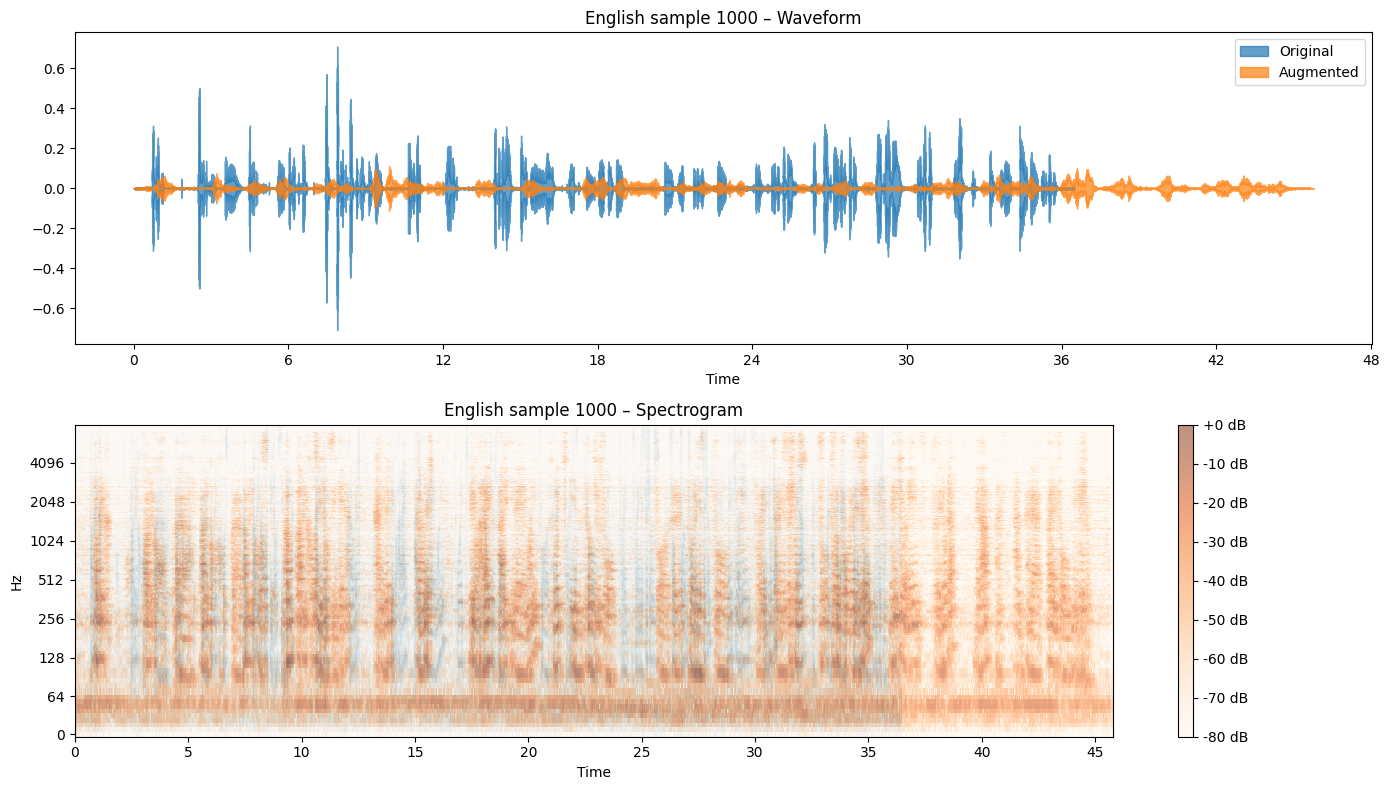

In [17]:
sample_idx = 1000 # try changing this number
sample = dataset[sample_idx]
audio = np.array(sample["audio"]["array"], dtype=np.float32)
sr = sample["audio"]["sampling_rate"]

if sr != 16000:
    audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

aug_audio = AUGMENTER.augment(audio)

show_waveform_and_spectrogram(audio, aug_audio, sr=16000, title_prefix=f"English sample {sample_idx}")


In [10]:
import pandas as pd
import os

# 🐾 Ensure you have an augmentation log list
# (if it doesn’t exist yet, create an empty one so this cell doesn’t crash)
if "augmentation_log" not in locals():
    augmentation_log = []

# ✅ Convert log to a DataFrame
log_df = pd.DataFrame(augmentation_log)

# ✅ Define save path
log_path = os.path.join(OUTPUT_DIR, "augmentation_log.csv")

# ✅ Save the log as CSV
log_df.to_csv(log_path, index=False)

# ✅ Print and preview
print(f"🐱 Augmentation log saved successfully at: {log_path}")
print(f"Total entries: {len(log_df)}")

# Optional — preview first few rows
display(log_df.head())


🐱 Augmentation log saved successfully at: augmented_swahili/augmentation_log.csv
Total entries: 0


""
